# Предсказание цен на автомобили реального рынка

- Денис Рыжов (denis.a.ryzhov@gmail.com)
- Дмитрий Коробов (Pls.mailbox@gmail.com)
- Дмитрий Копылов (kopiloff.dmitry@yandex.ru)

По условиям задачи: 
- нельзя пользоватться нейросетями
- данные должны быть либо взяты из общего доступа, либо скачаны, но не куплены.

Важно:

- качество предсказания;
- скорость предсказания;
- время обучения.

**For your consideration: Performance time of the whole code is about 45 min with my laptop.**

    AMD Ryzen 5 3500U
    RAM 6 GiB @ 2.1 GHz; 4 cores    
    GPU — None

## Краткий отчёт

Работа состояла из 3 этапов:

1. Добыча данных (Data mining)
2. Анализ данных и конструирование признаков (EDA and Feature engineering)
3. Исследование, выбор схемы и настройка моделей (Investigation, choice of prediction scheme and model adjustment)

### 1 Добыча данных (Data mining)

Данные были скачаны с сайта *avto.ru*, распарсены и переведы в таблицу *csv*. Изначально извлечено 133274 записей, занимающие 129.1 MB памяти

### 2 Анализ данных и конструирование признаков (EDA and Feature engineering)

После удаления дубликатов (8846), обработки пропусков (удалено 17) и удаления аномалий (139 записей) для моделирования доступен датасет с 124271 записями. Аномалиями классифицированы редкие машины (напр. гоночные болиды) и редкие классы (электромобили — 91 ~0.07%, машины с «газовыми» двигателями — 19 ~0.015%), не характерные, по нашему мнению, для российского авторынка.

Всего доступно 62 признака: 4 численных, 2 упорядоченных категориальных и 56 «one-hot» категориальных признака (48 бинарных переменных — в основном описание доп.оборудовния).
Данные приведены к типам `int` и `category`, что позволило уменьшить объём памти занимаемым датасетом до 19 МБ.
Проведено нормирование численных данных при помощи `StandardScaler` и перекодировка «one-hot» переменных в duumy-переменные. Упорядоченные переменные не кодировались.

**Важно:** В качестве целевой переменной использовалась степень логарифма цены (степень равна 2/3). Такой подход позволил улучшить предсказания на несколько процентов MAPE.
Преобразование позволило сделать распределение целевого признака существенно равномернее. Степень логарифма подбиралась из соображений: свести медиану и среднего нового распределения к центру интервала изменения переменных (справа и слева от центра интервала — примерно равное число признаков). 

Определена функция метрики, рассчитывающая MAPE в процентах.
Данные поделены на пять выборок в трёх блоках:
- `train1` (3/9) и `valid1` (1/9) — обучающая и валидационная выборки для базовых моделей
- `train2` (3/9) и `valid2` (1/9) — обучающая и валидационная выборки для мета-модели
-`test` (1/9) - выборка для тестирования всей «сборки»
В обучающих выборках оказалось около 41400 записей, в остальных — по 13800.

### 3 Исследование, выбор схемы и настройка моделей (Investigationб choice of prediction scheme and model adjustment)

Общей схемой построения предсказателя была выбрана двухступенчатая модель стекинга. В качестве как базовых, так и мета моделей рассматривались:
- `DecisionTreeRegressor`
- `RandomForestRegressor`
- `LightGBM`
- `CatBoostRegressor`
- `LinearRegression` (только как мета-модель — блендинг)

`RandomForestRegressor`, `LightGBM`, `CatBoostRegressor` оптимизировались по гиперпараметрам при помощи циклической покоординатной оптимизации:



#### Оптимизация моделей по гиперпараметрам

Пока не достигался заданный максимальный уровень изменения метрики (`tolerance`=0.0001% для MAPE) осуществлялся циклический поиск минимума в пространстве гиперпараметров поиском минимума. Минимум искался на сетке по каждой координате внутри цикла. Каждый цикл осуществлял сужение диапазона поиска центрируясь на достигнутом на данном момент точки минимума. *Сейчас поиск сужен до двух последних циклов, поскольку в полной версии (на широком диапазоне) занимал существенное время.*



#### Выбор моделей

В качестве базовых моделей для стекинга рассматривались 4 упомянутые выше модели. Исследование их по параметрам, а также рассмотрение различных комбинаций в качестве «связки» базовых моделей показало, что в нашем случае будет использование нескольких моделей LightGBM с последующим простым усреднением их прогнозов на мета-этапе.

В конечном варианте собирается набор из 25 моделей LightGBM распределённых в пространстве гиперпараметров вокруг (и включая) лучшей базовой модели.

Исследование признаков при помощи метода `feature_importance` показывает, что наша «информационная достаточность» на этапе базовых моделей составляет 99%, т. е., добавление гипотетических новых признаков, скорее всего, даст только 1% прироста необходимой информации. При тех оговорках, что эта оценка основана на предположениях, что a) мы не пропустили какого-то важного признака, а добавляем признаки меньшей значимости б) распределение признаков по их «информационной значимости» близко к экспогенциальному (что в общем подтверждается из опыта). Стоит заметить, что модель показывала результаты существенно хуже без 46 признаков, описывающих дополнительную комплектацию.

Оказывается усреднение по предсказаниям 25 моделей способно улучшить конечное предсказание, поэтому все обученные модели переводятся на следующий этап, где их предсказания усредняются (бэггинг).
Ни модель линейной регрессии, ни любая из остальных 4 моделей, применённых в качестве мета модели не смогли улучшить результаты бэггинга.

Однако стоит заметить, что анализ «информационной важности» признаков (feature importance) для модели LightGBM показал, что предсказаний всего 25 моделей ей недостаточно для прогноза, а нужно120. Возможно получив столько признаков модель справится с большим разбросом предсказаний.

Однако a) такое предположение гадательно и главное b) требует больших временных рескрсов даже для такой «дёгкой» и быстрой модели как LightGBM.

Как показали исследования, очень важны данные. Самим данным присуща довольна большая дисперсия, и по видимому, именно поэтому простой бэггинг (усреднение) справляется так хорошо — ему свойственно хорошо уменьшать variance предсказаний.

### Итог

На основе 25 базовых моделей LightGBM строится усреднённое мета-предсказание (техника бэггинг). Параметры модели выбираются близкими в пространстве гиперпараметров к оптимальной базовой модели. Достигнутая MAPE=13.

## Структура проекта




    1. Подготовка
        1.1 Загрузка модулей, определение констант и т.п.
        1.2 Загрузка данных
    2 Общая информация
        2.1 Дубликаты
        2.2 Пропуски
    3 Исследование признаков
        3.1 Анализ численных переменных
            3.1.0 Целевой признак ('price')
            3.1.1 Численные признаки
        3.2 Категориальные признаки
            3.2.1 Упорядоченные категориальные признаки (Ordinal features)
            3.2.2 Категориальные 'one-hot' признаки
    4 Преобразование данных
        4.1 Преобразование типа данных
        4.2 Преобразование *One-Hot* переменных
        4.3 Преобразование *Ordinal* переменных
        4.4 Масштабирование численных переменных
    5 Prelaunch
        5.0 Target transformation
        5.1 Metrics function (MAPE)
        5.2 Features and target. Samples.
        5.3 Model optimizer
    6 Optimization of base models
        6.1 LightGBM with default parameters
        6.2 Optimization of base models (*LGBMRegressor*)
        6.3 Collection of nearly best base models for meta-phase
        6.4 About the best base model. Feature importance.
        6.5 Averaged over $\sqrt{N}$ and $N$ best models prediction (*LGBMRegressor*)
    7 STACKING
        7.1 BLENDING
            7.1.1 Average prediction (Bagging)
            7.1.2 Weighted average prediction  (*LinerRegression*)
        7.2 Stacking  with LightGBM
            7.2.1 Optimization of  meta model
            7.2.2 Collect an ensemle of nearly best meta models
            7.2.3. About the best meta model. Feature importance.
        7.3 Averaged over $\sqrt{N}$ and $N$ best meta models prediction (*LGBMRegressor*)
    99 Results
    Appendix: Что ещё можно было бы сделать
        VERSIONS

In [1]:
### Versions of libraries

# !pip freeze

# python==3.7.7
# python : datetime, time, warnings

# catboost==0.23
# lightgbm==2.3.0
# matplotlib==3.2.2
# numpy==1.18.5
# pandas==1.0.5
# scipy==1.5.0
# seaborn==0.10.1
# sklearn==0.23.1

# 1. Подготовка

## 1.1 Загрузка модулей, определение констант и т.п.

In [2]:
# Import

import collections
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings


# from datetime import date


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import max_error, make_scorer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


from scipy.stats import gamma, norm


import lightgbm as lgbm
from catboost import CatBoostRegressor

# conda install -c conda-forge catboost
# conda install -c conda-forge lightgbm

In [3]:
### Global constants and settings

FILEPATH = "D:\\Data_Science_0\\Data_Science_=_Skill_Factory\\Real_DS_=_3_auto\\"
RANDOM_STATE = 1607

# warnings.filterwarnings("ignore")

# Plotting

sns.set(style='darkgrid', palette="bright")
sns.set(font_scale = 1.25)
FONT_SIZE = 14

Здесь задаются параметры общие для работы моделей во всё коде.

In [4]:
###  LAUNCH CONTROL CENTER (LCC)

## LGBM parameters (constant)
OBJECTIVE = 'mse'  ## mse, mae, mape
CATEGORICAL_FEATURE_LIST_LGBM = 'auto'
## The point is that lightGBM can handle only features, that are of `category` type, not `object`.


## Parameter for target transformation (power of log)

POWER = 1.5


### fraction of data transferred to models

FRAC = 1
FRAC_MODEL = 1

### Number od data transferred to models
### If exceeds the whole number, model will work with  all data

N_SAMPLE_BASE = 200000
N_SAMPLE_META = 200000


### The distance between vodels in hyperparameter space (for bagging/stacking)
STEP_INT = 1
STEP_LR = 0.001

In [5]:
### AUXILIARY
### Function to print total running time from the start

def running_time(x, x0):
    import pandas
    r_time =  pd.Timestamp(x - x0, unit='s')
    r_hours = r_time.hour
    r_minutes = r_time.minute    
    r_seconds = r_time.second
    r_microseconds = r_time.microsecond
    
    format_string = "[***] This is Houston. The MET is : {}:{}:{}.{}    (H:MM:SS)"
    if r_minutes < 10:
        format_string = "[***] This is Houston. The MET is : {}:0{}:{}.{}    (H:MM:SS)"
        if r_seconds  < 10:
            format_string = "[***] This is Houston. The MET is : {}:0{}:0{}.{}    (H:MM:SS)"
    elif r_seconds  < 10:
        format_string = "[***] This is Houston. The MET is : {}:{}:0{}.{}    (H:MM:SS)"
    print(format_string.format( r_hours, r_minutes, int(r_seconds), int(r_microseconds//1000) ))

In [6]:
### Let's the game begin

total_time_start = time.time()

date_start = datetime.date.today()
time_start = datetime.datetime.now().time()

## 1.2 Загрузка данных

In [7]:
data = pd.read_csv(FILEPATH + "cars_aux.csv")
data

Unnamed: 0   body_type  doors_count        mark       model  \
0                0  COMPACTVAN            4      Nissan      Serena   
1                1     ALLROAD            3  LADA (ВАЗ)  2121 (4x4)   
2                2   HATCHBACK            5  Volkswagen        Polo   
3                3   HATCHBACK            3  LADA (ВАЗ)    1111 Ока   
4                4   HATCHBACK            5  Volkswagen        Golf   
...            ...         ...          ...         ...         ...   
133269      133269     ALLROAD            5         УАЗ     Patriot   
133270      133270     ALLROAD            5   Chevrolet        Niva   
133271      133271     ALLROAD            5  Mitsubishi   Outlander   
133272      133272     ALLROAD            5  Mitsubishi   Outlander   
133273      133273     ALLROAD            3  LADA (ВАЗ)  2121 (4x4)   

       engine_type  displacement  power transmission        gear_type  ...  \
0           DIESEL          1973     91    AUTOMATIC  ALL_WHEEL_DRIVE  ...   
1         GASOLINE          1690     83   MECHANICAL  ALL_WHEEL_DRIVE  ...   
2         GASOLINE          1598     75    AUTOMATIC  FORWARD_CONTROL  ...   
3         GASOLINE           649     29   MECHANICAL  FORWARD_CONTROL  ...   
4         GASOLINE          2324    150   MECHANICAL  FORWARD_CONTROL  ...   
...            ...           ...    ...          ...              ...  ...   
133269    GASOLINE          2693    135   MECHANICAL  ALL_WHEEL_DRIVE  ...   
133270    GASOLINE          1690     80   MECHANICAL  ALL_WHEEL_DRIVE  ...   
133271    GASOLINE          1998    146     VARIATOR  ALL_WHEEL_DRIVE  ...   
133272    GASOLINE          2360    167     VARIATOR  ALL_WHEEL_DRIVE  ...   
133273    GASOLINE          1690     83   MECHANICAL  ALL_WHEEL_DRIVE  ...   

       airbag-1 airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
0             0        0         0         0              0              1   
1             0        0         0         0              0              0   
2             0        0         0         0              0              1   
3             0        0         0         0              0              0   
4             0        0         0         0              0              0   
...         ...      ...       ...       ...            ...            ...   
133269        0        0         0         0              0              1   
133270        0        0         0         0              0              1   
133271        0        0         0         0              1              1   
133272        0        0         0         0              0              0   
133273        0        0         0         0              0              0   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  
0                      1                 0            0            0  
1                      0                 0            0            0  
2                      1                 0            1            0  
3                      0                 0            0            0  
4                      0                 0            0            0  
...                  ...               ...          ...          ...  
133269                 1                 0            0            0  
133270                 1                 0            0            0  
133271                 1                 0            1            1  
133272                 0                 0            0            0  
133273                 0                 0            0            0  

[133274 rows x 63 columns]

# 2 Общая информация

In [8]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133274 entries, 0 to 133273
Data columns (total 63 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     133274 non-null  int64  
 1   body_type                      133274 non-null  object 
 2   doors_count                    133274 non-null  int64  
 3   mark                           133274 non-null  object 
 4   model                          133274 non-null  object 
 5   engine_type                    133274 non-null  object 
 6   displacement                   133274 non-null  int64  
 7   power                          133274 non-null  int64  
 8   transmission                   133274 non-null  object 
 9   gear_type                      133274 non-null  object 
 10  steering_wheel                 133274 non-null  object 
 11  color                          133274 non-null  object 
 12  mileage                       

In [9]:
data = data.drop(['Unnamed: 0'], axis=1)
# data = data.drop(['equipment'], axis=1)

In [10]:
data.columns

Index(['body_type', 'doors_count', 'mark', 'model', 'engine_type',
       'displacement', 'power', 'transmission', 'gear_type', 'steering_wheel',
       'color', 'mileage', 'year', 'section', 'owners', 'price', 'abs',
       'activ-suspension', 'air-suspension', 'asr',
       'collision-prevention-assist', 'esp', 'lane-keeping-assist',
       'park-assist-f', 'park-assist-r', 'sport-suspension', 'vsm',
       'climate-control', 'climate-control-1', 'climate-control-2',
       'climate-control-3', 'condition', 'multizone-climate-control',
       'auto-cruise', 'auto-park', 'computer', 'cruise-control',
       'drowsy-driver-alert-system', 'front-camera', 'navigation',
       'night-vision', 'parktronik', 'projection-display', 'rear-camera',
       'adaptive-light', 'automatic-lighting-control',
       'advanced-frontlighting-system', 'decorative-interior-lighting',
       'halogen', 'laser-lights', 'led-lights', 'xenon', 'airbag-1',
       'airbag-2', 'airbag-4', 'airbag-6', 'airbag-cur

## 2.1 Дубликаты

In [11]:
print("There are {} duplicates.".format( data.duplicated().sum() ))

There are 8846 duplicates.


In [12]:
data.drop_duplicates(inplace=True, ignore_index=True)
print("Now we have {} entries.".format( len(data) ))

Now we have 124428 entries.


## 2.2 Пропуски

In [13]:
target_name = 'price'
print("The target has {} missing values.".format( data[target_name].isna().sum() ))

The target has 0 missing values.


In [14]:
missung_values = data.isna().sum().sort_values(ascending=False)
missung_values

owners               12823
price                    0
climate-control-1        0
climate-control          0
vsm                      0
                     ...  
cruise-control           0
computer                 0
auto-park                0
auto-cruise              0
body_type                0
Length: 62, dtype: int64

In [15]:
print("Maximal amount of missing values ({}, i.e. {:.1%}) is in the '{}'.".format( data.isna().sum().max(), 
                                                                                  data.isna().sum().max()/len(data),
                                                                                  data.isna().sum().idxmax() ))

Maximal amount of missing values (12823, i.e. 10.3%) is in the 'owners'.


Пропуски есть только в признаке 'owners'.

In [16]:
data[ data['owners'].isna() ][['year', 'mileage', 'owners']]

year  mileage  owners
3280    2019        0     NaN
3282    2019        0     NaN
3283    2019        0     NaN
3286    2019        0     NaN
3287    2019        0     NaN
...      ...      ...     ...
123366  2018        0     NaN
123373  2018        0     NaN
123378  2018        0     NaN
123383  2018        0     NaN
123388  2018        0     NaN

[12823 rows x 3 columns]

In [17]:
data[ data['owners'].isna() ]['mileage'].value_counts()

0         12806
145000        1
295000        1
66000         1
83000         1
67000         1
200000        1
218000        1
120000        1
163000        1
110158        1
99164         1
74800         1
190000        1
110000        1
160000        1
95000         1
220000        1
Name: mileage, dtype: int64

Подавляющее число пропусков в 'owners' - это машины с нулевым пробегом, т.е., новые. Укажем таким машинам `owners=0`, остальные 13 пропусков удалим.

In [18]:
to_drop_mask = ( data['owners'].isna() ) & (data['mileage'] > 0)
print(to_drop_mask.sum())
# to_drop_mask[ to_drop_mask==True ]

17


In [19]:
data = data.drop(index=to_drop_mask[ to_drop_mask==True ].index).reset_index(drop=True)
data = data.fillna(0)
# data.isna().sum()

# 3 Исследование признаков

Определим какие признаки являются:
- численными (numerical)
- категориальными (categorical) среди которых есть
  - упорядоченные (ordinal)
  - бинарные (binary)
  - прочие неупорядоченные

In [20]:
features_set = set(data.columns) - set('price')

features_numerical = ['displacement', 'power', 'mileage', 'year']
features_numerical_set = set(features_numerical)

features_categorical_set = features_set - features_numerical_set
features_categorical = list(features_categorical_set)

features_ordinal = ['doors_count', 'owners']
features_ordinal_set = set(features_ordinal)

features_one_hot_set = features_categorical_set - features_ordinal_set
features_one_hot = list(features_one_hot_set)


print("There are {} variables.".format(len(features_set)))
print("There are {} numerical variables:".format( len(features_numerical) ), features_numerical)
print("There are {} categorical variables, amongst them:\n    {} ordinal variables:"
      .format( len(features_categorical_set), len(features_ordinal) ), features_ordinal)
print("        and")
print("    {} 'one-hot' variables:\n".
      format( len(features_one_hot) ), features_one_hot)

There are 62 variables.
There are 4 numerical variables: ['displacement', 'power', 'mileage', 'year']
There are 58 categorical variables, amongst them:
    2 ordinal variables: ['doors_count', 'owners']
        and
    56 'one-hot' variables:
 ['gear_type', 'navigation', 'mark', 'model', 'esp', 'steering_wheel', 'knee-airbag', 'price', 'projection-display', 'adaptive-light', 'lane-keeping-assist', 'multizone-climate-control', 'advanced-frontlighting-system', 'airbag-curtain', 'halogen', 'climate-control-1', 'laser-lights', 'cruise-control', 'drowsy-driver-alert-system', 'airbag-driver', 'led-lights', 'parktronik', 'xenon', 'airbag-4', 'front-camera', 'automatic-lighting-control', 'collision-prevention-assist', 'climate-control-3', 'activ-suspension', 'body_type', 'abs', 'auto-cruise', 'night-vision', 'transmission', 'condition', 'decorative-interior-lighting', 'park-assist-r', 'park-assist-f', 'airbag-6', 'rear-camera', 'sport-suspension', 'color', 'climate-control-2', 'climate-control

## 3.1 Анализ численных переменных

In [21]:
def num_variable_analysis(df, item, target_name, n_bins=100):
    if item != target_name:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    
    # ==== FIG 1 (boxplot)    
    df.boxplot(column=item, ax=axes[0])
    axes[0].set_title(item, fontsize=FONT_SIZE)

    
    # ==== FIG 2 (distplot)
    sns.distplot(df[item], bins=n_bins, kde=True, ax=axes[1], vertical=True)
    axes[1].set_title(item, fontsize=FONT_SIZE)
    plt.xticks(rotation=45)
    # axes.set_xlim((0, 100))
    
    
    # === FIG 3 (scatterplot)
    if item != target_name:
        axes[2] = sns.scatterplot(x=item, y=target_name, data=df)
    
    plt.show()
    
    # === Descriptive statistics
    describer = pd.DataFrame(df[item].describe()).T    
    print("==== {} ====".format(item))
    print(describer, "\n")
    
    
    # Pearson correlation coefficient for feature/target
    if item != target_name:
        corr_coeff = np.array(df[[item, target_name]].corr())[0, 1]
        print("Pearson correlation coefficient between '{}' and '{}' is {:.4f}.".format( item, target_name, corr_coeff ), "\n")
    
    
    # === Missing values
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), "\n"*2)

### 3.1.0 Целевой признак ('price')


  
Анализировались как распределения собственно цены на автомобиль, так и её логарифма (эта версия сейчас активна, переключение обратно на анализ цены - закомментировать ячейку `### MARK: TARGET TRANSFORMATION`)

In [22]:
data[target_name].min()

15000

In [23]:
### MARK: TARGET TRANSFORMATION

data['price_log10'] = np.log10(data[target_name])
target_name = 'price_log10'

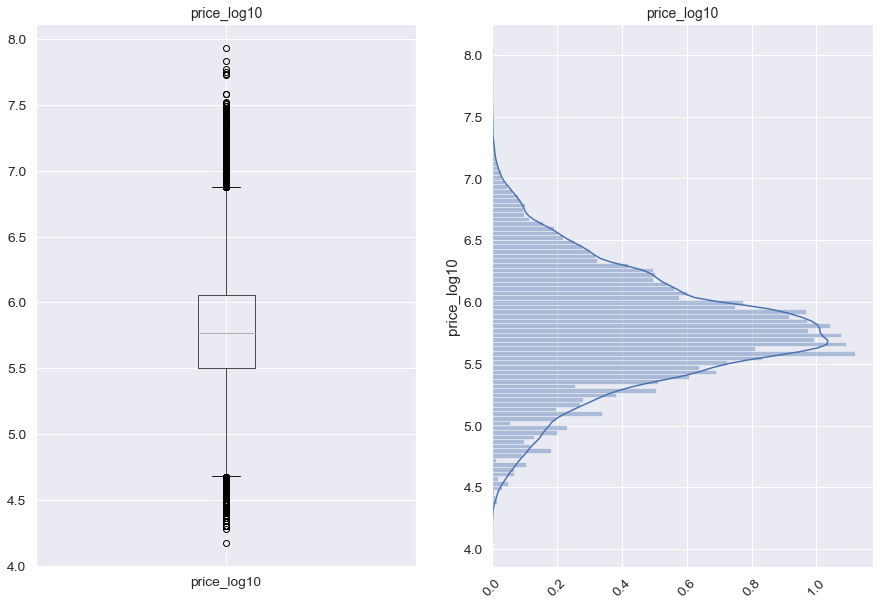

==== price_log10 ====
                count      mean       std       min      25%       50%  \
price_log10  124411.0  5.776436  0.452597  4.176091  5.50515  5.767156   

                  75%       max  
price_log10  6.054613  7.929419   

There are 0 missing values in 'price_log10'. 




In [24]:
num_variable_analysis(data, target_name, target_name)

Рассмотрим отдельно несколько диапазонов цен:

1. "Низкие" цены (меньше 10 млн руб.)

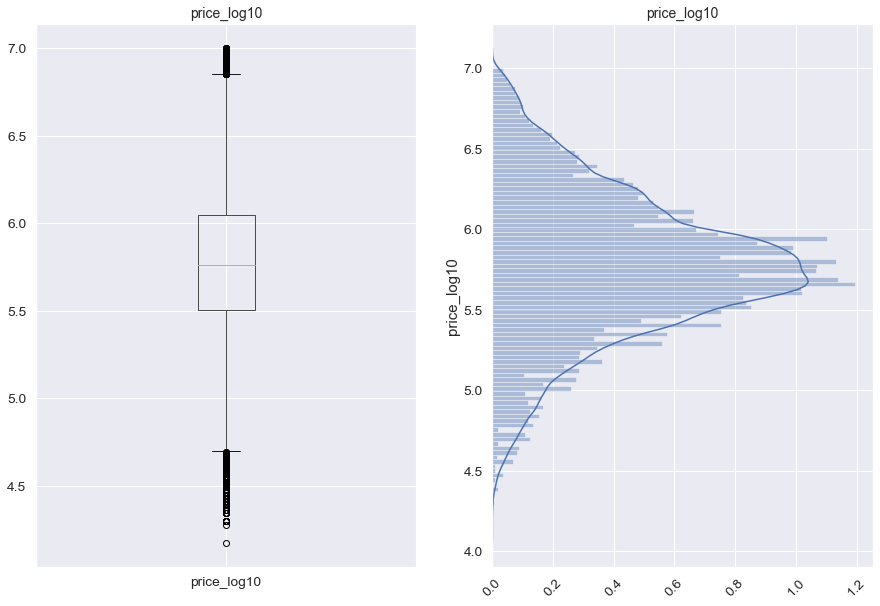

==== price_log10 ====
                count      mean       std       min      25%       50%  \
price_log10  123882.0  5.770604  0.444567  4.176091  5.50515  5.763428   

                  75%       max  
price_log10  6.045323  6.999957   

There are 0 missing values in 'price_log10'. 




In [25]:
if target_name == 'price_log10':
    upper_price_limit = 7
else:
    upper_price_limit = 10*10**6

df = data[ data[target_name] < upper_price_limit ]

num_variable_analysis(df, target_name, target_name)

2. Высокие цены (выше 10 млн. руб.)

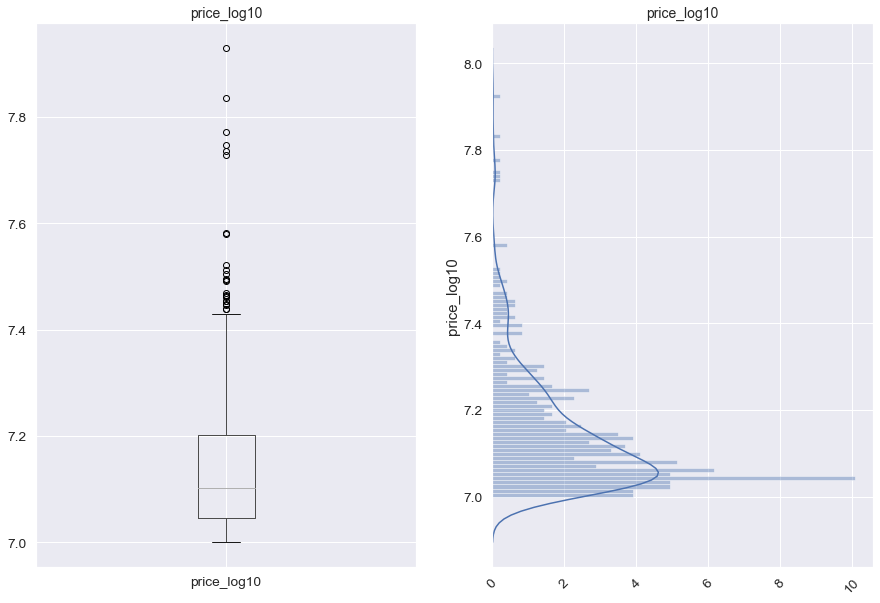

==== price_log10 ====
             count     mean       std       min       25%       50%       75%  \
price_log10  523.0  7.14384  0.136565  7.000182  7.045552  7.103256  7.202337   

                  max  
price_log10  7.929419   

There are 0 missing values in 'price_log10'. 




In [26]:
df = data[ data[target_name] > upper_price_limit ]

num_variable_analysis(df, target_name, target_name)

3. Промежуточный (с перекрытием) диапазон цен: от 5 до 15 млн руб.

In [27]:
np.log10(1.5), np.log10(2)

(0.17609125905568124, 0.3010299956639812)

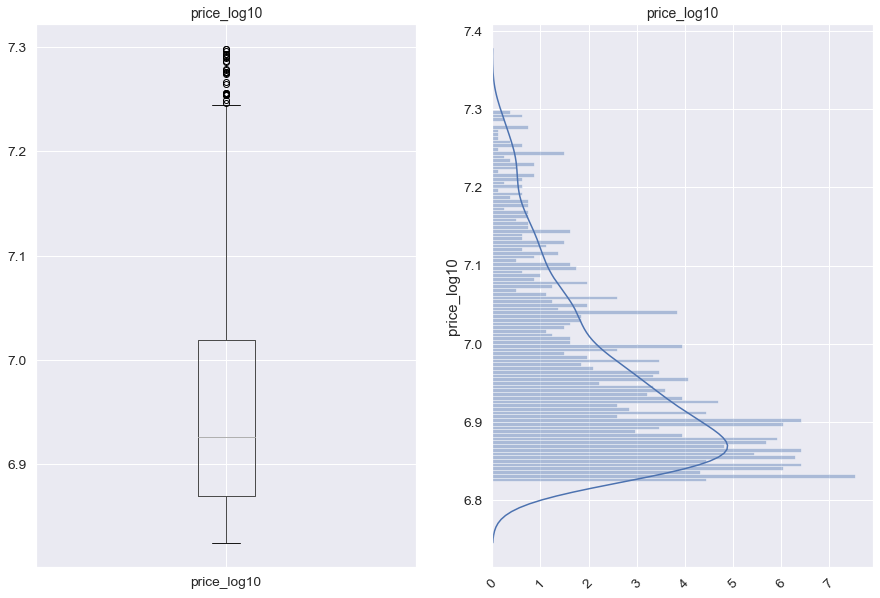

==== price_log10 ====
              count     mean       std      min       25%       50%       75%  \
price_log10  1707.0  6.95565  0.109543  6.82436  6.868832  6.925737  7.019454   

                  max  
price_log10  7.298853   

There are 0 missing values in 'price_log10'. 




In [28]:
if target_name == 'price_log10':
    df = data[ (upper_price_limit-np.log10(1.5) < data[target_name]) & (data[target_name] < upper_price_limit+np.log10(2)) ]
else:
    df = data[ (0.5*upper_price_limit < data[target_name]) & (data[target_name] < 1.5*upper_price_limit) ]

num_variable_analysis(df, target_name, target_name)

На этоп этапе никаких аномалий не выявлено.

### 3.1.1 Численные признаки

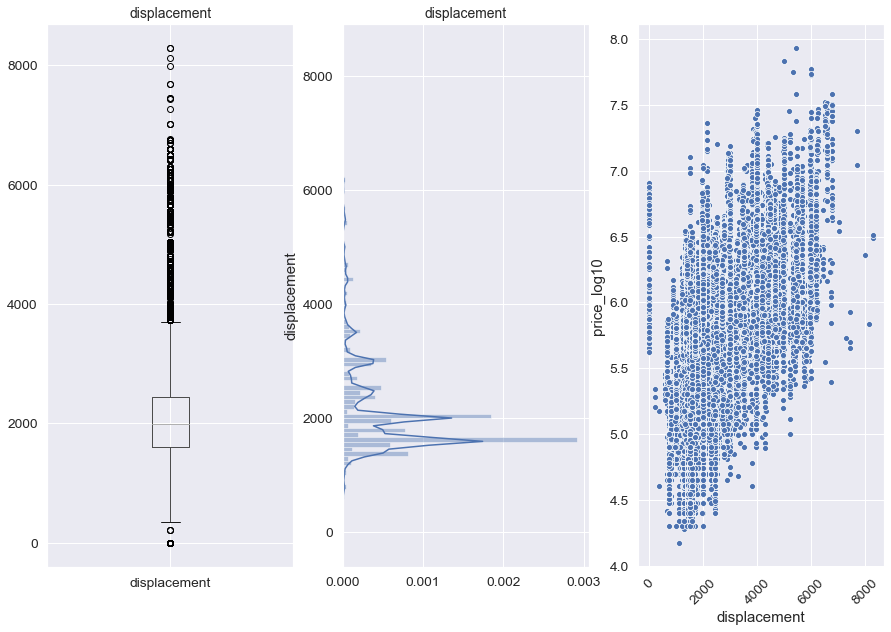

==== displacement ====
                 count         mean         std  min     25%     50%     75%  \
displacement  124411.0  2151.674185  873.758248  0.0  1596.0  1984.0  2445.0   

                 max  
displacement  8285.0   

Pearson correlation coefficient between 'displacement' and 'price_log10' is 0.4397. 

There are 0 missing values in 'displacement'. 




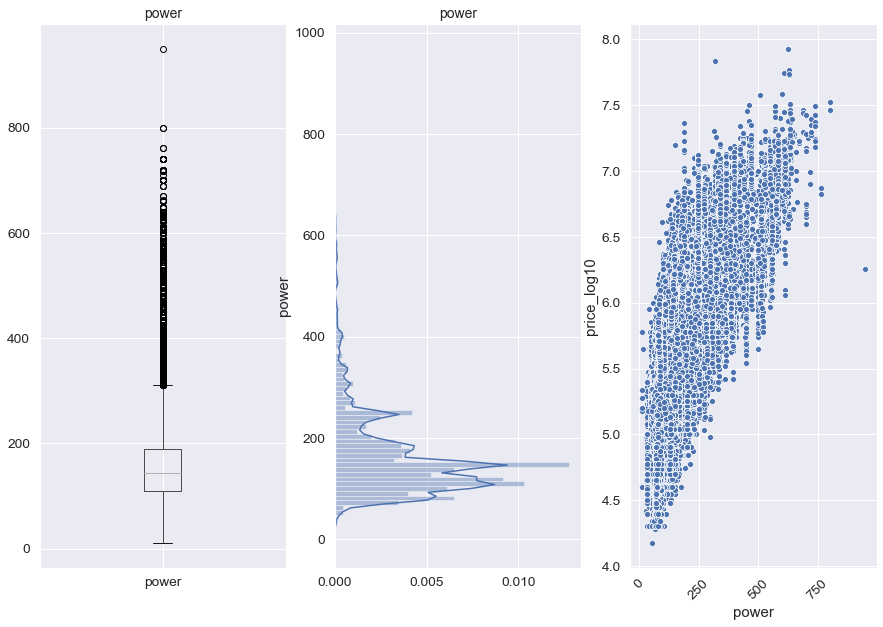

==== power ====
          count        mean        std   min    25%    50%    75%    max
power  124411.0  163.082332  82.868188  11.0  109.0  144.0  190.0  950.0 

Pearson correlation coefficient between 'power' and 'price_log10' is 0.6318. 

There are 0 missing values in 'power'. 




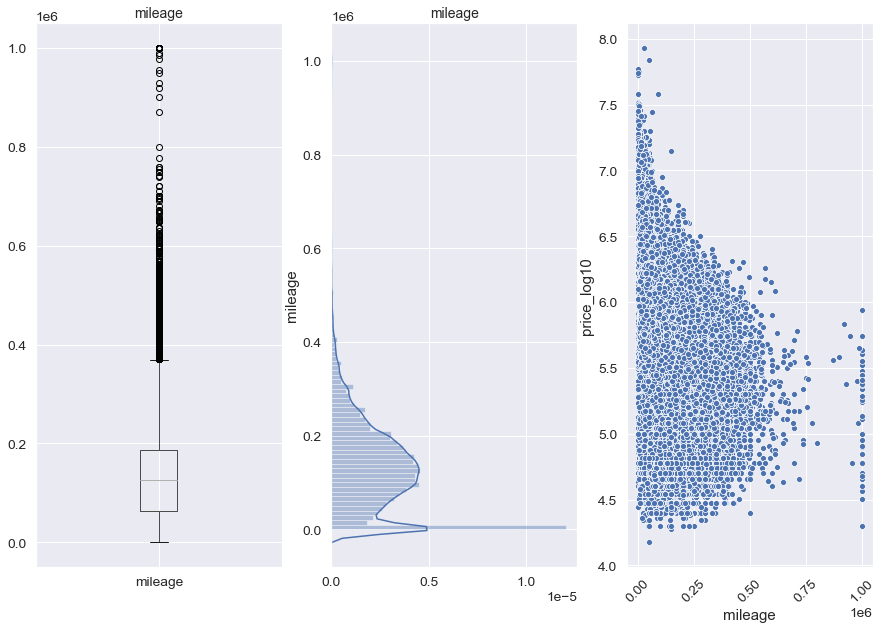

==== mileage ====
            count           mean          std  min      25%       50%  \
mileage  124411.0  132174.555682  95572.06816  0.0  63426.5  125000.0   

              75%        max  
mileage  186043.5  1000000.0   

Pearson correlation coefficient between 'mileage' and 'price_log10' is -0.5256. 

There are 0 missing values in 'mileage'. 




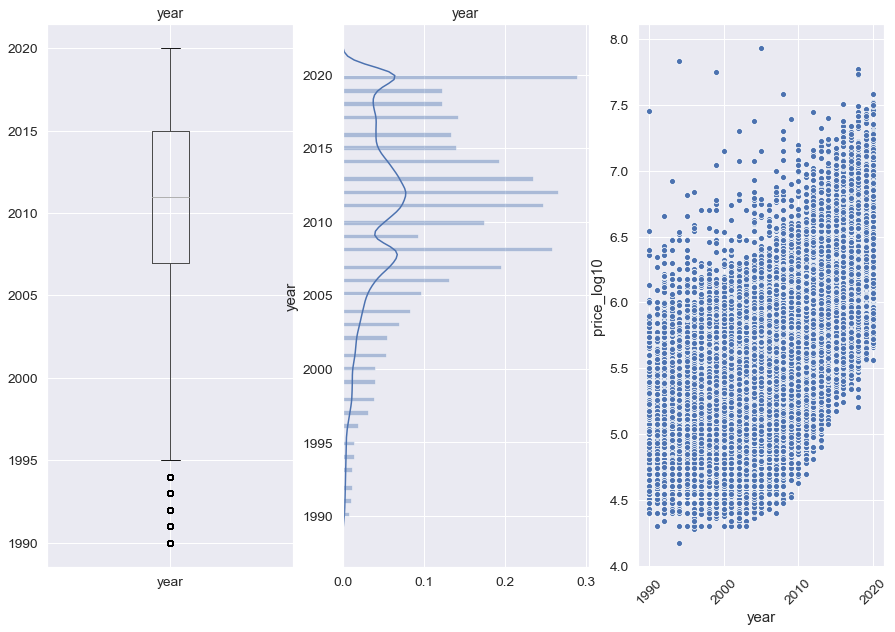

==== year ====
         count         mean       std     min     25%     50%     75%     max
year  124411.0  2010.744388  6.285782  1990.0  2007.0  2011.0  2015.0  2020.0 

Pearson correlation coefficient between 'year' and 'price_log10' is 0.7145. 

There are 0 missing values in 'year'. 




In [29]:
for item in features_numerical:
    num_variable_analysis(data, item, target_name)

**Выделяются**:
1. 6 машин с ценой выше 40 млн руб.
2. несколько машин с объёмом двигателя свыше 7 л
3. автомобиль с мощностью двигателя 950 л.с.
4. минимальная мощность двигателя 11 л.с.
5. автомобили с нулевым объёмом двигателя
6. раритет 1990 года ценой за 2 млн руб

In [30]:
if target_name != 'price_log10':
    limit = 40*10**6
else:
    limit = np.log10(40*10**6)
         
data[ data[target_name] > limit]

body_type  doors_count           mark            model engine_type  \
30726      SEDAN            4  Mercedes-Benz          S-Класс    GASOLINE   
54032      COUPE            2  Mercedes-Benz      SLR McLaren    GASOLINE   
86989      COUPE            2   Aston Martin       V8 Vantage    GASOLINE   
122346     SEDAN            4  Mercedes-Benz  Maybach S-Класс    GASOLINE   
122350     SEDAN            4  Mercedes-Benz  Maybach S-Класс    GASOLINE   
122356     SEDAN            4  Mercedes-Benz  Maybach S-Класс    GASOLINE   

        displacement  power transmission   gear_type steering_wheel  ...  \
30726           4973    320    AUTOMATIC  REAR_DRIVE           LEFT  ...   
54032           5439    626    AUTOMATIC  REAR_DRIVE           LEFT  ...   
86989           5341    608   MECHANICAL  REAR_DRIVE           LEFT  ...   
122346          5980    630    AUTOMATIC  REAR_DRIVE           LEFT  ...   
122350          5980    630    AUTOMATIC  REAR_DRIVE           LEFT  ...   
122356          5980    630    AUTOMATIC  REAR_DRIVE           LEFT  ...   

       airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
30726         0         0         0              0              0   
54032         0         0         0              0              0   
86989         0         0         0              0              0   
122346        0         0         0              1              1   
122350        0         0         0              1              1   
122356        0         0         0              1              1   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
30726                  0                 0            0            0   
54032                  0                 0            0            0   
86989                  0                 0            0            0   
122346                 1                 1            1            0   
122350                 1                 1            1            0   
122356                 1                 1            1            0   

        price_log10  
30726      7.835691  
54032      7.929419  
86989      7.748188  
122346     7.728138  
122350     7.771496  
122356     7.736878  

[6 rows x 63 columns]

In [31]:
print(len(data[ data['displacement'] >= 7000 ]))
data[ data['displacement'] >= 7000 ]

13


body_type  doors_count       mark      model engine_type  \
251       ALLROAD            5  Chevrolet   Suburban    GASOLINE   
373       ALLROAD            5  Chevrolet   Suburban    GASOLINE   
18638   LIMOUSINE            4        ЗИЛ       4104    GASOLINE   
32035     ALLROAD            5  Chevrolet   Suburban    GASOLINE   
35709       COUPE            2  Chevrolet   Corvette    GASOLINE   
54290    ROADSTER            2      Dodge      Viper    GASOLINE   
54418      PICKUP            4  Chevrolet  Avalanche    GASOLINE   
87020   LIMOUSINE            4        ЗИЛ       4104    GASOLINE   
88366     MINIVAN            4       Ford  Econoline      DIESEL   
102671      COUPE            2  Chevrolet   Corvette    GASOLINE   
103622   ROADSTER            2      Dodge      Viper    GASOLINE   
105181      COUPE            2  Chevrolet   Corvette    GASOLINE   
117267      COUPE            2      Dodge      Viper    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  ...  \
251             7446    290    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   
373             7446    290    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   
18638           7680    315    AUTOMATIC       REAR_DRIVE           LEFT  ...   
32035           7443    233    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   
35709           7011    513   MECHANICAL       REAR_DRIVE           LEFT  ...   
54290           8285    507   MECHANICAL       REAR_DRIVE           LEFT  ...   
54418           8128    325    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   
87020           7680    315    AUTOMATIC       REAR_DRIVE           LEFT  ...   
88366           7270    215    AUTOMATIC       REAR_DRIVE           LEFT  ...   
102671          7011    513   MECHANICAL       REAR_DRIVE           LEFT  ...   
103622          8285    507   MECHANICAL       REAR_DRIVE           LEFT  ...   
105181          7011    513   MECHANICAL       REAR_DRIVE           LEFT  ...   
117267          7990    456   MECHANICAL       REAR_DRIVE           LEFT  ...   

       airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
251           0         0         0              0              0   
373           0         0         0              0              1   
18638         0         0         0              0              0   
32035         0         0         0              0              0   
35709         0         0         0              0              0   
54290         0         0         0              0              1   
54418         0         0         0              0              1   
87020         0         0         0              0              0   
88366         0         0         0              0              0   
102671        0         0         0              0              0   
103622        0         0         0              0              0   
105181        0         0         0              0              0   
117267        0         0         0              0              0   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
251                    0                 0            0            0   
373                    0                 0            0            0   
18638                  0                 0            0            0   
32035                  0                 0            0            0   
35709                  0                 0            0            0   
54290                  1                 0            0            0   
54418                  1                 1            1            0   
87020                  0                 0            0            0   
88366                  0                 0            0            0   
102671                 0                 0            0            0   
103622                 0                 0            0            0   
105181                 0                 0            0            0   
117267           

In [32]:
data[ data['power'] >= 900 ]

body_type  doors_count            mark                model  \
40871  SPEEDSTER            0  Гоночный болид  Шоу-кар «Формула-1»   

      engine_type  displacement  power transmission   gear_type  \
40871    GASOLINE          3000    950        ROBOT  REAR_DRIVE   

      steering_wheel  ... airbag-2  airbag-4  airbag-6 airbag-curtain  \
40871           LEFT  ...        0         0         0              0   

       airbag-driver  airbag-passenger  airbag-rear-side  airbag-side  \
40871              0                 0                 0            0   

       knee-airbag  price_log10  
40871            0     6.255273  

[1 rows x 63 columns]

In [33]:
data[ data['power']<30 ]

body_type  doors_count        mark     model engine_type  \
3       HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
1743    HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
8018        COUPE            2     Renault     Twizy     ELECTRO   
30826   HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
31847   HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
31902       COUPE            2         СМЗ      С-3Д    GASOLINE   
32182       COUPE            2         СМЗ      С-3Д    GASOLINE   
79284       COUPE            2     Renault     Twizy     ELECTRO   
89022   HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
122344  HATCHBACK            4       Bajaj      Qute    GASOLINE   
122432  HATCHBACK            4       Bajaj      Qute    GASOLINE   
122576  HATCHBACK            4       Bajaj      Qute    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  ...  \
3                649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
1743             649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
8018               0     17    AUTOMATIC       REAR_DRIVE           LEFT  ...   
30826            649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
31847            649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
31902            346     12   MECHANICAL       REAR_DRIVE           LEFT  ...   
32182            346     12   MECHANICAL       REAR_DRIVE           LEFT  ...   
79284              0     11    AUTOMATIC       REAR_DRIVE           LEFT  ...   
89022            649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
122344           217     13        ROBOT       REAR_DRIVE           LEFT  ...   
122432           217     13        ROBOT       REAR_DRIVE           LEFT  ...   
122576           217     13        ROBOT       REAR_DRIVE           LEFT  ...   

       airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
3             0         0         0              0              0   
1743          0         0         0              0              0   
8018          0         0         0              0              0   
30826         0         0         0              0              0   
31847         0         0         0              0              0   
31902         0         0         0              0              0   
32182         0         0         0              0              0   
79284         0         0         0              0              1   
89022         0         0         0              0              0   
122344        0         0         0              0              0   
122432        0         0         0              0              0   
122576        0         0         0              0              0   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
3                      0                 0            0            0   
1743                   0                 0            0            0   
8018                   0                 0            0            0   
30826                  0                 0            0            0   
31847                  0                 0            0            0   
31902                  0                 0            0            0   
32182                  0                 0            0            0   
79284                  0                 0            0            0   
89022                  0                 0            0            0   
122344                 0                 0            0            0   
122432                 0                 0            0            0   
122576                 0                 0            0            0   

        price_log10  
3          4.414973  
1743       4.977724  
8018       5.652246  
30826      4.698970  
31847      5.290035  
31902      4.602060  
32182      5.176091  
79284      5.777427  
89022      4.653213  
122344     5.2

In [34]:
limit_t = 20*10**6
if target_name == 'price_log10':
    limit_t = np.log10(20*10**6)
    
    
data[ (data['year']==1990) & (data[target_name] > limit_t)]

body_type  doors_count         mark  model engine_type  displacement  \
30735    PICKUP            4  Lamborghini  LM002    GASOLINE          5167   

       power transmission        gear_type steering_wheel  ... airbag-2  \
30735    455   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  ...        0   

       airbag-4  airbag-6 airbag-curtain  airbag-driver  airbag-passenger  \
30735         0         0              0              0                 0   

       airbag-rear-side  airbag-side  knee-airbag  price_log10  
30735                 0            0            0     7.454845  

[1 rows x 63 columns]

In [35]:
print(len(data[ data['displacement']==0 ]))
data[ data['displacement']==0 ]['engine_type']

91


3295      ELECTRO
5587      ELECTRO
5625      ELECTRO
5636      ELECTRO
5761      ELECTRO
           ...   
101455    ELECTRO
115383    ELECTRO
115685    ELECTRO
123096    ELECTRO
123101    ELECTRO
Name: engine_type, Length: 91, dtype: object

In [36]:
data[ data['displacement']==0 ]['engine_type'].value_counts()

ELECTRO    91
Name: engine_type, dtype: int64

1. 6 машин с ценой выше 40 млн руб.- несколько машин с объёмом двигателя свыше 7 л
 - люксовые (Maybach S-Класс и Mercedes-Benz S-Класс (W220)) и спортивные машины (Mercedes-Benz SLR McLaren, Aston Martin Vantage). С Aston Martin Vantage есть загадка: модель выпускалась с 2005, а в базе стоит 1999 год...
2. 13 машин с объёмом двигателя свыше 7 л
 - 3 "пассажирских грузовика" (SUV) Chevrolet Suburban 9-го поколения и его производная Chevrolet Avalanche
 - 2 "членовоза" ЗИЛ-41047
 - "спортсмены" Dodge Viper и Chevrolet Corvette (по 3 штуки)
 - фургон Ford Econoline
3. автомобиль с мощностью двигателя 950 л.с.
 - Шоу-кар «Формула-1»
4. аавтомобили с мощностью двигателя меньше 30 л.с.:
 - СМЗ С-3Д - инвалидка" (2)
 - Bajaj Qute - индийский квадрицикл (3)
 - Renault Twizy - еропейский электро-квадрицикл (2)
 - LADA (ВАЗ) - 1111 Ока (5) 
5. автомобили с нулевым объёмом двигателя
 - электромобили
6. раритет 1990 года ценой за 2 млн
 - Это внедорожник Lamborghini LM002 ! 
 
Далеко не рядовые 120 машин. Все они имеют право на существование, но для общего рынка будут скорее аномалиями и способны подпортить предсказатель.

Сейчас удаляем все, кроме "Оки". Будет время - попробуем вернуть частями и посмотреть как изменится модель. В первую очередь - "электрички".

In [37]:
if target_name == 'price_log10':
    data = data[ data[target_name] < np.log10(40*10**6)]
else:
    data = data[ data[target_name] < 40*10**6]

data = data[ data['displacement'] <= 7000 ]
data = data[ data['power'] < 900 ]
data = data[ data['power'] > 20 ]
data = data[ data['engine_type'] != 'ELECTRO' ]

if target_name == 'price_log10':
    index_to_drop = data[ (data['year']==1990) & (data[target_name] > np.log10(20*10**6))].index
else:
    index_to_drop = data[ (data['year']==1990) & (data[target_name] > 20*10**6)].index
    
data = data.drop(index=index_to_drop).reset_index(drop=True)
# data

После "первичной очистки" снова глянем на численные признаки:

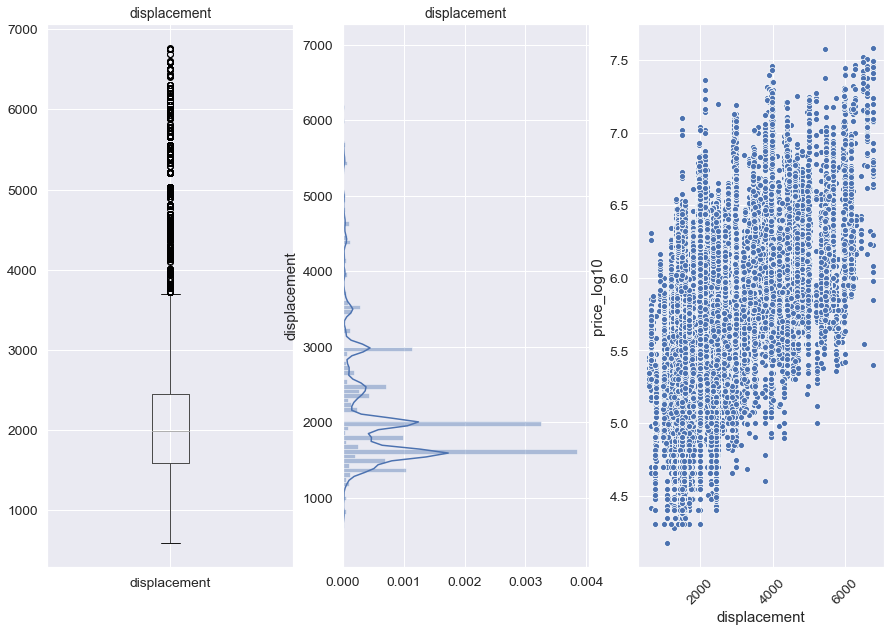

==== displacement ====
                 count         mean         std    min     25%     50%  \
displacement  124294.0  2152.558032  869.975725  599.0  1596.0  1984.0   

                 75%     max  
displacement  2445.0  6761.0   

Pearson correlation coefficient between 'displacement' and 'price_log10' is 0.4420. 

There are 0 missing values in 'displacement'. 




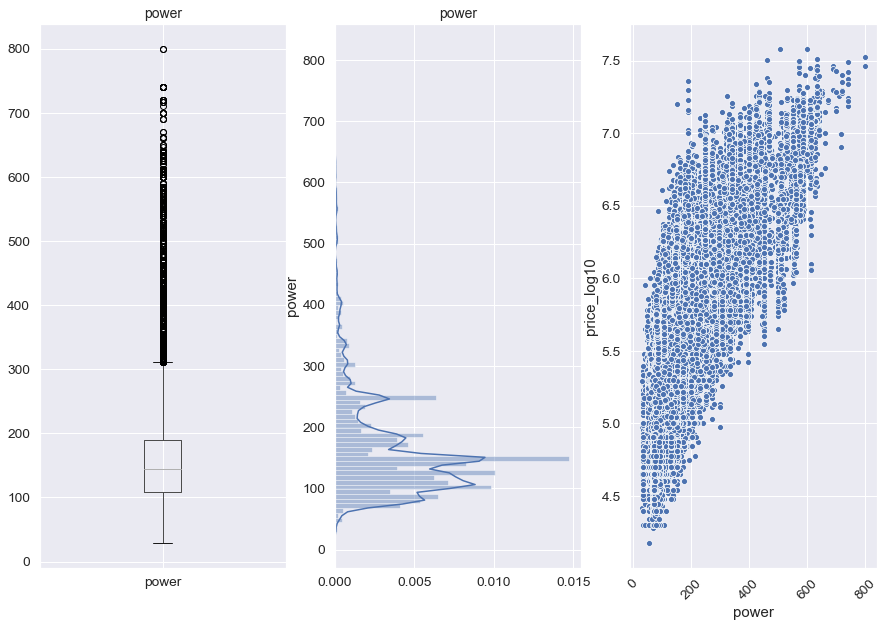

==== power ====
          count        mean       std   min    25%    50%    75%    max
power  124294.0  162.994054  82.58558  29.0  109.0  144.0  190.0  800.0 

Pearson correlation coefficient between 'power' and 'price_log10' is 0.6315. 

There are 0 missing values in 'power'. 




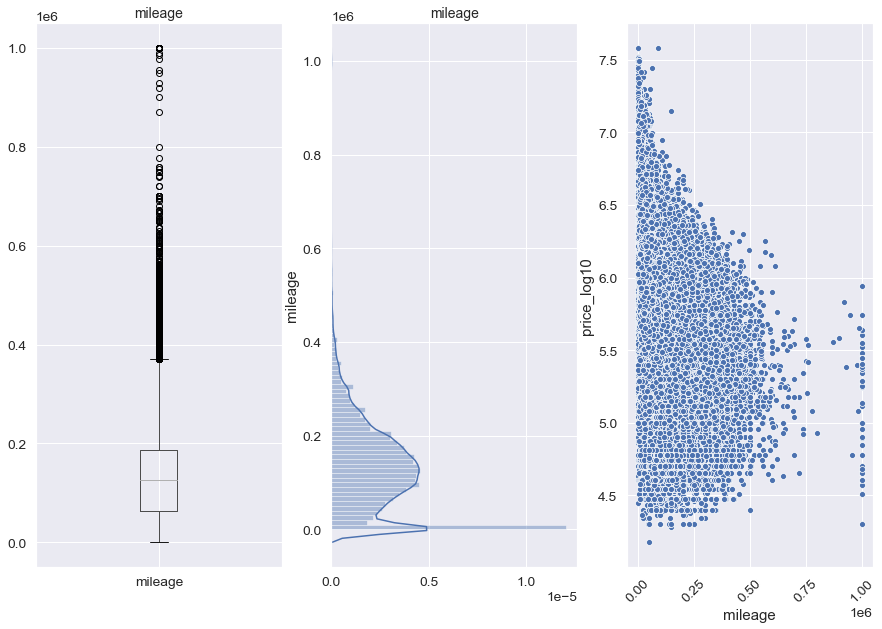

==== mileage ====
            count           mean         std  min      25%       50%  \
mileage  124294.0  132246.902554  95551.3634  0.0  63700.0  125000.0   

               75%        max  
mileage  186385.75  1000000.0   

Pearson correlation coefficient between 'mileage' and 'price_log10' is -0.5256. 

There are 0 missing values in 'mileage'. 




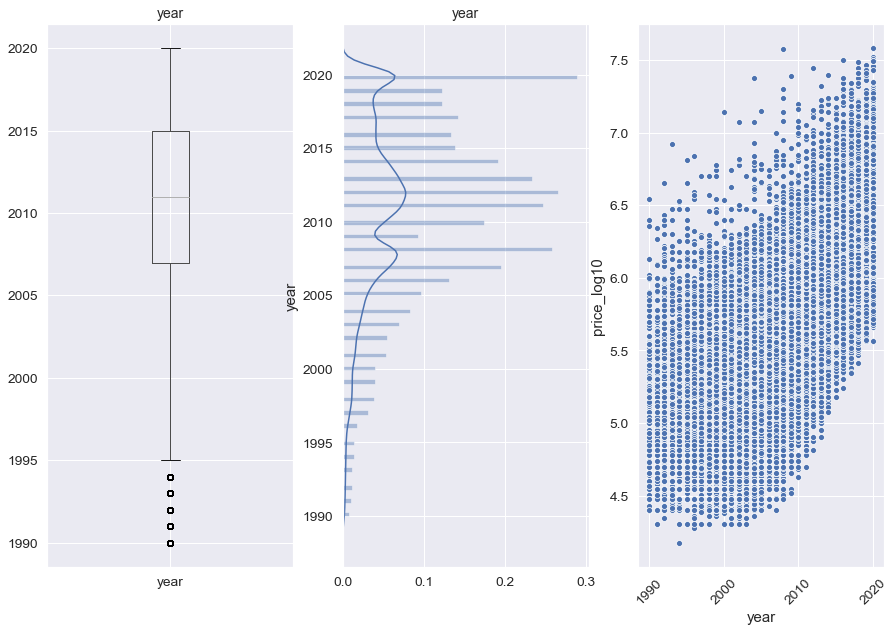

==== year ====
         count        mean       std     min     25%     50%     75%     max
year  124294.0  2010.74286  6.285579  1990.0  2007.0  2011.0  2015.0  2020.0 

Pearson correlation coefficient between 'year' and 'price_log10' is 0.7154. 

There are 0 missing values in 'year'. 




In [38]:
for item in features_numerical:
    num_variable_analysis(data, item, target_name)

Вопиющих аномалий не видно.

## 3.2 Категориальные признаки

Сколько в каждом категориальном признаке категорий:

In [39]:
categorical_unique_dict = dict()
for item in features_categorical:
    categorical_unique_dict[item] = data[item].nunique()

categorical_unique = pd.Series(categorical_unique_dict, index=categorical_unique_dict.keys()).sort_values(ascending=False)
categorical_unique

price                            10656
model                             1393
mark                               120
body_type                           16
color                               16
doors_count                          5
owners                               4
engine_type                          4
transmission                         4
gear_type                            3
cruise-control                       2
drowsy-driver-alert-system           2
parktronik                           2
airbag-driver                        2
led-lights                           2
climate-control-1                    2
xenon                                2
airbag-4                             2
laser-lights                         2
multizone-climate-control            2
halogen                              2
airbag-curtain                       2
advanced-frontlighting-system        2
automatic-lighting-control           2
adaptive-light                       2
projection-display       

In [40]:
print("We have {} binary variables.".format(categorical_unique[ categorical_unique == 2 ].count()))

We have 48 binary variables.


### 3.2.1 Упорядоченные категориальные признаки (Ordinal features)

In [41]:
def ordinal_variable_analysis(df, item, target_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    
    # ==== FIG 1 (barplot)
    bar_data = df.groupby(item)[item].count()
    br_plot = sns.barplot(x=bar_data.index, y=bar_data, ax = axes[0], palette="Blues_d")
    br_plot.set_xticklabels(bar_data.index, rotation=45)
    axes[0].set_title(item, fontsize=FONT_SIZE)
    
    
    # ==== FIG 2 (boxplots for classes)
    bx_plot = sns.boxplot(x=item, y=target_name, data=df, ax=axes[1])    
    bx_plot.set_xticklabels(bar_data.index, rotation=45)
    plt.xticks(rotation=45)
    axes[1].set_title(item, fontsize=FONT_SIZE)

        
    # ==== FIG 3 (kdeplots for classes)
    values = df[item].value_counts()
    
    for value in values.index:
        sns.kdeplot(df[ df[item] == value ][target_name], vertical=True, ax=axes[2], label=value)    
    axes[2].set_title(item, fontsize=FONT_SIZE)
    axes[2].legend(fontsize=FONT_SIZE)
    
    plt.show()
    
    # === Descriptive statistics
    
    print("==== {} ====\n".format(item))
    if item != target_name:
        print("Pearson correlation coefficient between '{}' and '{}' is {:.4f}."
              .format( item, 
                      target_name, 
                      np.array(df[[item, target_name]].corr())[0, 1] ), "\n")
    
    print(bar_data, "\n")
    
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), '\n'*2)

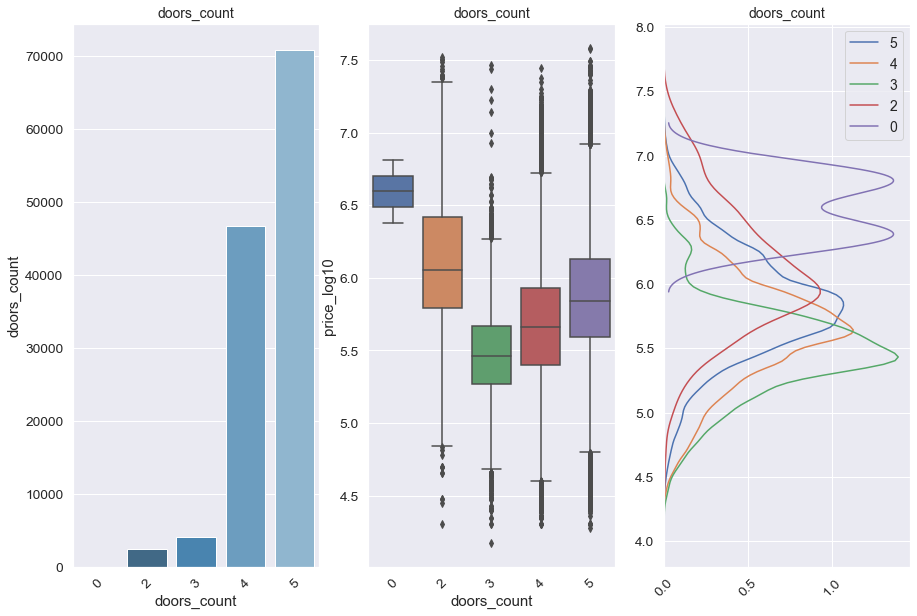

==== doors_count ====

Pearson correlation coefficient between 'doors_count' and 'price_log10' is 0.1403. 

doors_count
0        2
2     2464
3     4159
4    46750
5    70919
Name: doors_count, dtype: int64 

There are 0 missing values in 'doors_count'. 




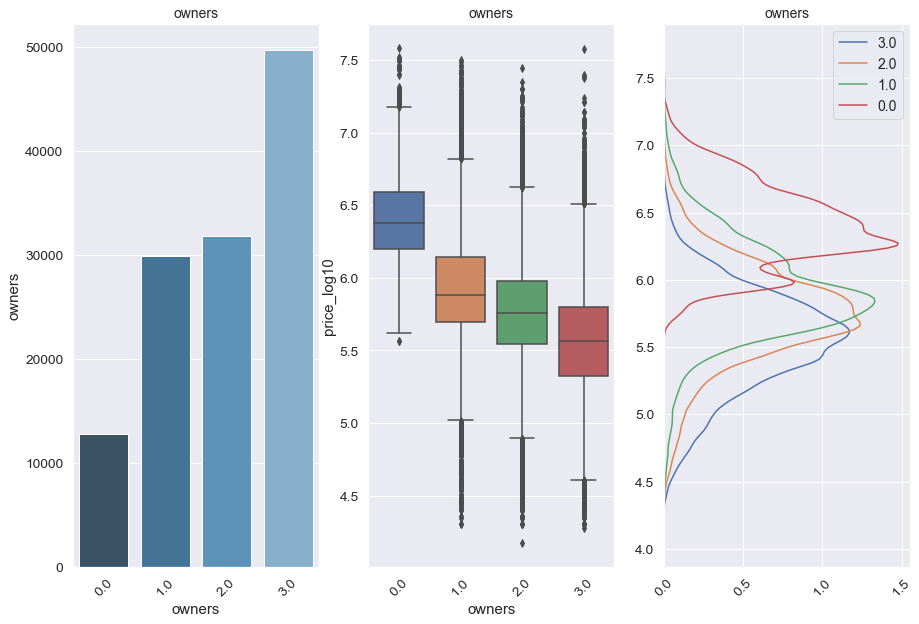

==== owners ====

Pearson correlation coefficient between 'owners' and 'price_log10' is -0.5452. 

owners
0.0    12798
1.0    29922
2.0    31817
3.0    49757
Name: owners, dtype: int64 

There are 0 missing values in 'owners'. 




In [42]:
for item in features_ordinal:
    ordinal_variable_analysis(data, item, target_name)

Из аномалий - 0-дверная машина (2 штуки) и пятидверки с ценой свыше 35 млн руб.

In [43]:
data[ data['doors_count']==0 ]

body_type  doors_count            mark             model engine_type  \
35739   ROADSTER            0           Ariel              Atom    GASOLINE   
86937  SPEEDSTER            0  Гоночный болид  Dallara F399/300    GASOLINE   

       displacement  power transmission   gear_type steering_wheel  ...  \
35739          1998    300   MECHANICAL  REAR_DRIVE           LEFT  ...   
86937          2000    215   MECHANICAL  REAR_DRIVE           LEFT  ...   

      airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
35739        0         0         0              0              0   
86937        0         0         0              0              0   

       airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
35739                 0                 0            0            0   
86937                 0                 0            0            0   

       price_log10  
35739     6.812913  
86937     6.381669  

[2 rows x 63 columns]

In [44]:
limit_t = 35*10**6

if target_name == 'price_log10':
    limit_t = np.log10(limit_t)

# print(limit_t)
data[ (data['doors_count']==5) & (data[target_name]>limit_t) ]

body_type  doors_count           mark        model engine_type  \
73061    ALLROAD            5  Mercedes-Benz  G-Класс AMG    GASOLINE   
120060   ALLROAD            5    Rolls-Royce     Cullinan    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  ...  \
73061           5439    507    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   
120060          6749    600    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   

       airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
73061         0         0         0              0              0   
120060        0         0         0              1              1   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
73061                  0                 0            0            0   
120060                 1                 1            1            0   

        price_log10  
73061      7.579784  
120060     7.582063  

[2 rows x 63 columns]

Машинами без дверей оказались гоночные болиды Dallara F399/300 и Ariel Atom. Удаляем как редкую редкость.

Машинами с ценой за 35 млн руб. оказался люксовый внедорожник Rolls-Royce Cullinan и Geländewagen. Тоже удаляем как редких птиц для российского (даже московского) авторынка.

In [45]:
data = data[ data['doors_count']>0 ]

limit_t = 35*10**6

if target_name == 'price_log10':
    limit_t = np.log10(limit_t)

data = data[ data[target_name]<limit_t ].reset_index(drop=True)

После "первичной очистки" снова глянем на упорядоченные категориальные признаки:

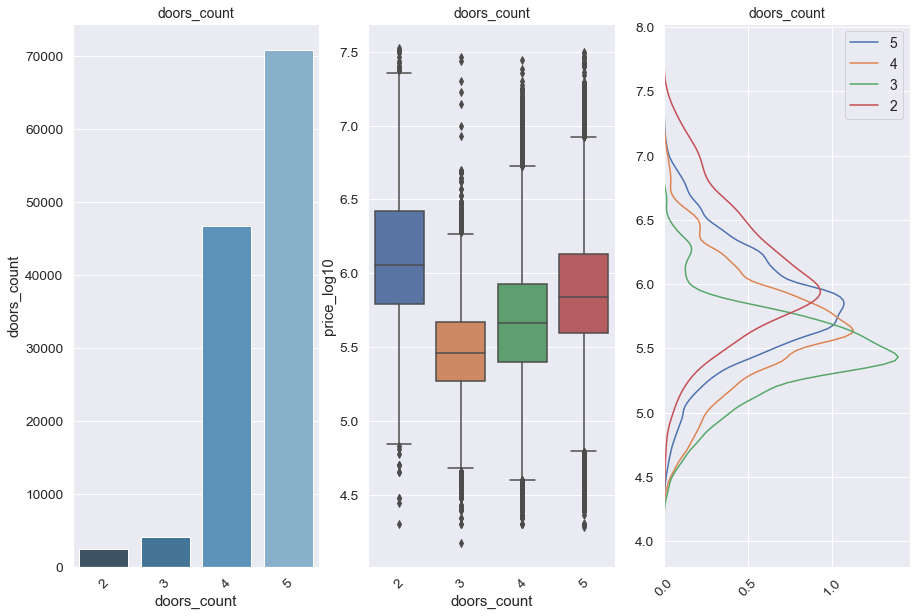

==== doors_count ====

Pearson correlation coefficient between 'doors_count' and 'price_log10' is 0.1405. 

doors_count
2     2464
3     4159
4    46750
5    70917
Name: doors_count, dtype: int64 

There are 0 missing values in 'doors_count'. 




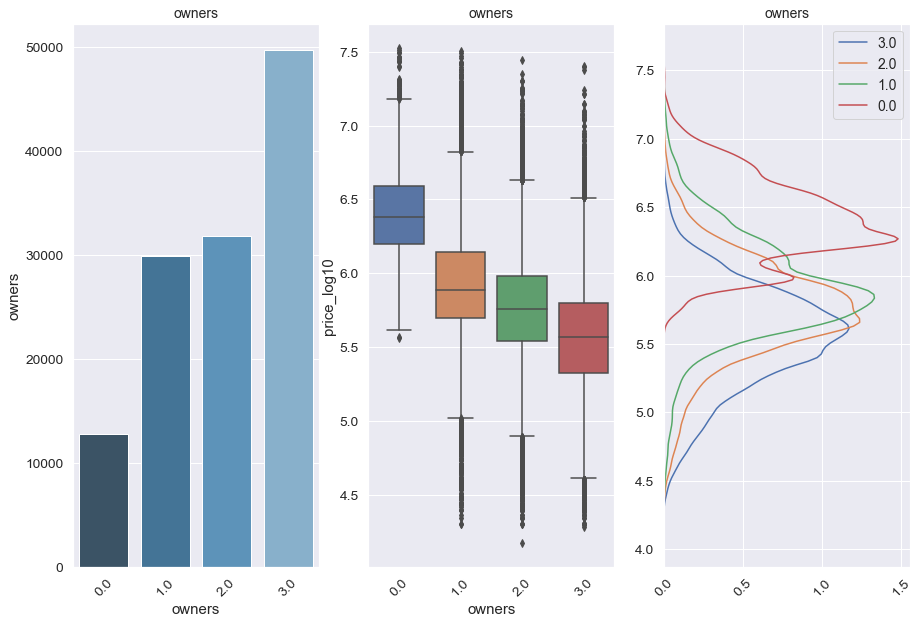

==== owners ====

Pearson correlation coefficient between 'owners' and 'price_log10' is -0.5453. 

owners
0.0    12797
1.0    29920
2.0    31817
3.0    49756
Name: owners, dtype: int64 

There are 0 missing values in 'owners'. 




In [46]:
for item in features_ordinal:
    ordinal_variable_analysis(data, item, target_name)

Вопиющих аномалий не видно.

### 3.2.2 Категориальные 'one-hot' признаки

In [47]:
features_one_hot

['gear_type',
 'navigation',
 'mark',
 'model',
 'esp',
 'steering_wheel',
 'knee-airbag',
 'price',
 'projection-display',
 'adaptive-light',
 'lane-keeping-assist',
 'multizone-climate-control',
 'advanced-frontlighting-system',
 'airbag-curtain',
 'halogen',
 'climate-control-1',
 'laser-lights',
 'cruise-control',
 'drowsy-driver-alert-system',
 'airbag-driver',
 'led-lights',
 'parktronik',
 'xenon',
 'airbag-4',
 'front-camera',
 'automatic-lighting-control',
 'collision-prevention-assist',
 'climate-control-3',
 'activ-suspension',
 'body_type',
 'abs',
 'auto-cruise',
 'night-vision',
 'transmission',
 'condition',
 'decorative-interior-lighting',
 'park-assist-r',
 'park-assist-f',
 'airbag-6',
 'rear-camera',
 'sport-suspension',
 'color',
 'climate-control-2',
 'climate-control',
 'asr',
 'auto-park',
 'air-suspension',
 'airbag-side',
 'computer',
 'section',
 'vsm',
 'airbag-passenger',
 'engine_type',
 'airbag-rear-side',
 'airbag-2',
 'airbag-1']

Вновь выведем количество уникальных значений для 'one-hot' переменных.

In [48]:
one_hot_unique = data[features_one_hot].nunique().sort_values(ascending=False)
one_hot_unique

price                            10653
model                             1391
mark                               118
color                               16
body_type                           16
engine_type                          4
transmission                         4
gear_type                            3
airbag-driver                        2
cruise-control                       2
drowsy-driver-alert-system           2
parktronik                           2
led-lights                           2
climate-control-1                    2
xenon                                2
airbag-4                             2
laser-lights                         2
advanced-frontlighting-system        2
halogen                              2
airbag-curtain                       2
automatic-lighting-control           2
multizone-climate-control            2
lane-keeping-assist                  2
adaptive-light                       2
projection-display                   2
knee-airbag              

Поскольку у двух признаков `model` и `mark` очень много категорий (1317 и 108, соответственно), их подвергать "классическому анализу".

Опустим сейчас и анализ доп.оборудования.

In [49]:
equipment_active_safety = ['abs', 'activ-suspension', 'air-suspension', 
                           'asr', 'collision-prevention-assist', 'esp', 
                           'lane-keeping-assist', 'park-assist-f', 'park-assist-r',
                           'sport-suspension', 'vsm']

equipment_climatic = ['climate-control', 'climate-control-1', 'climate-control-2',
                      'climate-control-3', 'condition', 'multizone-climate-control']

equipment_electronic_assistance = ['auto-cruise', 'auto-park', 'computer',
                                   'cruise-control', 'drowsy-driver-alert-system', 'front-camera',
                                   'navigation', 'night-vision', 'parktronik', 
                                   'projection-display', 'rear-camera']

equipment_light = ['adaptive-light', 'automatic-lighting-control', 'advanced-frontlighting-system', 
                   'decorative-interior-lighting', 'halogen', 'laser-lights', 
                   'led-lights', 'xenon']

equipment_passive_safety = ['airbag-1', 'airbag-2', 'airbag-4', 
                            'airbag-6', 'airbag-curtain', 'airbag-driver',
                            'airbag-passenger', 'airbag-rear-side', 'airbag-side', 
                            'knee-airbag']


equipment = (equipment_active_safety + equipment_climatic + equipment_electronic_assistance 
             + equipment_light + equipment_passive_safety)

# equipment

In [50]:
if target_name == 'price_log10':
    features_one_hot_short = list(set(features_one_hot) - set( ['model', 'mark', 'price'] + equipment ))
else:
    features_one_hot_short = list(set(features_one_hot) - set( ['model', 'mark'] + equipment ))
        
features_one_hot_short

['gear_type',
 'section',
 'steering_wheel',
 'color',
 'engine_type',
 'body_type',
 'transmission']

In [51]:
print( "Всего {} признаков, описывающих доп.оборудование.".format(len(equipment)) )

Всего 46 признаков, описывающих доп.оборудование.


In [52]:
# data['color'].value_counts(ascending=False)

Преобразуем 16-ричную кодировку цвета в названия.

In [53]:
## https://hysy.org/color/97948F
## https://www.colorhexa.com/0000cc

color_dict = {}

color_dict['040001'] = 'black'  ## в ПТС как чёрный (#601)
color_dict['FAFBFB'] = 'white'
color_dict['CACECB'] = 'light-grey'
color_dict['97948F'] = 'grey'
color_dict['0000CC'] = 'strong-blue'

color_dict['200204'] = 'mostly-black-red'  ## в ПТС как коричневый металлик (#798)
color_dict['EE1D19'] = 'Vivid red'
color_dict['007F00'] = 'dark-green'
color_dict['C49648'] = 'french-beige'
color_dict['22A0F8'] = 'vivid-blue'  ## лазурный

color_dict['FFD600'] = 'yellow'
color_dict['660099'] = 'dark-violet'
color_dict['4A2197'] = 'dark-blue'
color_dict['DEA522'] = 'golden'
color_dict['FF8649'] = 'peach'
color_dict['FFC0CB'] = 'pink'

data['color'] = data['color'].map(color_dict)
data

body_type  doors_count        mark       model engine_type  \
0       COMPACTVAN            4      Nissan      Serena      DIESEL   
1          ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   
2        HATCHBACK            5  Volkswagen        Polo    GASOLINE   
3        HATCHBACK            3  LADA (ВАЗ)    1111 Ока    GASOLINE   
4        HATCHBACK            5  Volkswagen        Golf    GASOLINE   
...            ...          ...         ...         ...         ...   
124285     ALLROAD            5         УАЗ     Patriot    GASOLINE   
124286     ALLROAD            5   Chevrolet        Niva    GASOLINE   
124287     ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
124288     ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
124289     ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  ...  \
0               1973     91    AUTOMATIC  ALL_WHEEL_DRIVE          RIGHT  ...   
1               1690     83   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  ...   
2               1598     75    AUTOMATIC  FORWARD_CONTROL           LEFT  ...   
3                649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
4               2324    150   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
...              ...    ...          ...              ...            ...  ...   
124285          2693    135   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  ...   
124286          1690     80   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  ...   
124287          1998    146     VARIATOR  ALL_WHEEL_DRIVE           LEFT  ...   
124288          2360    167     VARIATOR  ALL_WHEEL_DRIVE           LEFT  ...   
124289          1690     83   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  ...   

       airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
0             0         0         0              0              1   
1             0         0         0              0              0   
2             0         0         0              0              1   
3             0         0         0              0              0   
4             0         0         0              0              0   
...         ...       ...       ...            ...            ...   
124285        0         0         0              0              1   
124286        0         0         0              0              1   
124287        0         0         0              1              1   
124288        0         0         0              0              0   
124289        0         0         0              0              0   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
0                      1                 0            0            0   
1                      0                 0            0            0   
2                      1                 0            1            0   
3                      0                 0            0            0   
4                      0                 0            0            0   
...                  ...               ...          ...          ...   
124285                 1                 0            0            0   
124286                 1                 0            0            0   
124287                 1                 0            1            1   
124288                 0                 0            0            0   
124289                 0                 0            0            0   

        price_log10  
0          5.290035  
1          5.469822  
2          5.227887  
3          4.414973  
4          5.161368  
...             ...  
124285     5.929419  
124286     5.755112  
124287     6.217484  
124288     6.267172  
124289     5.707570  

[124290 rows x 63 columns]

In [54]:
def rounder(x, m=2):
    return round(x, m)

def one_hot_variable_analysis(df, item, target_name, n_bins=100, class_balance_threshold=3):
    if item != target_name:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    
    # ==== FIG 1 (barplot)
    bar_data = df.groupby(item)[item].count().sort_values(ascending=False)
    br_plot = sns.barplot(x=bar_data.index, y=bar_data, ax = axes[0])#, palette="Blues_d")
    br_plot.set_xticklabels(bar_data.index, rotation=90)
    axes[0].set_title(item, fontsize=FONT_SIZE)
    
    # ==== FIG 2 (boxplot)
    bx_plot = sns.boxplot(x=item, y=target_name, data=df, ax=axes[1])
    bx_plot.set_xticklabels(bar_data.index, rotation=90)
    axes[1].set_title(item, fontsize=FONT_SIZE)

    
    # ==== FIG 3 (distplot)
    values = df[item].value_counts()
    
    for value in values.index:
        sns.distplot(df[ df[item] == value ][target_name], bins=n_bins, kde=True, norm_hist=True, 
                     vertical=True, ax=axes[2], label=value)
    
    axes[2].set_title(item, fontsize=FONT_SIZE)
    axes[2].legend(fontsize=FONT_SIZE)
    
    plt.show()
    
    # === Descriptive statistics    
    
    print("==== {} ====\n".format(item))
    
    
    print(bar_data, "\n")
    
    
    values = df[item].value_counts()
    k = 0
    for value in values.index:
        describer_value = pd.DataFrame(df[ df[item] == value ][target_name].describe())
#         ! print("!!!\n", values, "\n")
        if k == 0:
            describer = describer_value.copy()
        else:
            describer = pd.concat([describer, describer_value], axis=1)
        k += 1    
    describer.columns = values.index
    describer = describer.T
    describer_moments = pd.DataFrame([describer.mean(), describer.std()], index=['MEAN', 'STD'])
    describer = pd.concat([describer, describer_moments], axis=0)
    describer = describer.apply(rounder)
    print(describer, "\n")
    
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), '\n'*2)
    
#     if class_balance_threshold > 0:
#         print("Class balance ratio (to previous):")
#         bar_data_sorted = bar_data.sort_values()
#         class_balance_ratio = round(np.exp(np.log(bar_data_sorted).diff()), 2)
#         print(class_balance_ratio, "\n")    
#         if class_balance_ratio.max() > class_balance_threshold:
#             print("It seems to be a severe CLASS IMBALANCE: Maximal Class balance ratio (to previous) is", 
#                   class_balance_ratio.max(), "\n")
#         else:
#             print("Maximal Class balance ratio (to previous) is ", class_balance_ratio.max(), "\n")
#         return class_balance_ratio.max()

In [55]:
features_one_hot_short

['gear_type',
 'section',
 'steering_wheel',
 'color',
 'engine_type',
 'body_type',
 'transmission']

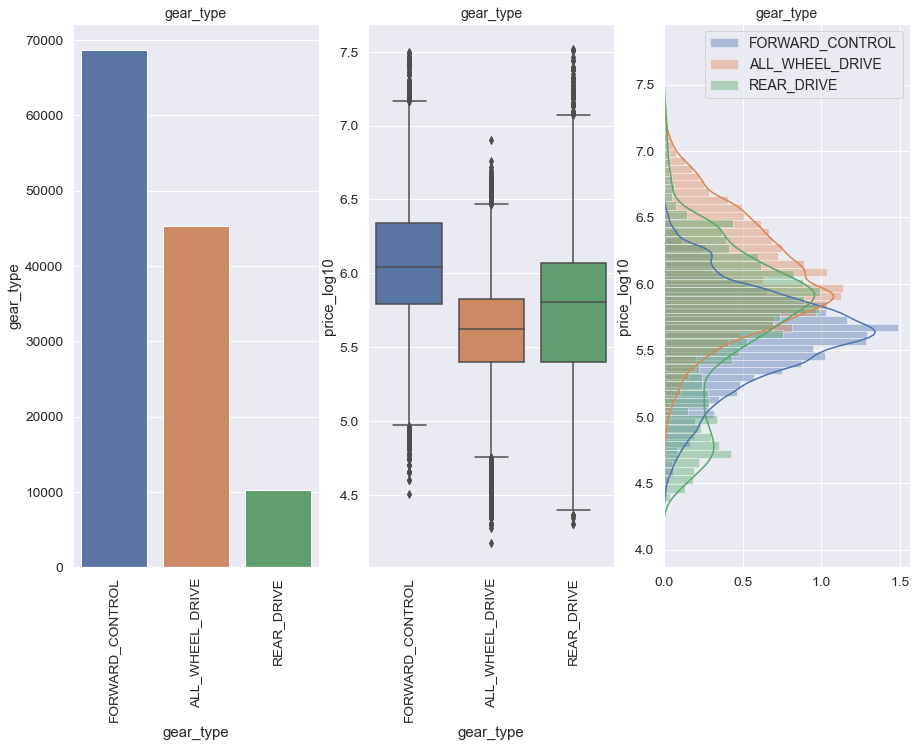

==== gear_type ====

gear_type
FORWARD_CONTROL    68703
ALL_WHEEL_DRIVE    45294
REAR_DRIVE         10293
Name: gear_type, dtype: int64 

                    count  mean   std   min   25%   50%   75%   max
FORWARD_CONTROL  68703.00  5.60  0.36  4.18  5.40  5.62  5.83  6.90
ALL_WHEEL_DRIVE  45294.00  6.06  0.41  4.51  5.79  6.04  6.34  7.50
REAR_DRIVE       10293.00  5.70  0.55  4.30  5.40  5.81  6.07  7.52
MEAN             41430.00  5.79  0.44  4.33  5.53  5.82  6.08  7.31
STD              29396.09  0.24  0.10  0.17  0.23  0.21  0.26  0.35 

There are 0 missing values in 'gear_type'. 




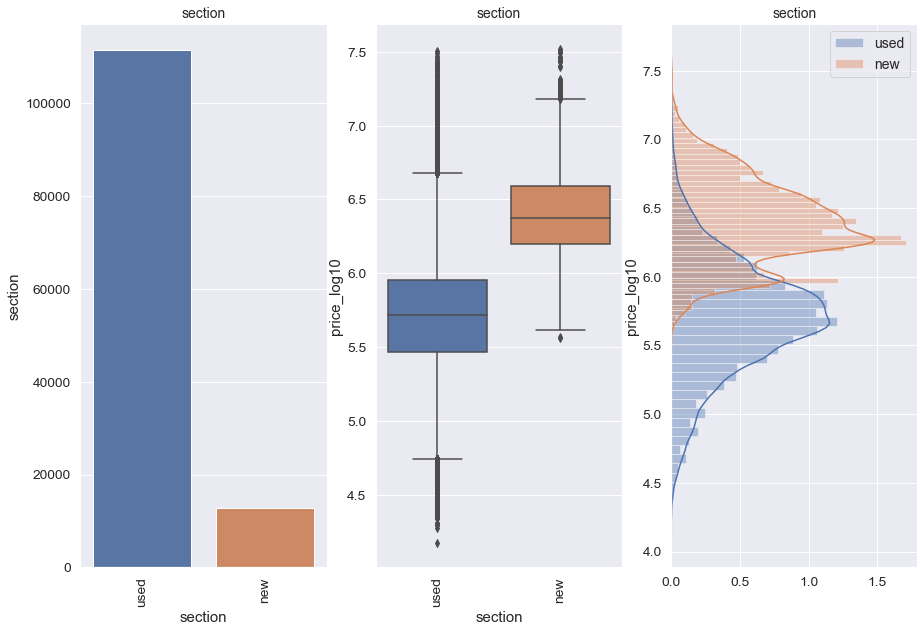

==== section ====

section
used    111493
new      12797
Name: section, dtype: int64 

          count  mean   std   min   25%   50%   75%   max
used  111493.00  5.71  0.41  4.18  5.47  5.72  5.95  7.51
new    12797.00  6.39  0.30  5.56  6.20  6.38  6.59  7.52
MEAN   62145.00  6.05  0.36  4.87  5.84  6.05  6.27  7.51
STD    69788.61  0.49  0.08  0.98  0.52  0.47  0.45  0.01 

There are 0 missing values in 'section'. 




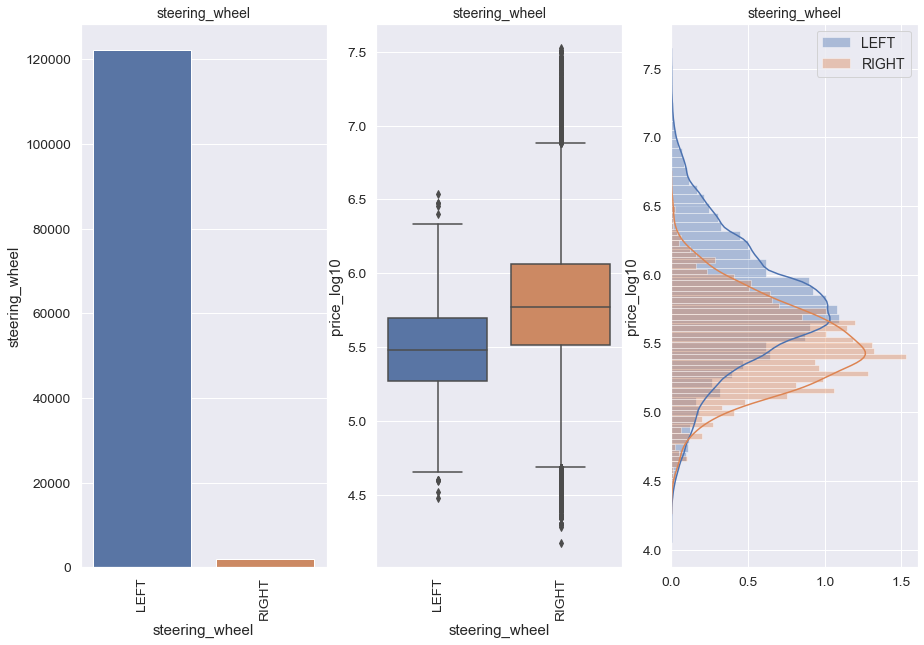

==== steering_wheel ====

steering_wheel
LEFT     122322
RIGHT      1968
Name: steering_wheel, dtype: int64 

           count  mean   std   min   25%   50%   75%   max
LEFT   122322.00  5.78  0.45  4.18  5.51  5.77  6.06  7.52
RIGHT    1968.00  5.48  0.31  4.48  5.27  5.48  5.70  6.54
MEAN    62145.00  5.63  0.38  4.33  5.39  5.62  5.88  7.03
STD     85103.13  0.21  0.10  0.21  0.17  0.21  0.26  0.70 

There are 0 missing values in 'steering_wheel'. 




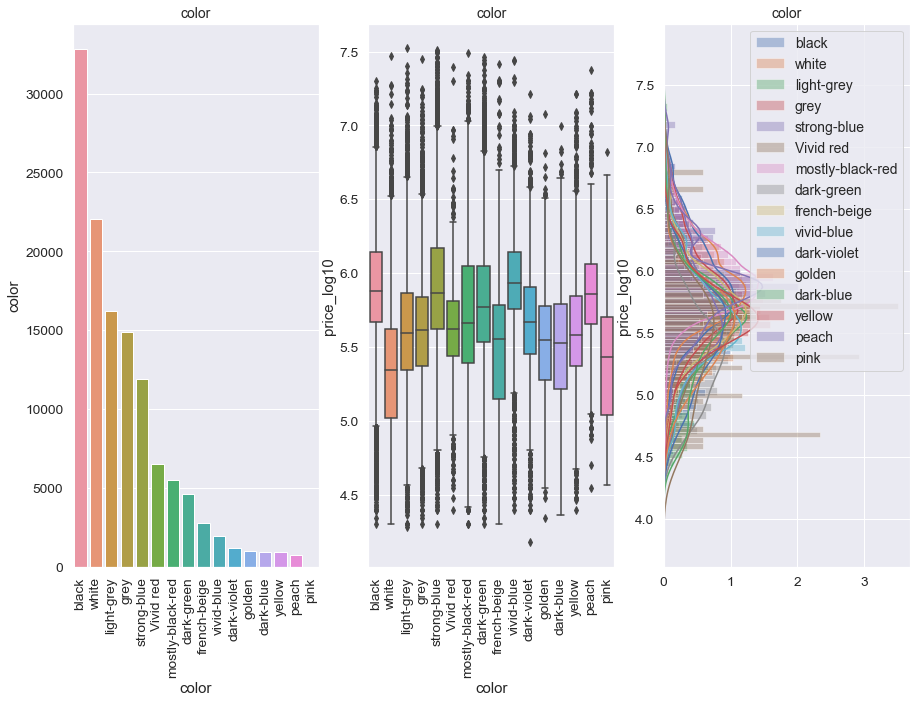

==== color ====

color
black               32790
white               22081
light-grey          16221
grey                14868
strong-blue         11948
Vivid red            6524
mostly-black-red     5534
dark-green           4625
french-beige         2780
vivid-blue           1946
dark-violet          1188
golden               1053
dark-blue             985
yellow                951
peach                 758
pink                   38
Name: color, dtype: int64 

                     count  mean   std   min   25%   50%   75%   max
black             32790.00  5.90  0.43  4.30  5.62  5.86  6.17  7.51
white             22081.00  5.90  0.39  4.30  5.67  5.88  6.15  7.30
light-grey        16221.00  5.60  0.38  4.30  5.37  5.61  5.84  7.45
grey              14868.00  5.80  0.45  4.30  5.53  5.77  6.05  7.47
strong-blue       11948.00  5.71  0.51  4.30  5.39  5.66  6.05  7.49
Vivid red          6524.00  5.61  0.46  4.28  5.34  5.60  5.87  7.52
mostly-black-red   5534.00  5.96  0.33  4.40  5.76

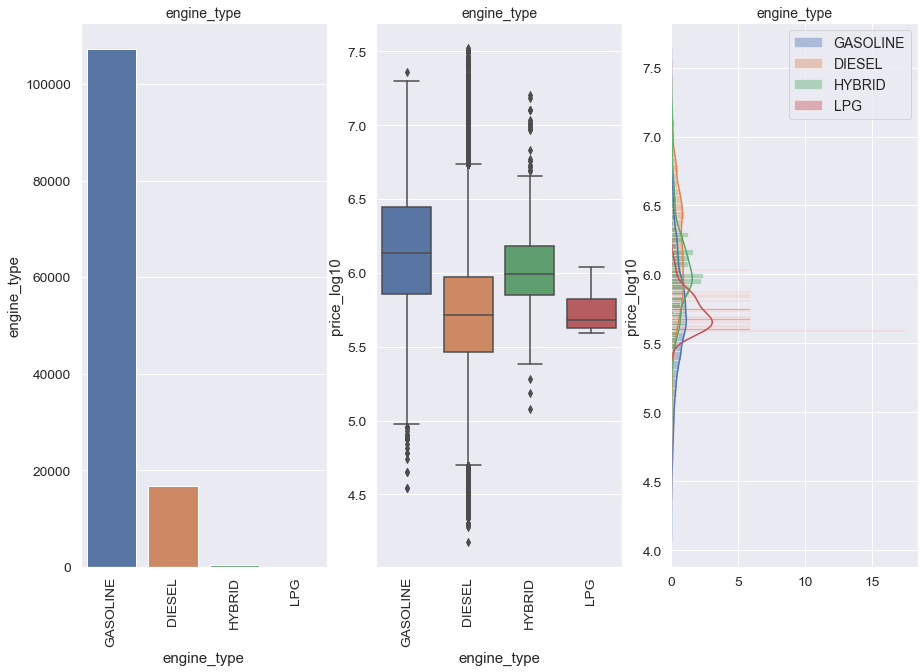

==== engine_type ====

engine_type
GASOLINE    107178
DIESEL       16718
HYBRID         375
LPG             19
Name: engine_type, dtype: int64 

              count  mean   std   min   25%   50%   75%   max
GASOLINE  107178.00  5.72  0.43  4.18  5.46  5.72  5.97  7.52
DIESEL     16718.00  6.15  0.40  4.54  5.85  6.13  6.45  7.36
HYBRID       375.00  6.04  0.34  5.08  5.85  6.00  6.18  7.20
LPG           19.00  5.72  0.12  5.59  5.63  5.68  5.82  6.04
MEAN       31072.50  5.91  0.32  4.85  5.70  5.88  6.11  7.03
STD        51331.46  0.22  0.14  0.62  0.19  0.22  0.27  0.67 

There are 0 missing values in 'engine_type'. 




C:\Users\DNS\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


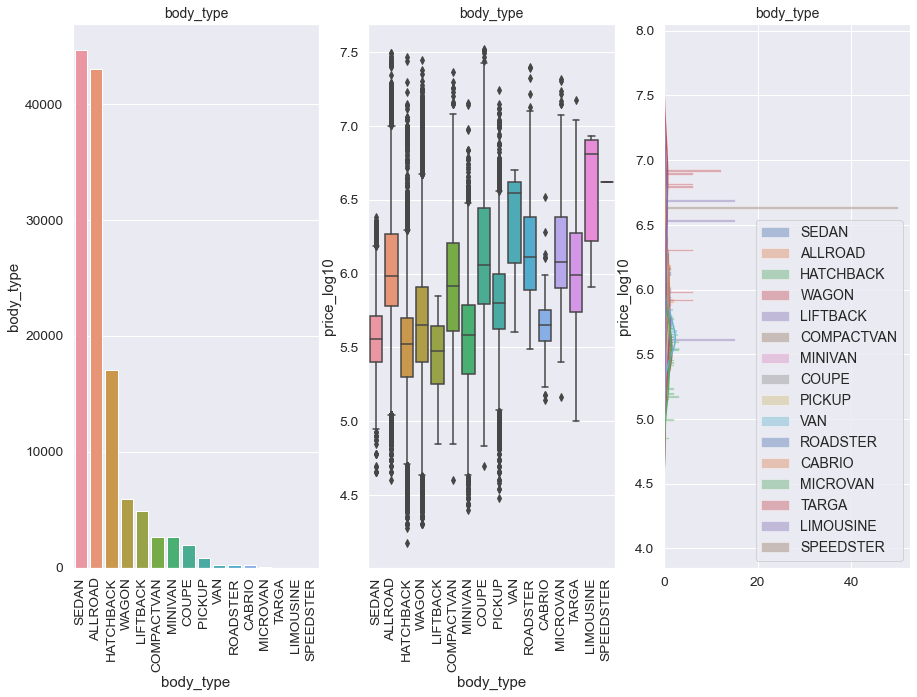

==== body_type ====

body_type
SEDAN         44662
ALLROAD       43009
HATCHBACK     17019
WAGON          5916
LIFTBACK       4897
COMPACTVAN     2635
MINIVAN        2622
COUPE          1959
PICKUP          834
VAN             268
ROADSTER        209
CABRIO          201
MICROVAN         47
TARGA             8
LIMOUSINE         3
SPEEDSTER         1
Name: body_type, dtype: int64 

               count  mean   std   min   25%   50%   75%   max
SEDAN       44662.00  5.65  0.45  4.30  5.40  5.65  5.91  7.45
ALLROAD     43009.00  6.03  0.37  4.60  5.78  5.99  6.27  7.50
HATCHBACK   17019.00  5.49  0.36  4.18  5.30  5.53  5.70  7.47
WAGON        5916.00  5.55  0.37  4.40  5.32  5.59  5.79  7.16
LIFTBACK     4897.00  5.79  0.36  4.48  5.62  5.80  6.00  7.24
COMPACTVAN   2635.00  5.58  0.27  4.65  5.40  5.56  5.72  6.38
MINIVAN      2622.00  5.93  0.41  4.60  5.61  5.92  6.20  7.36
COUPE        1959.00  6.12  0.50  4.70  5.79  6.06  6.45  7.52
PICKUP        834.00  6.01  0.36  5.00  5.74  5.99

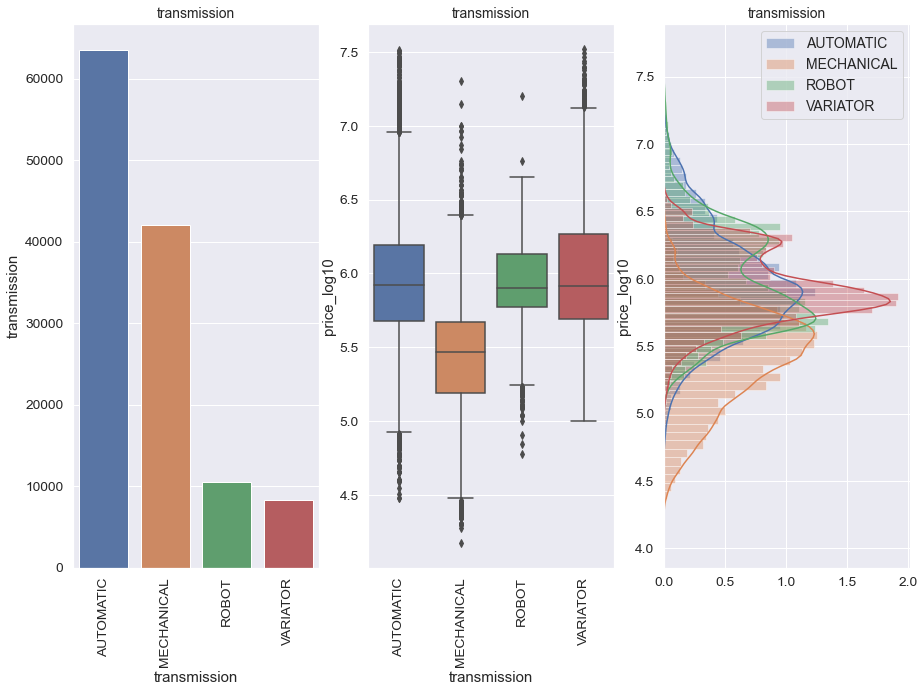

==== transmission ====

transmission
AUTOMATIC     63519
MECHANICAL    42048
ROBOT         10482
VARIATOR       8241
Name: transmission, dtype: int64 

               count  mean   std   min   25%   50%   75%   max
AUTOMATIC   63519.00  5.96  0.40  4.48  5.68  5.92  6.19  7.51
MECHANICAL  42048.00  5.42  0.36  4.18  5.19  5.47  5.67  7.30
ROBOT       10482.00  5.98  0.37  5.00  5.69  5.91  6.27  7.52
VARIATOR     8241.00  5.94  0.26  4.78  5.77  5.90  6.13  7.20
MEAN        31072.50  5.82  0.35  4.61  5.58  5.80  6.07  7.38
STD         26573.69  0.27  0.06  0.36  0.27  0.22  0.27  0.16 

There are 0 missing values in 'transmission'. 




In [56]:
for item in features_one_hot_short:
    one_hot_variable_analysis(data, item, target_name, n_bins=50)

Странности:
1. `body_type` - три типа кузова с очень малым числом машин:
 - TARGA            - 8 
 - LIMOUSINE        - 3 
 - SPEEDSTER        - 1 

2. `engine_type` - Всего 19 машин с двигателем на газу. Они погоду не сделают - удалим.
 - LPG            - 19

In [57]:
data['body_type'].value_counts()

SEDAN         44662
ALLROAD       43009
HATCHBACK     17019
WAGON          5916
LIFTBACK       4897
COMPACTVAN     2635
MINIVAN        2622
COUPE          1959
PICKUP          834
VAN             268
ROADSTER        209
CABRIO          201
MICROVAN         47
TARGA             8
LIMOUSINE         3
SPEEDSTER         1
Name: body_type, dtype: int64

In [58]:
data[ data['body_type']=='TARGA' ]

body_type  doors_count     mark model engine_type  displacement  power  \
13980     TARGA            2  Porsche   911    GASOLINE          3436    350   
14389     TARGA            2  Porsche   911    GASOLINE          3800    430   
14652     TARGA            2  Porsche   911    GASOLINE          3800    400   
19619     TARGA            2  Porsche   911    GASOLINE          3596    320   
31237     TARGA            2   Toyota   MR2    GASOLINE          1998    170   
32159     TARGA            2   Toyota   MR2    GASOLINE          1998    170   
71910     TARGA            2  Porsche   911    GASOLINE          2981    370   
72455     TARGA            2  Porsche   911    GASOLINE          2981    370   

      transmission        gear_type steering_wheel  ... airbag-2  airbag-4  \
13980        ROBOT  ALL_WHEEL_DRIVE           LEFT  ...        0         0   
14389        ROBOT  ALL_WHEEL_DRIVE           LEFT  ...        0         0   
14652        ROBOT  ALL_WHEEL_DRIVE           LEFT  ...        0         0   
19619   MECHANICAL       REAR_DRIVE           LEFT  ...        0         0   
31237   MECHANICAL       REAR_DRIVE           LEFT  ...        0         0   
32159   MECHANICAL       REAR_DRIVE          RIGHT  ...        0         0   
71910        ROBOT  ALL_WHEEL_DRIVE           LEFT  ...        0         0   
72455        ROBOT  ALL_WHEEL_DRIVE           LEFT  ...        0         0   

       airbag-6 airbag-curtain  airbag-driver  airbag-passenger  \
13980         0              1              1                 1   
14389         0              0              0                 0   
14652         0              1              1                 1   
19619         0              0              1                 1   
31237         0              0              0                 0   
32159         0              0              0                 0   
71910         0              0              0                 0   
72455         0              1              1                 1   

       airbag-rear-side  airbag-side  knee-airbag  price_log10  
13980                 1            1            0     6.792392  
14389                 0            0            0     6.919078  
14652                 0            1            0     6.822822  
19619                 0            0            0     6.301030  
31237                 0            0            0     5.980003  
32159                 0            0            0     5.909741  
71910                 0            0            0     6.903090  
72455                 0            1            0     6.929419  

[8 rows x 63 columns]

In [59]:
data[ data['body_type']=='LIMOUSINE' ]

body_type  doors_count           mark    model engine_type  \
73     LIMOUSINE            4  Mercedes-Benz  S-Класс    GASOLINE   
20722  LIMOUSINE            4  Mercedes-Benz  S-Класс    GASOLINE   
87152  LIMOUSINE            4  Mercedes-Benz  S-Класс    GASOLINE   

       displacement  power transmission   gear_type steering_wheel  ...  \
73             5987    394    AUTOMATIC  REAR_DRIVE           LEFT  ...   
20722          5513    500    AUTOMATIC  REAR_DRIVE           LEFT  ...   
87152          4966    306    AUTOMATIC  REAR_DRIVE           LEFT  ...   

      airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
73           0         0         0              0              0   
20722        0         0         0              0              0   
87152        0         0         0              0              0   

       airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
73                    0                 0            0            0   
20722                 0                 0            0            0   
87152                 0                 0            0            0   

       price_log10  
73        6.544068  
20722     6.698970  
87152     5.602060  

[3 rows x 63 columns]

In [60]:
data[ (data['mark']=='Mercedes-Benz') & (data['model']=='S-Класс') ]['body_type'].value_counts()

SEDAN        796
COUPE         36
LIMOUSINE      3
CABRIO         1
Name: body_type, dtype: int64

In [61]:
data[ data['body_type']=='SPEEDSTER' ]

body_type  doors_count     mark model engine_type  displacement  \
117184  SPEEDSTER            2  Ferrari   360    GASOLINE          3586   

        power transmission   gear_type steering_wheel  ... airbag-2  airbag-4  \
117184    400        ROBOT  REAR_DRIVE           LEFT  ...        0         0   

        airbag-6 airbag-curtain  airbag-driver  airbag-passenger  \
117184         0              0              0                 0   

        airbag-rear-side  airbag-side  knee-airbag  price_log10  
117184                 0            0            0     6.623249  

[1 rows x 63 columns]

Лимузинами ошибочно классифицированы Mercedes-Benz S-Класса, которые суть седаны. Все Mercedes-Benz S-Класса сделаем седанами.

Основываясь на статье в вики "[Car body style]" (https://en.wikipedia.org/wiki/Car_body_style) укрупним категории кузова в соответсвии с таблицей (невошедшие - без изменений):

| было | стало |
| :-- | :-- |
| WAGON          | VAN |
| LIFTBACK       | HATCHBACK |
| MINIVAN        | VAN |
| COMPACTVAN     | VAN |
| MICROVAN       | VAN |
| TARGA          | CABRIO |
| LIMOUSINE      | SEDAN |
| SPEEDSTER      | COUPE  |

In [62]:
dict_body = {}

dict_body['ALLROAD'] = 'ALLROAD'
dict_body['SEDAN'] = 'SEDAN'
dict_body['HATCHBACK'] = 'HATCHBACK'

dict_body['WAGON'] = 'VAN'
dict_body['LIFTBACK'] = 'HATCHBACK'
dict_body['MINIVAN'] = 'VAN'
dict_body['COMPACTVAN'] = 'VAN'

dict_body['COUPE'] = 'COUPE'
dict_body['PICKUP'] = 'PICKUP'
dict_body['VAN'] = 'VAN'
dict_body['ROADSTER'] = 'ROADSTER'
dict_body['CABRIO'] = 'CABRIO'

dict_body['MICROVAN'] = 'VAN'
dict_body['TARGA'] = 'CABRIO'
dict_body['LIMOUSINE'] = 'SEDAN'
dict_body['SPEEDSTER'] = 'COUPE'

data['body_type'] = data['body_type'].map(dict_body)
data['body_type'].value_counts()

SEDAN        44665
ALLROAD      43009
HATCHBACK    21916
VAN          11488
COUPE         1960
PICKUP         834
CABRIO         209
ROADSTER       209
Name: body_type, dtype: int64

In [63]:
mercedes_s_index = data[ (data['mark']=='Mercedes-Benz') & (data['model']=='S-Класс') ].index
data.loc[mercedes_s_index, 'body_type'] = 'SEDAN'

data[ (data['mark']=='Mercedes-Benz') & (data['model']=='S-Класс') ]['body_type'].value_counts()

SEDAN    836
Name: body_type, dtype: int64

In [64]:
data = data[ data['engine_type'] != 'LPG' ]
data['engine_type'].value_counts()

GASOLINE    107178
DIESEL       16718
HYBRID         375
Name: engine_type, dtype: int64

После "первичной очистки" снова глянем на категориальные one_hot признаки:

In [65]:
features_one_hot_short

['gear_type',
 'section',
 'steering_wheel',
 'color',
 'engine_type',
 'body_type',
 'transmission']

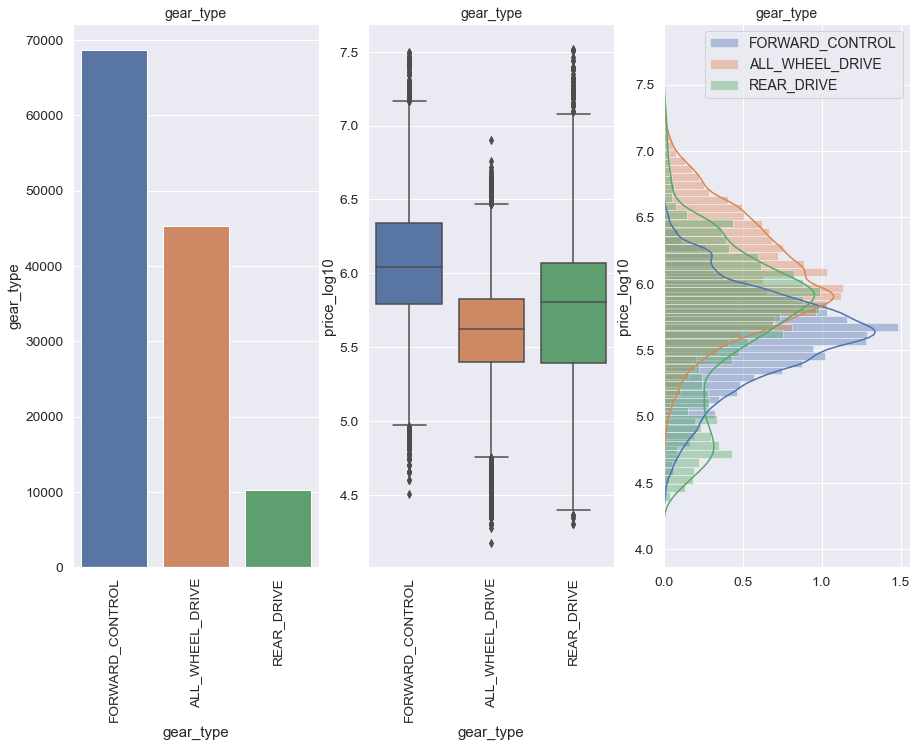

==== gear_type ====

gear_type
FORWARD_CONTROL    68686
ALL_WHEEL_DRIVE    45294
REAR_DRIVE         10291
Name: gear_type, dtype: int64 

                    count  mean   std   min   25%   50%   75%   max
FORWARD_CONTROL  68686.00  5.60  0.36  4.18  5.40  5.62  5.83  6.90
ALL_WHEEL_DRIVE  45294.00  6.06  0.41  4.51  5.79  6.04  6.34  7.50
REAR_DRIVE       10291.00  5.70  0.55  4.30  5.39  5.81  6.07  7.52
MEAN             41423.67  5.79  0.44  4.33  5.53  5.82  6.08  7.31
STD              29389.26  0.24  0.10  0.17  0.23  0.21  0.26  0.35 

There are 0 missing values in 'gear_type'. 




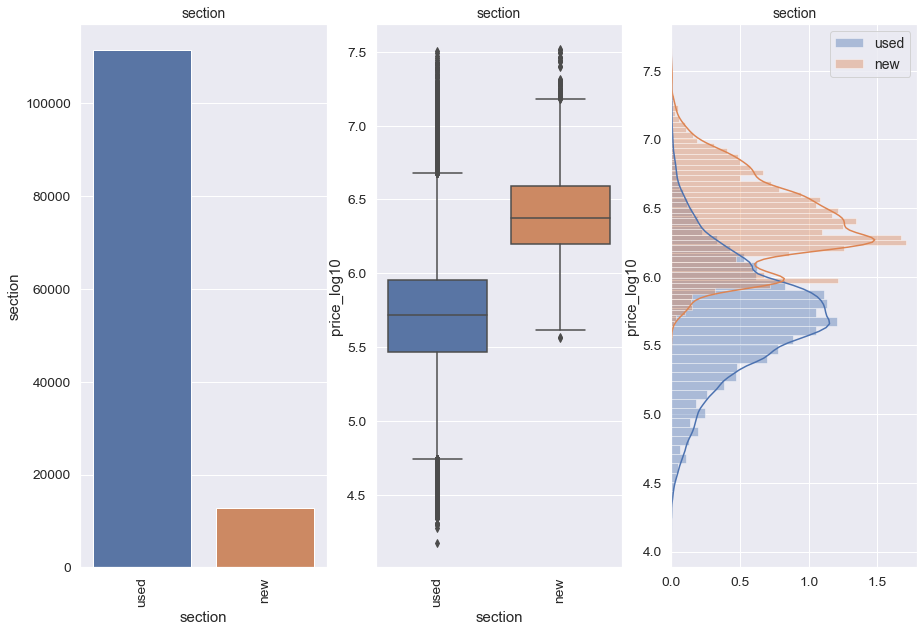

==== section ====

section
used    111475
new      12796
Name: section, dtype: int64 

          count  mean   std   min   25%   50%   75%   max
used  111475.00  5.71  0.41  4.18  5.47  5.72  5.95  7.51
new    12796.00  6.39  0.30  5.56  6.20  6.38  6.59  7.52
MEAN   62135.50  6.05  0.36  4.87  5.84  6.05  6.27  7.51
STD    69776.59  0.49  0.08  0.98  0.52  0.47  0.45  0.01 

There are 0 missing values in 'section'. 




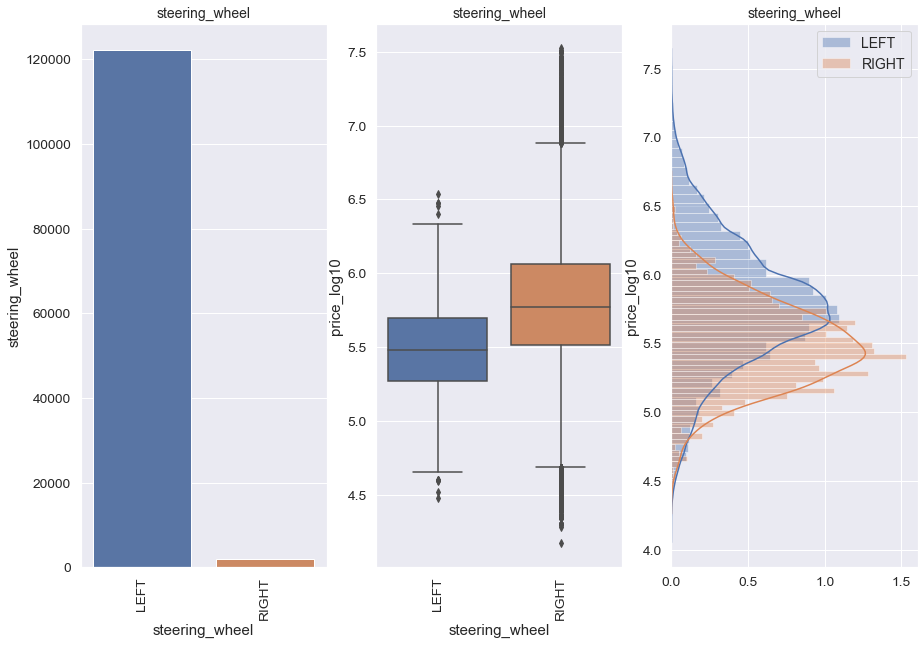

==== steering_wheel ====

steering_wheel
LEFT     122303
RIGHT      1968
Name: steering_wheel, dtype: int64 

           count  mean   std   min   25%   50%   75%   max
LEFT   122303.00  5.78  0.45  4.18  5.51  5.77  6.06  7.52
RIGHT    1968.00  5.48  0.31  4.48  5.27  5.48  5.70  6.54
MEAN    62135.50  5.63  0.38  4.33  5.39  5.62  5.88  7.03
STD     85089.69  0.21  0.10  0.21  0.17  0.21  0.26  0.70 

There are 0 missing values in 'steering_wheel'. 




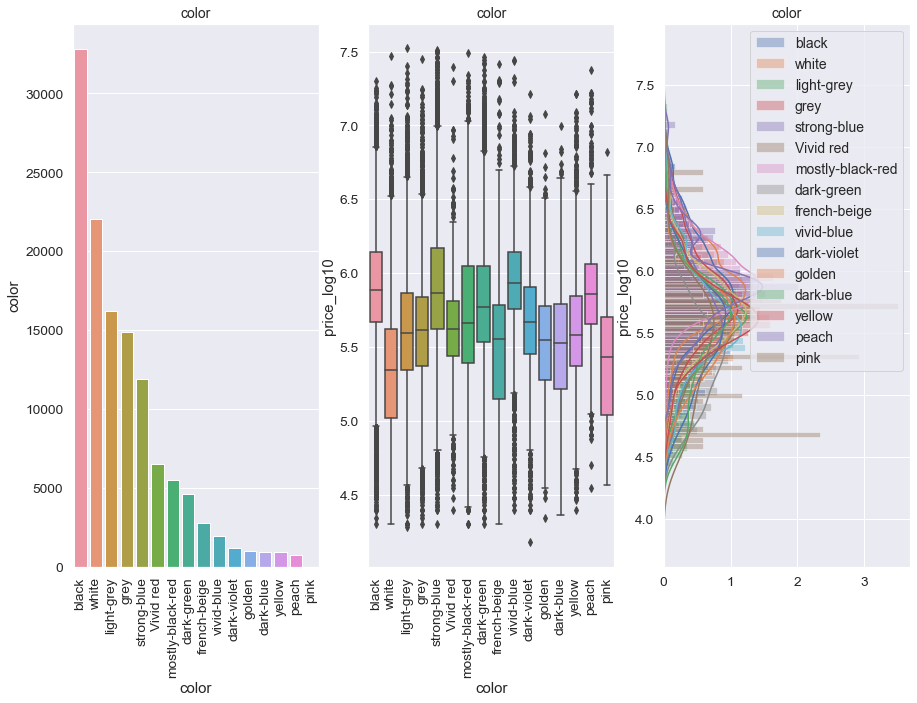

==== color ====

color
black               32787
white               22075
light-grey          16220
grey                14867
strong-blue         11945
Vivid red            6523
mostly-black-red     5533
dark-green           4624
french-beige         2780
vivid-blue           1944
dark-violet          1188
golden               1053
dark-blue             985
yellow                951
peach                 758
pink                   38
Name: color, dtype: int64 

                     count  mean   std   min   25%   50%   75%   max
black             32787.00  5.90  0.43  4.30  5.62  5.86  6.17  7.51
white             22075.00  5.90  0.39  4.30  5.67  5.88  6.15  7.30
light-grey        16220.00  5.60  0.38  4.30  5.37  5.61  5.84  7.45
grey              14867.00  5.80  0.45  4.30  5.53  5.77  6.05  7.47
strong-blue       11945.00  5.71  0.51  4.30  5.39  5.66  6.05  7.49
Vivid red          6523.00  5.61  0.46  4.28  5.34  5.60  5.87  7.52
mostly-black-red   5533.00  5.96  0.33  4.40  5.76

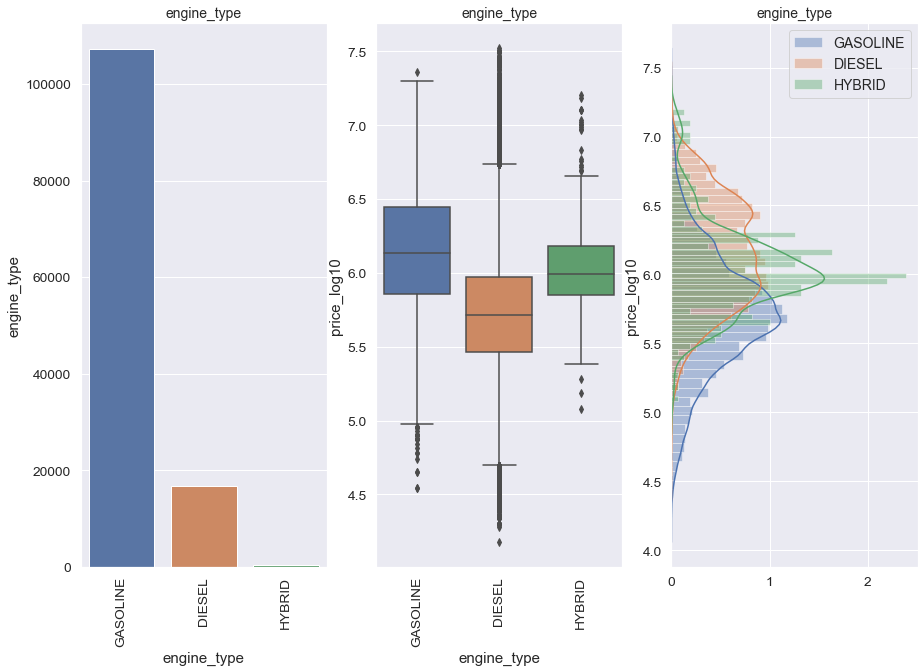

==== engine_type ====

engine_type
GASOLINE    107178
DIESEL       16718
HYBRID         375
Name: engine_type, dtype: int64 

              count  mean   std   min   25%   50%   75%   max
GASOLINE  107178.00  5.72  0.43  4.18  5.46  5.72  5.97  7.52
DIESEL     16718.00  6.15  0.40  4.54  5.85  6.13  6.45  7.36
HYBRID       375.00  6.04  0.34  5.08  5.85  6.00  6.18  7.20
MEAN       41423.67  5.97  0.39  4.60  5.72  5.95  6.20  7.36
STD        57528.23  0.22  0.05  0.45  0.22  0.21  0.24  0.16 

There are 0 missing values in 'engine_type'. 




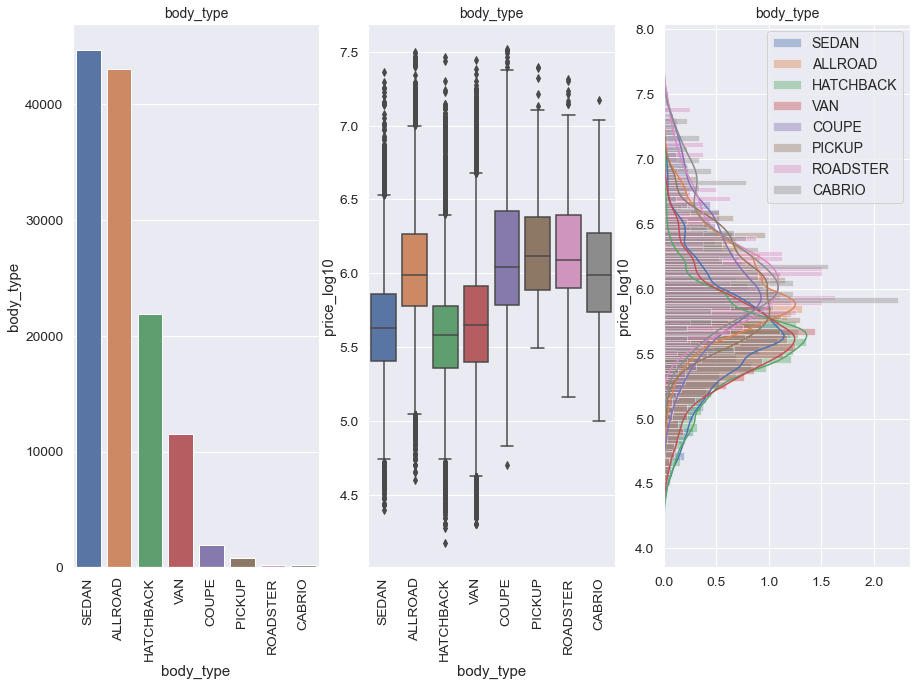

==== body_type ====

body_type
SEDAN        44696
ALLROAD      43009
HATCHBACK    21916
VAN          11475
COUPE         1924
PICKUP         834
ROADSTER       209
CABRIO         208
Name: body_type, dtype: int64 

              count  mean   std   min   25%   50%   75%   max
SEDAN      44696.00  5.65  0.45  4.30  5.40  5.65  5.91  7.45
ALLROAD    43009.00  6.03  0.37  4.60  5.78  5.99  6.27  7.50
HATCHBACK  21916.00  5.56  0.38  4.18  5.36  5.58  5.78  7.47
VAN        11475.00  5.64  0.39  4.40  5.41  5.63  5.86  7.36
COUPE       1924.00  6.11  0.49  4.70  5.79  6.04  6.42  7.52
PICKUP       834.00  6.01  0.36  5.00  5.74  5.99  6.27  7.18
ROADSTER     209.00  6.17  0.39  5.49  5.89  6.11  6.38  7.40
CABRIO       208.00  6.18  0.43  5.16  5.90  6.09  6.40  7.32
MEAN       15533.88  5.92  0.41  4.73  5.66  5.88  6.16  7.40
STD        19024.67  0.26  0.04  0.46  0.23  0.22  0.27  0.11 

There are 0 missing values in 'body_type'. 




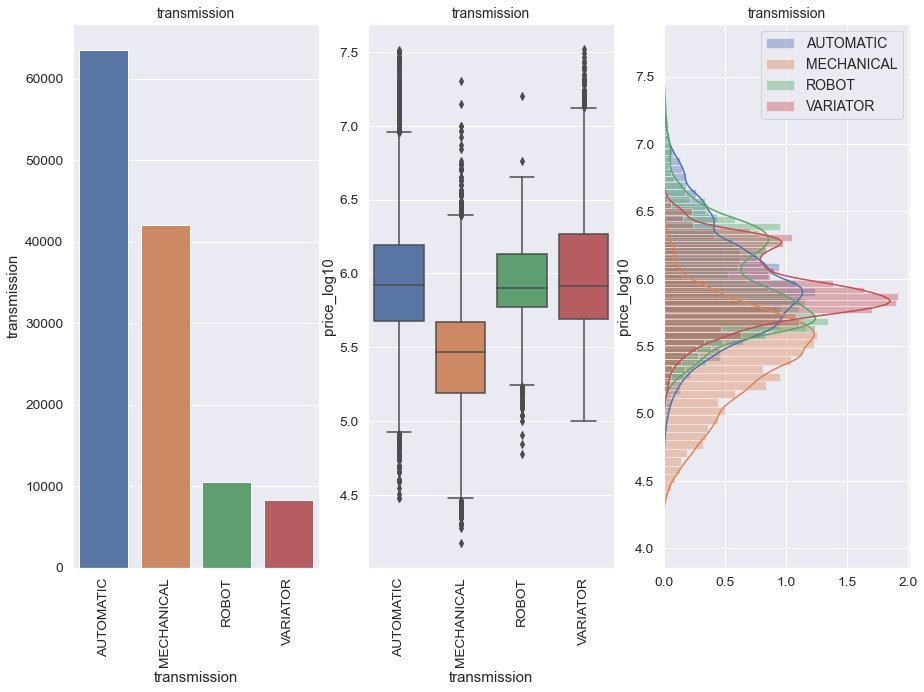

==== transmission ====

transmission
AUTOMATIC     63517
MECHANICAL    42042
ROBOT         10471
VARIATOR       8241
Name: transmission, dtype: int64 

               count  mean   std   min   25%   50%   75%   max
AUTOMATIC   63517.00  5.96  0.40  4.48  5.68  5.92  6.19  7.51
MECHANICAL  42042.00  5.42  0.36  4.18  5.19  5.47  5.67  7.30
ROBOT       10471.00  5.98  0.37  5.00  5.69  5.91  6.27  7.52
VARIATOR     8241.00  5.94  0.26  4.78  5.77  5.90  6.13  7.20
MEAN        31067.75  5.82  0.35  4.61  5.58  5.80  6.07  7.38
STD         26574.89  0.27  0.06  0.36  0.27  0.22  0.27  0.16 

There are 0 missing values in 'transmission'. 




In [66]:
for item in features_one_hot_short:
    one_hot_variable_analysis(data, item, target_name, n_bins=50)

Вопиющих аномалий не видно.

# 4 Преобразование данных

In [67]:
data = data.drop(['price_log10'], axis=1)

target_name = 'price'

## 4.1 Преобразование типа данных

In [68]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124271 entries, 0 to 124289
Data columns (total 62 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   body_type                      124271 non-null  object 
 1   doors_count                    124271 non-null  int64  
 2   mark                           124271 non-null  object 
 3   model                          124271 non-null  object 
 4   engine_type                    124271 non-null  object 
 5   displacement                   124271 non-null  int64  
 6   power                          124271 non-null  int64  
 7   transmission                   124271 non-null  object 
 8   gear_type                      124271 non-null  object 
 9   steering_wheel                 124271 non-null  object 
 10  color                          124271 non-null  object 
 11  mileage                        124271 non-null  int64  
 12  year                          

In [69]:
data['owners'] = data['owners'].astype('int')
features_as_category = list( features_categorical_set - set(['doors_count', 'owners', 'price']) )

features_as_category

['gear_type',
 'navigation',
 'mark',
 'model',
 'esp',
 'steering_wheel',
 'knee-airbag',
 'projection-display',
 'adaptive-light',
 'lane-keeping-assist',
 'multizone-climate-control',
 'advanced-frontlighting-system',
 'airbag-curtain',
 'halogen',
 'climate-control-1',
 'laser-lights',
 'cruise-control',
 'drowsy-driver-alert-system',
 'airbag-driver',
 'led-lights',
 'parktronik',
 'xenon',
 'airbag-4',
 'front-camera',
 'automatic-lighting-control',
 'collision-prevention-assist',
 'climate-control-3',
 'activ-suspension',
 'body_type',
 'abs',
 'auto-cruise',
 'night-vision',
 'transmission',
 'condition',
 'decorative-interior-lighting',
 'park-assist-r',
 'park-assist-f',
 'airbag-6',
 'rear-camera',
 'sport-suspension',
 'color',
 'climate-control-2',
 'climate-control',
 'asr',
 'auto-park',
 'air-suspension',
 'airbag-side',
 'computer',
 'section',
 'vsm',
 'airbag-passenger',
 'engine_type',
 'airbag-rear-side',
 'airbag-2',
 'airbag-1']

In [70]:
for item in features_as_category:
    data[item] = data[item].astype('category')
    
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124271 entries, 0 to 124289
Data columns (total 62 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   body_type                      124271 non-null  category
 1   doors_count                    124271 non-null  int64   
 2   mark                           124271 non-null  category
 3   model                          124271 non-null  category
 4   engine_type                    124271 non-null  category
 5   displacement                   124271 non-null  int64   
 6   power                          124271 non-null  int64   
 7   transmission                   124271 non-null  category
 8   gear_type                      124271 non-null  category
 9   steering_wheel                 124271 non-null  category
 10  color                          124271 non-null  category
 11  mileage                        124271 non-null  int64   
 12  year            

## 4.2 Преобразование *One-Hot* переменных

*One-Hot* переменные преобразуем в *dummy*-переменные, откинув одну *dummy*-переменную во избежании *dummy*-ловушки. Это необходимо мделать для "дерева" и "леса". Поэтому в конечной версии, когда применяется LightGBM, это и следующий пункт не применяются.

In [71]:
data_model = data.copy()

In [72]:
# data_model = pd.get_dummies(data, columns=features_one_hot, drop_first=True).copy()
# data_model.columns
# data_model

## 4.3 Преобразование *Ordinal* переменных

Не требуется.

In [73]:
# data = data.drop(['owners'], axis=1)

In [74]:
print(features_ordinal)

# ord_encoder = OrdinalEncoder()

# data_ordinal = pd.DataFrame(ord_encoder.fit_transform(data_model[features_ordinal]), 
#                             columns=data_model[features_ordinal].columns, index=data_model.index)

# data_model[features_ordinal]

['doors_count', 'owners']


In [75]:
# minmax_scaler = MinMaxScaler()
# data_scaled = minmax_scaler.fit_transform(data_ordinal)
# data_model[data_ordinal] = data_scaled

## 4.4 Масштабирование численных переменных

In [76]:
features_numerical

['displacement', 'power', 'mileage', 'year']

In [77]:
stand_scaler = StandardScaler()
stand_scaler.fit(data_model[features_numerical])
data_scaled = pd.DataFrame(stand_scaler.transform(data_model[features_numerical]), 
                          columns=data_model[features_numerical].columns, index=data_model.index, )
data_model[features_numerical] = data_scaled[features_numerical]
data_model

body_type  doors_count        mark       model engine_type  \
0             VAN            4      Nissan      Serena      DIESEL   
1         ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   
2       HATCHBACK            5  Volkswagen        Polo    GASOLINE   
3       HATCHBACK            3  LADA (ВАЗ)    1111 Ока    GASOLINE   
4       HATCHBACK            5  Volkswagen        Golf    GASOLINE   
...           ...          ...         ...         ...         ...   
124285    ALLROAD            5         УАЗ     Patriot    GASOLINE   
124286    ALLROAD            5   Chevrolet        Niva    GASOLINE   
124287    ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
124288    ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
124289    ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   

        displacement     power transmission        gear_type steering_wheel  \
0          -0.206460 -0.871801    AUTOMATIC  ALL_WHEEL_DRIVE          RIGHT   
1          -0.531797 -0.968681   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
2          -0.637560 -1.065562    AUTOMATIC  FORWARD_CONTROL           LEFT   
3          -1.728532 -1.622625   MECHANICAL  FORWARD_CONTROL           LEFT   
4           0.197050 -0.157307   MECHANICAL  FORWARD_CONTROL           LEFT   
...              ...       ...          ...              ...            ...   
124285      0.621253 -0.338958   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
124286     -0.531797 -1.005012   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
124287     -0.177720 -0.205747     VARIATOR  ALL_WHEEL_DRIVE           LEFT   
124288      0.238436  0.048564     VARIATOR  ALL_WHEEL_DRIVE           LEFT   
124289     -0.531797 -0.968681   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   

        ... airbag-1  airbag-2  airbag-4 airbag-6  airbag-curtain  \
0       ...        0         0         0        0               0   
1       ...        0         0         0        0               0   
2       ...        0         0         0        0               0   
3       ...        0         0         0        0               0   
4       ...        0         0         0        0               0   
...     ...      ...       ...       ...      ...             ...   
124285  ...        0         0         0        0               0   
124286  ...        0         0         0        0               0   
124287  ...        0         0         0        0               1   
124288  ...        0         0         0        0               0   
124289  ...        0         0         0        0               0   

        airbag-driver airbag-passenger airbag-rear-side airbag-side  \
0                   1                1                0           0   
1                   0                0                0           0   
2                   1                1                0           1   
3                   0                0                0           0   
4                   0                0                0           0   
...               ...              ...              ...         ...   
124285              1                1                0           0   
124286              1                1                0           0   
124287              1                1                0           1   
124288              0                0                0           0   
124289              0                0                0           0   

       knee-airbag  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
124285           0  
124286           0  
124287           1  
124288           0  
124289           0  

[124271 rows x 62 columns]

In [78]:
running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:01:03.885    (H:MM:SS)


<div class="alert alert-block alert-success">
<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">
Отсюда начинается этап моделирования</h1>


IGNITION SEQUENCE START

</div>

Обучим следующие модели модели:
- Решающее дерево
- Случайный лес
- CatBoostRegressor 
- LightGBM

# 5 Prelaunch

## 5.0 Target transformation

$$z = \log_{10}y$$

$${\rm transform:}\qquad s = z^{1/p} = (\log_{10}y)^{1/p}$$

$${\rm inverse \,\, transform:}\qquad y = 10^{p^y}$$

In [79]:
def sqrtn(x, power):
    ans = []
    for z in x:
        if z >= 0:
            ans.append( z**(1/power) )
        else:
            ans.append( -np.abs(z)**(1/power) )
    return np.array(ans)
    


def target_transform(y, p):
    z = np.log10(y)
    s = sqrtn(z, p)
    return s



def target_transform_inv(s, p):
    z = s**p
    y = 10**z
    return y

## 5.1 Metrics function (MAPE)

In [80]:
import numpy as np
def mean_absolute_percent_error(y_true, y_pred):
    
    """
    The mean absolute percentage error (MAPE).
    Note 1: Here MAPE is measured in %%.
    Note 2: The zero values of y_true are ignored.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mask = (y_true != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.mean(np.abs( (y_true - y_pred) / y_true) ) * 100

# mape_scorer = make_scorer(mean_absolute_percent_error, greater_is_better=False)

## 5.2 Features and target. Samples.

In [81]:
frac = FRAC

print("There are {} entities in whole dataset.".format(len(data)))

data_whole = data.copy()
# data_whole = data_model.copy()
data = data_whole.sample(frac=frac, random_state=RANDOM_STATE)


data_1_2, data_test = train_test_split(data, test_size=1/9,random_state=RANDOM_STATE)
data_1, data_2 = train_test_split(data_1_2, test_size=0.5, random_state=RANDOM_STATE)
data_train1, data_valid1 = train_test_split(data_1, test_size=0.25, random_state=RANDOM_STATE)
data_train2, data_valid2 = train_test_split(data_2, test_size=0.25, random_state=RANDOM_STATE)


del data_1_2

print("We took {} entities now."
      .format( len(data) ))
print("We took {} entities for `train1` dataset and {} entities for valid1 dataset.\n"
      .format( len(data_train1), len(data_valid1) ))

print("The target values in `train1` are in range      [{}, {}] "
      .format( data_train1[target_name].min(), data_train1[target_name].max() ))
print("The target values in `valid1` are in range      [{}, {}] "
      .format( data_valid1[target_name].min(), data_valid1[target_name].max() ))
print("The target values in whole dataset are in range [{}, {}] "
      .format( data_whole[target_name].min(), data_whole[target_name].max() ))

There are 124271 entities in whole dataset.
We took 124271 entities now.
We took 41423 entities for `train1` dataset and 13808 entities for valid1 dataset.

The target values in `train1` are in range      [15000, 32520000] 
The target values in `valid1` are in range      [20000, 31100000] 
The target values in whole dataset are in range [15000, 33277000] 


The maximal relative error of target transformation = 5.092646145452099e-15


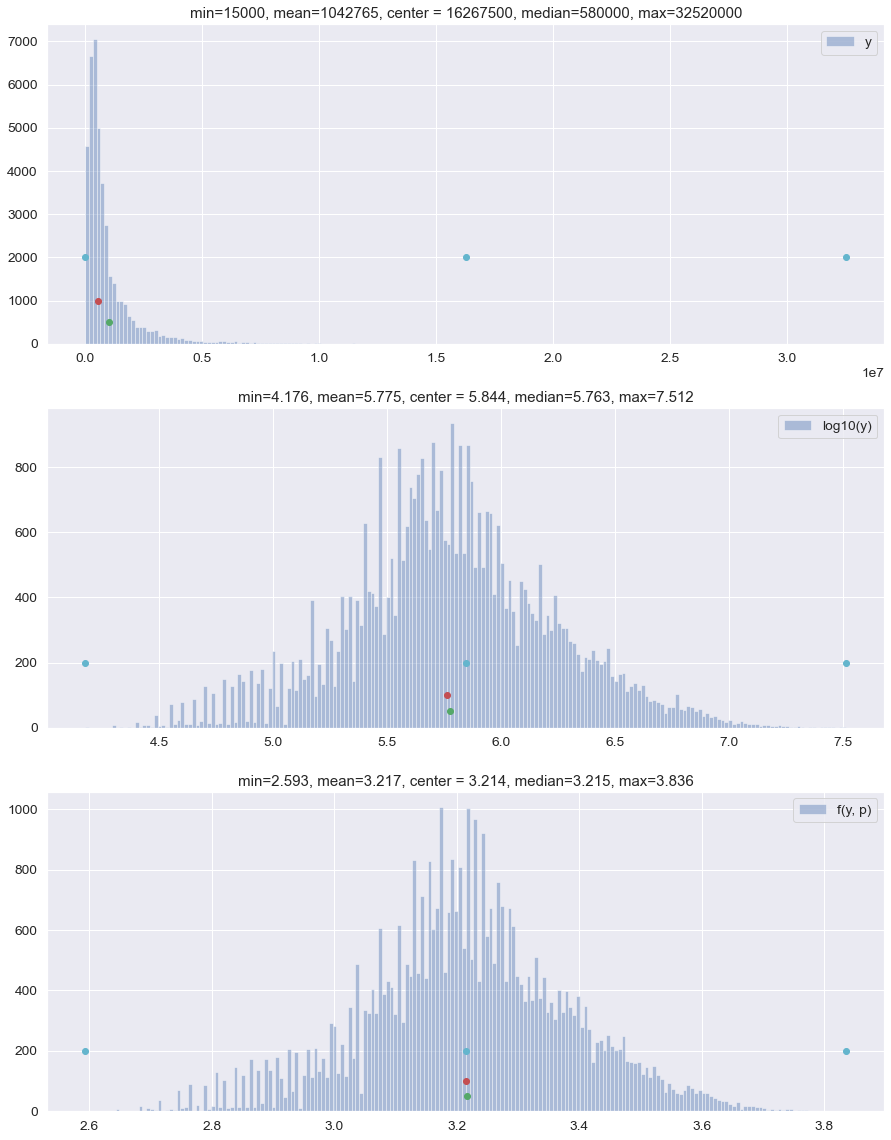

In [82]:
y = data_train1[target_name]

p = 1.5
z = target_transform(y, p)
s = target_transform_inv(z, p)


n_bins = 200

plt.subplots(3, 1, figsize=(15, 20))

plt.subplot(3, 1, 1)
level = 1000
sns.distplot(y, bins=n_bins, kde=False, label='y')
plt.plot(y.min(), 2*level, 'co')
plt.plot(y.mean(), level/2, 'go')
plt.plot(np.median(y), level, 'ro')
plt.plot(y.max(), 2*level, 'co')
plt.plot((y.max()+y.min())/2, 2*level, 'co')
plt.title("min={}, mean={:.0f}, center = {:.0f}, median={:.0f}, max={}"
          .format(y.min(), y.mean(), (y.max()+y.min())/2, np.median(y), y.max()))
plt.legend()
plt.xlabel('')

y_log = np.log10(y)

plt.subplot(3, 1, 2)
level = 100
sns.distplot(y_log, bins=n_bins, kde=False, label='log10(y)')
plt.plot(y_log.min(), 2*level, 'co')
plt.plot(y_log.mean(), level/2, 'go')
plt.plot(np.median(y_log), level, 'ro')
plt.plot((y_log.max()+y_log.min())/2, 2*level, 'co')
plt.plot(y_log.max(), 2*level, 'co')
plt.title("min={:.3f}, mean={:.3f}, center = {:.3f}, median={:.3f}, max={:.3f}"
          .format(y_log.min(), y_log.mean(), (y_log.max()+y_log.min())/2, np.median(y_log), y_log.max()))
plt.legend()
plt.xlabel('')

plt.subplot(3, 1, 3)
level = 100
sns.distplot(z, bins=n_bins, kde=False, label='f(y, p)')
plt.plot(z.min(), 2*level, 'co')
plt.plot(z.mean(), level/2, 'go')
plt.plot(np.median(z), level, 'ro')
plt.plot(z.max(), 2*level, 'co')
plt.plot((z.max()+z.min())/2, 2*level, 'co')
plt.title("min={:.3f}, mean={:.3f}, center = {:.3f}, median={:.3f}, max={:.3f}"
          .format(z.min(), z.mean(), (z.max()+z.min())/2, np.median(z), z.max()))
plt.legend()
plt.xlabel('')

print("The maximal relative error of target transformation =",
      ( np.abs( target_transform_inv(target_transform(y, p), p) - y )/y ).max())

## 5.3 Model optimizer

In [83]:
def model_one_coord_search(EstimatorClass, params_fixed, params_limits, 
                           data_trr, data_vall, target_name, n_sample, 
                           num_points=21, metrics_func=None,
                           lgb_categorical_feature_list='auto',
                           verbose=False, visualize=False):
    """
    This FUNCTION 
    - creates the model;
    - trains it with the train data;
    - makes the prediction from valid data;
    - calculate metrics and
    - measures the time of performance of all above actions.
    
    NOTE:
    ...
    ...LighnGBM (marked as 'lgb')
    
    INPUT:
    
    
    OUTPUT:
    
    Version 1.1
    Needs libraries:
    - pandas
    - numpy
    - scikit-learn
    - time
    
    """
    
    
    
    param_current = params_fixed.copy()

    data_tr = data_trr.copy()
    data_val = data_vall.copy()
    
    if n_sample < len(data_tr):        
        data_tr = data_tr.sample(n_sample, random_state=param_current['random_state'])
        
    ### target transformation
    ###
#     data_tr[target_name] = np.log10(data_tr[target_name])  ## log10-transformation
    data_tr[target_name] = target_transform(data_tr[target_name], POWER)
        
    feat_train = data_tr.drop([target_name], axis=1)
    targ_train = data_tr[target_name]
    
    feat_valid = data_val.drop([target_name], axis=1)
    targ_valid = data_val[target_name]
    
    
    for key in params_limits.keys():
        if params_limits[key][2] == 'int':
            param_range = np.linspace(params_limits[key][0], params_limits[key][1], num=num_points, dtype=int)
        else:
            param_range = np.linspace(params_limits[key][0], params_limits[key][1], num=num_points)
                        
        param_range = np.unique(param_range)
        
        metrics_list = []
        performance_list = []
        metrics_best = 10**10
        best_param = None
        
        for k, point in enumerate(param_range):
            param_current[key] = point
            
            ### ** - The best way to initialise estimator with the parameters
            ### would be to unpack dictionary
            if EstimatorClass != 'lgbm':
                t0 = time.time()
                model = EstimatorClass(**param_current)
                model.fit(feat_train, targ_train)
            else:
                # We should give LightGBM data converted to his own form 
                # Here data is pandas.DataFrame with catecorical data, label is target
                train_data = lgbm.Dataset(data_tr.drop([target_name], axis=1), label=data_tr[target_name], 
                                          categorical_feature=lgb_categorical_feature_list)
                t0 = time.time()
                model = lgbm.train(param_current, train_data)
                
            ### target inverse transformation
            ###
#             prediction = model.predict(feat_valid)
#             prediction_log10 = model.predict(feat_valid)
            prediction_transformed = model.predict(feat_valid)
            prediction = target_transform_inv(prediction_transformed, POWER)
        
            
            metrics = metrics_func(targ_valid, prediction)
            metrics_list.append(metrics)
            
            if metrics < metrics_best:
                metrics_best = metrics
                best_param = point
            
            performance_time = time.time() - t0
            performance_list.append(performance_time)
            
            if verbose:
                print("{} : {} = {:.6f} : METRICS = {:.4f} ; eval_time = {:.3f} sec"
                      .format( k, key, point, metrics, performance_time ))
        
        metrics_array = np.array(metrics_list)
        performance_array = np.array(performance_list)
        
        if visualize:
            fig, ax = plt.subplots(1, 1, figsize=(16, 8))
            
            plt.plot(best_param, metrics_best, 'o', markersize=14, 
                     markerfacecolor='w', markeredgecolor='r', label="best point")
            plt.plot(param_range, metrics_array, '-bo', label="")
            plt.legend()
            plt.title("The best metrics is {:.4f} for {}={}"
                      .format( metrics_best, key, best_param ))
        
    return metrics_array, param_range, performance_array, best_param, metrics_best

Test of `model_one_coord_search` (Stage 1)

In [84]:
# features_categorical

In [85]:
# EstimatorClass = 'lgbm'

# model_type = 'LGBM'

# ### fixed parameters

# try:
#     param_dict_fix
# except NameError:
#     pass
# else:
#     del param_dict_fix

# param_dict_fix = {}

# param_dict_fix['objective'] = OBJECTIVE
# # param_dict_fix['boosting_type'] = 'gbdt'
# param_dict_fix['random_state'] = RANDOM_STATE
# # param_dict_fix['silent'] = False
# param_dict_fix['free_raw_data'] = False

# param_dict_fix['n_estimators'] = 3495
# param_dict_fix['learning_rate'] = 0.0218
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
# param_dict_fix['max_depth'] = 16

# # param_dict_fix['max_depth'] = -1, ## no limit
# ### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
# ### <= 0 means no limit

# ### variable parameters

# params_lim = {}
# # params_lim['n_estimators'] = [2, 1000, 'int']
# # params_lim['learning_rate'] = [0.001, 2, 'float']
# params_lim['min_data_in_leaf'] = [11, 31, 'int']

In [86]:
# ### TEST OF ONE COORDINATE SEARCH

# result = model_one_coord_search(EstimatorClass, param_dict_fix, params_lim, 
#                                 data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
#                                 metrics_func=mean_absolute_percent_error,
#                                 lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
#                                 verbose=True, visualize=True)

# metrics_array, param_range, performance_array, best_param, metrics_best = result

# print()
# print("metrics_array:", metrics_array)
# print()

# print("param_range:", param_range)
# print()

# print("performance_array:", performance_array)
# print()

# print("best_param =", best_param)
# print()

# print("metrics_best =", metrics_best)
# print()

In [87]:
def model_coord_search_loop(EstimatorClass, params_fixed, params_limits, 
                            data_tr, data_val, target_name, n_sample, 
                            num_points=21, metrics_func=None,
                            lgb_categorical_feature_list='auto',
                            verbose=False, visualize=False):
    
    
    param_current = params_fixed.copy()
    
    best_param_loop = {}
    metrics_best_loop = 10**10
    
    param_lim_1 = {}
    result_dict = {}
    for key in params_limits.keys():
        param_lim_1[key] = params_limits[key]
        if verbose:
            print()
            print("^^^")
            print("Fixed", param_current)
            print("Varies", param_lim_1)
            print("^^^\n")
        result = model_one_coord_search(EstimatorClass, param_current, param_lim_1, 
                                        data_tr, data_val, target_name, n_sample, 
                                        num_points=num_points, metrics_func=metrics_func,
                                        lgb_categorical_feature_list=lgb_categorical_feature_list,
                                        verbose=verbose, visualize=visualize)
        metrics_array, param_range, performance_array, best_param, metrics_best = result
        
        if best_param < metrics_best_loop:
            metrics_best_loop = best_param
        
        param_current[key] = best_param
        result_dict[key] = best_param
        param_lim_1 = {}
        
        if verbose:
            print()
            print("*** Best {} = {} witn METRICS = {}".format(key, best_param, metrics_best))
        
    return result_dict, metrics_best

Test of `model_coord_search_loop` (Stage 2)

In [88]:
# EstimatorClass = 'lgbm'

# model_type = 'LGBM'

# ### fixed parameters

# try:
#     param_dict_fix
# except NameError:
#     pass
# else:
#     del param_dict_fix

# param_dict_fix = {}

# param_dict_fix['objective'] = OBJECTIVE
# # param_dict_fix['boosting_type'] = 'gbdt'
# param_dict_fix['random_state'] = RANDOM_STATE
# # param_dict_fix['silent'] = False
# param_dict_fix['free_raw_data'] = False

# param_dict_fix['n_estimators'] = 3495
# param_dict_fix['learning_rate'] = 0.0218
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
# param_dict_fix['max_depth'] = 16
# # param_dict_fix['max_depth'] = -1, ## no limit
# ### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
# ### <= 0 means no limit





# ### variable parameters

# params_lim = {}
# params_lim['n_estimators'] = [2, 100, 'int']
# params_lim['max_depth'] = [2, 22, 'int']
# # params_lim['learning_rate'] = [0.001, 2.001, 'float']

In [89]:
# result = model_coord_search_loop(EstimatorClass, param_dict_fix, params_lim, 
#                                  data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
#                                  metrics_func=mean_absolute_percent_error,
#                                  lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
#                                  verbose=True, visualize=True)

# result_dict, metrics_best = result

# print("***")
# print("*** result_dict :", result_dict)
# print("*** metrics_best =", metrics_best)
# print("***")

In [90]:
def model_coord_search(EstimatorClass, params_fixed, params_limits, 
                       data_tr, data_val, target_name, n_sample, 
                       num_points=21, metrics_func=None, tol=0.0001, iter_lim=100,
                       lgb_categorical_feature_list='auto',
                       verbose_cycle=False, verbose_detail=False, 
                       visualize_cycle=False, visualize_detail=False):
    
    """
    This fuction performs the search of the best parameters over specified parameter values 
    for an estimator using coordinate search.
    
    PARAMETERS:
        
    EstimatorClass - estimator object. 
        This is assumed to implement the scikit-learn estimator interface with `fit` and `predict` methods. 
        LightGBM is a special case - you should define EstimatorClass as a string 'lgbm' and
        `import lightgbm as lgbm` .
    
    params_fixed - dict. 
        Dictionary with parameters names (str) as keys and lists of parameter settings to try. 
        Such a list contains three elements: 
            First - the minimal limit for the parameter grid ('int' or 'float')
            Second - the maximal limit for the parameter grid ('int' or 'float')
            Third - the type of variable (str: 'int' or 'float'). The string which is not 'int' treated as 'float'.    
    
    params_limits - dict.
    
                       data_tr, data_val, target_name, n_sample, 
                       num_points=21, metrics_func=None, tol=0.0001, iter_lim=100,
                       lgb_categorical_feature_list='auto',
                       verbose_cycle=False, verbose_detail=False, 
                       visualize_cycle=False, visualize_detail=False
    """
    
    metrics_in = 10**10
    metrics_out = 10**9
    
    metrics_best = 10**10
    best_params = {}
    
    k = 0
    metrics_to_plot = []
    while metrics_in - metrics_out >= tol: 
        t0 = time.time()
        if verbose_cycle:
            print("[{}]".format(k))
            print("params_limits :", params_limits)
            
        metrics_in = metrics_out        
        result_dict, metrics_out = model_coord_search_loop(EstimatorClass, params_fixed, params_limits, 
                                                            data_tr, data_val, target_name, n_sample, 
                                                            num_points=num_points, metrics_func=metrics_func,
                                                            lgb_categorical_feature_list='auto',
                                                            verbose=verbose_detail, visualize=visualize_detail)
        if metrics_out < metrics_best:
            metrics_best = metrics_out
            best_params = result_dict
        
        
        metrics_to_plot.append(metrics_out)
        
        for key in params_limits.keys():
            step_key = ( params_limits[key][1] - params_limits[key][0] ) / ( num_points - 1 )
            if params_limits[key][2] == 'int':
                step_key = int(np.ceil(step_key))
                
            lim_min = result_dict[key] - step_key
            if lim_min < params_limits[key][0]:
                lim_min = params_limits[key][0]
            lim_max = result_dict[key] + step_key
            params_limits[key] = [ lim_min, lim_max, params_limits[key][2] ]
            
        
        if verbose_cycle:
            print("OUT [{}]: M(i) = {:.6f}; M(i+1) = {:.6f} (tol={})"
                  .format(k, metrics_in, metrics_out, tol))
            print("result_dict", result_dict)
            print("Iteration time = {:.2f} sec".format( time.time() - t0 ))
            print("\n", "~ "*9, "\n")
        k += 1
        if k > iter_lim:
            print("The limit of iterations is achieved. Sorry!")
            break
            
    print(min(metrics_to_plot))
    if visualize_cycle:        
        shift = 0.03*(max(metrics_to_plot) - min(metrics_to_plot))
        x = np.arange(0, len(metrics_to_plot))
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        plt.plot(x, metrics_to_plot, '-bo')
        plt.xlabel("Iteration", fontsize=14)
        plt.ylabel("Metrics", fontsize=14)
        for a, b in zip(x, metrics_to_plot): 
            plt.text(a, b+shift, str( np.round(b, 4)), fontsize=12)
        plt.show()
    
    print()
    print("Done. Congratulations!")
    
    return best_params, metrics_best

# 6 Optimization of base models

## 6.1 LightGBM with default parameters

In [91]:
param_current = {}

data_tr_unopt = data_train1.copy()
data_val_unopt = data_valid1.copy()

data_tr_unopt[target_name] = np.log10(data_tr_unopt[target_name])
data_val_unopt[target_name] = np.log10(data_val_unopt[target_name])

train_data = lgbm.Dataset(data_tr_unopt.drop([target_name], axis=1), label=data_tr_unopt[target_name])

model = lgbm.train(param_current, train_data)
# prediction = model.predict(data_val_unopt.drop([target_name], axis=1))
prediction_log10 = model.predict(data_val_unopt.drop([target_name], axis=1))
prediction = 10**prediction_log10
mape_unoptimized = mean_absolute_percent_error(data_valid1[target_name], prediction)

print("We have MAPE={:.4f} for unoptimized model.".format(mape_unoptimized))

We have MAPE=13.8435 for unoptimized model.


<div class="alert alert-block alert-success">
<div style="border:solid green 2px; padding: 20px"> <h2 style="color:green; margin-bottom:20px">
6.2 Optimization of base models (*LGBMRegressor*)</h2>

</div>

- [Basic info](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor)

In [92]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 2990
param_dict_fix['learning_rate'] = 0.025
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 7
# param_dict_fix['max_depth'] = -1, ## no limit
### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
### <= 0 means no limit





### variable parameters

params_lim = {}

params_lim['n_estimators'] = [2989, 2991, 'int']
params_lim['learning_rate'] = [0.015, 0.035, 'float']
params_lim['max_depth'] = [5, 7, 'int']
# params_lim['num_leaves'] = [2, 127, 'int']
# params_lim['min_data_in_leaf'] = [2, 1002, 'int']

[0]
params_limits : {'n_estimators': [2989, 2991, 'int'], 'learning_rate': [0.015, 0.035, 'float'], 'max_depth': [5, 7, 'int']}


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


OUT [0]: M(i) = 1000000000.000000; M(i+1) = 13.168128 (tol=0.0001)
result_dict {'n_estimators': 2989, 'learning_rate': 0.019, 'max_depth': 7}
Iteration time = 519.98 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[1]
params_limits : {'n_estimators': [2989, 2990, 'int'], 'learning_rate': [0.018, 0.02, 'float'], 'max_depth': [6, 8, 'int']}
OUT [1]: M(i) = 13.168128; M(i+1) = 13.151777 (tol=0.0001)
result_dict {'n_estimators': 2989, 'learning_rate': 0.0196, 'max_depth': 7}
Iteration time = 509.51 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[2]
params_limits : {'n_estimators': [2989, 2990, 'int'], 'learning_rate': [0.0195, 0.0197, 'float'], 'max_depth': [6, 8, 'int']}
OUT [2]: M(i) = 13.151777; M(i+1) = 13.151777 (tol=0.0001)
result_dict {'n_estimators': 2989, 'learning_rate': 0.0196, 'max_depth': 7}
Iteration time = 496.20 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

13.151777016097974


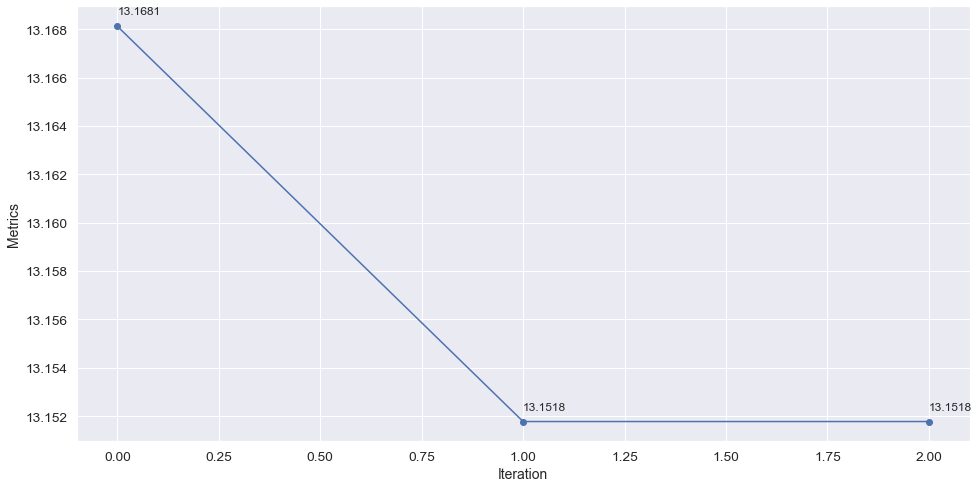


Done. Congratulations!
[***] This is Houston. The MET is : 0:26:36.367    (H:MM:SS)
==== ==== ==== ==== ==== 
The parameters of the best base model are:  {'n_estimators': 2989, 'learning_rate': 0.0196, 'max_depth': 7}
The best base model has MAPE=13.1518
Wall time: 25min 26s


In [93]:
%%time

result = model_coord_search(EstimatorClass, param_dict_fix, params_lim, 
                            data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
                            num_points=21,
                            metrics_func=mean_absolute_percent_error, tol=0.0001, iter_lim=100, 
                            lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
                            verbose_cycle=True, verbose_detail=False, 
                            visualize_cycle=True, visualize_detail=False)

result_dict, metrics_out = result

running_time(time.time(), total_time_start)

print("==== "*5)
print("The parameters of the best base model are: ", result_dict)
print("The best base model has MAPE={:.4f}".format(metrics_out))

In [94]:
best_model_1_mape = metrics_out
best_parameters = result_dict
print("The best parameters for the base model are: ", best_parameters)
print("We have the MAPE = {:.4f} for the best base model. ".format(best_model_1_mape))

The best parameters for the base model are:  {'n_estimators': 2989, 'learning_rate': 0.0196, 'max_depth': 7}
We have the MAPE = 13.1518 for the best base model. 


## 6.3 Collection of nearly best base models for meta-phase

In [95]:
def model_collector(EstimatorClass, params_fixed, params_opt, 
                    data_trr, data_vall, target_name, n_sample,
                    metrics_func=None,
                    lgb_categorical_feature_list='auto'):
    
    """
    """
    
    
    import itertools
    
    data_tr = data_trr.copy()
    data_val = data_vall.copy()
    
    try:
        rs = params_fixed['random_state']
    except:
        rs = None
    
    
    if n_sample < len(data_tr):        
        data_tr = data_tr.sample(n_sample, random_state=rs)
    
    data_tr[target_name] = np.log10(data_tr[target_name])
        
    feat_train = data_tr.drop([target_name], axis=1)
    targ_train = data_tr[target_name]
        
    feat_valid = data_val.drop([target_name], axis=1)
    targ_valid = data_val[target_name]
    
    result_df = pd.DataFrame( columns=list(params_opt.keys())+["metrics", "performance_time", "model"] )
    print(list(result_df.columns))
    
    keys, values = zip(*params_opt.items())
    ## list of dicts
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for k, dict_point in enumerate(permutations_dicts):
        param_current = {**params_fixed, **dict_point}
        
        if EstimatorClass != 'lgbm':
            t0 = time.time()
            model = EstimatorClass(**param_current)
            model.fit(feat_train, targ_train)
        else:
            # We should give LightGBM data converted to his own form 
            # Here data is pandas.DataFrame with catecorical data, label is target
            train_data = lgbm.Dataset(data_tr.drop([target_name], axis=1), label=data_tr[target_name], 
                                      categorical_feature=lgb_categorical_feature_list)
            t0 = time.time()
            model = lgbm.train(param_current, train_data)
                
#         prediction = model.predict(feat_valid)
        prediction_log10 = model.predict(feat_valid)
        prediction = 10**prediction_log10
        metrics = metrics_func(targ_valid, prediction)
        
        performance_time = time.time() - t0
        
        list_to_append = list( dict_point.values() ) + [metrics, performance_time, model]
        print(list_to_append)
        result_df = result_df.append(pd.DataFrame([list_to_append], columns=result_df.columns), ignore_index=True)
        
    result_df = result_df.sort_values('metrics', ascending=True).reset_index(drop=True)
        
    return result_df

In [96]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
# param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 2990
param_dict_fix['learning_rate'] = 0.025
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 7


# param_dict_fix['max_depth'] = -1, ## no limit
# param_dict_fix['n_estimators'] = 100
# param_dict_fix['learning_rate'] = 0.01



### best optimised parameters

n_es_0 = best_parameters['n_estimators']
md_0 = best_parameters['max_depth']
# lr_0 = np.round(best_parameters['learning_rate'], 9)
# n_l_0 = best_parameters['num_leaves']
# mdil_0 = best_parameters['min_data_in_leaf']

params_optim = {}
params_optim['n_estimators'] = [max([2, n_es_0-200*STEP_INT]), n_es_0-100*STEP_INT,
                                n_es_0, n_es_0+100*STEP_INT, n_es_0+200*STEP_INT ]
params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT, md_0+2*STEP_INT, md_0+3*STEP_INT ]

# params_optim['n_estimators'] = [max([2, n_es_0-100*STEP_INT]), n_es_0, n_es_0+100*STEP_INT ]
# params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT ]

# params_optim['num_leaves'] = [max([2, n_l_0-STEP_INT]), n_l_0, n_l_0+STEP_INT ]
# params_optim['min_data_in_leaf'] = [max([2, mdil_0-STEP_INT]), mdil_0, mdil_0+STEP_INT ]
# params_optim['learning_rate'] = [ max(0.0001, np.round(lr_0-STEP_LR, 9)), lr_0, np.round(lr_0+STEP_LR, 9) ]

# params_optim = {}
# params_optim['n_estimators'] = [1482, 1483, 1484] ##2264
# params_optim['max_depth'] = [10, 11, 12] ## 12
# params_optim['learning_rate'] = [0.067, 0.068, 0.069] ## 0.099

params_optim

{'n_estimators': [2789, 2889, 2989, 3089, 3189], 'max_depth': [6, 7, 8, 9, 10]}

In [97]:
%%time
base_model_storage =  model_collector(EstimatorClass, param_dict_fix, params_optim, 
                          data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
                          metrics_func=mean_absolute_percent_error,
                          lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM)  ## lgb_categorical_feature_list='auto',)

running_time(time.time(), total_time_start)

['n_estimators', 'max_depth', 'metrics', 'performance_time', 'model']


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2789, 6, 13.143471230007531, 17.904058933258057, <lightgbm.basic.Booster object at 0x000001F80764D648>]
[2789, 7, 13.161903558274707, 18.359376668930054, <lightgbm.basic.Booster object at 0x000001F800717588>]
[2789, 8, 13.197671276116472, 17.218995094299316, <lightgbm.basic.Booster object at 0x000001F800717AC8>]
[2789, 9, 13.173114795224041, 18.043405532836914, <lightgbm.basic.Booster object at 0x000001F80559AE88>]
[2789, 10, 13.157233971078503, 18.037264585494995, <lightgbm.basic.Booster object at 0x000001F8792AE488>]
[2889, 6, 13.144965600813501, 19.325176239013672, <lightgbm.basic.Booster object at 0x000001F8007D0D48>]
[2889, 7, 13.165627528240814, 16.72362470626831, <lightgbm.basic.Booster object at 0x000001F8004348C8>]
[2889, 8, 13.194162246127908, 16.93933415412903, <lightgbm.basic.Booster object at 0x000001F8006FB3C8>]
[2889, 9, 13.174518920807602, 16.4008629322052, <lightgbm.basic.Booster object at 0x000001F8002C2308>]
[2889, 10, 13.157401729117874, 18.39410090446472, <lightgb

In [98]:
base_model_storage = base_model_storage[ -base_model_storage['metrics'].duplicated() ]
base_model_storage.reset_index(inplace=True)
base_model_storage

index n_estimators max_depth    metrics  performance_time  \
0       0         2789         6  13.143471         17.904059   
1       1         2889         6  13.144966         19.325176   
2       2         2989         6  13.147299         20.506685   
3       3         3089         6  13.150332         17.292726   
4       4         3189         6  13.154751         21.730776   
5       5         2789        10  13.157234         18.037265   
6       6         2889        10  13.157402         18.394101   
7       7         2989        10  13.158386         17.194134   
8       8         2789         7  13.161904         18.359377   
9       9         3089        10  13.164911         18.682643   
10     10         2889         7  13.165628         16.723625   
11     11         2989         7  13.166382         18.378546   
12     12         3189        10  13.169994         17.337862   
13     13         3089         7  13.170579         17.638318   
14     14         2789         9  13.173115         18.043406   
15     15         2889         9  13.174519         16.400863   
16     16         3189         7  13.174576         18.941709   
17     17         2989         9  13.181157         17.382801   
18     18         3089         9  13.183058         17.552832   
19     19         3189         9  13.188036         18.969761   
20     20         2989         8  13.192500         17.841009   
21     21         2889         8  13.194162         16.939334   
22     22         2789         8  13.197671         17.218995   
23     23         3089         8  13.198999         17.536731   
24     24         3189         8  13.199754         18.054869   

                                                model  
0   <lightgbm.basic.Booster object at 0x000001F807...  
1   <lightgbm.basic.Booster object at 0x000001F800...  
2   <lightgbm.basic.Booster object at 0x000001F805...  
3   <lightgbm.basic.Booster object at 0x000001F800...  
4   <lightgbm.basic.Booster object at 0x000001F800...  
5   <lightgbm.basic.Booster object at 0x000001F879...  
6   <lightgbm.basic.Booster object at 0x000001F800...  
7   <lightgbm.basic.Booster object at 0x000001F800...  
8   <lightgbm.basic.Booster object at 0x000001F800...  
9   <lightgbm.basic.Booster object at 0x000001F800...  
10  <lightgbm.basic.Booster object at 0x000001F800...  
11  <lightgbm.basic.Booster object at 0x000001F800...  
12  <lightgbm.basic.Booster object at 0x000001F800...  
13  <lightgbm.basic.Booster object at 0x000001F804...  
14  <lightgbm.basic.Booster object at 0x000001F805...  
15  <lightgbm.basic.Booster object at 0x000001F800...  
16  <lightgbm.basic.Booster object at 0x000001F800...  
17  <lightgbm.basic.Booster object at 0x000001F800...  
18  <lightgbm.basic.Booster object at 0x000001F800...  
19  <lightgbm.basic.Booster object at 0x000001F800...  
20  <lightgbm.basic.Booster object at 0x000001F800...  
21  <lightgbm.basic.Booster object at 0x000001F800...  
22  <lightgbm.basic.Booster object at 0x000001F800...  
23  <lightgbm.basic.Booster object at 0x000001F800...  
24  <lightgbm.basic.Booster object at 0x000001F800...

## 6.4 About the best base model. Feature importance.

In [99]:
best_base_model = base_model_storage.loc[0, "model"]
print("Best base model demonstrates MAPE = {:.4f} with 'valid1' sample."
      .format(base_model_storage.loc[0, "metrics"]))

Best base model demonstrates MAPE = 13.1435 with 'valid1' sample.


In [100]:
# print(best_base_model.feature_importance().shape)

features_importances_best_base_model = pd.DataFrame(
    data=100*best_base_model.feature_importance()/best_base_model.feature_importance().sum(), 
    index=data_train1.drop([target_name], axis=1).columns, columns=['Importance_(%)'])

features_importances_best_base_model = features_importances_best_base_model.sort_values(by='Importance_(%)', 
                                                                                        ascending=False).head(20)
# print(best_base_model.feature_importance())
features_importances_best_base_model

Importance_(%)
mileage                          19.156099
year                             17.597806
model                            15.292807
power                            11.211624
displacement                      8.117074
color                             5.376291
mark                              5.173089
owners                            1.795769
gear_type                         1.602360
doors_count                       1.532586
transmission                      1.373452
body_type                         0.920531
abs                               0.754052
engine_type                       0.592469
airbag-driver                     0.501885
computer                          0.434559
automatic-lighting-control        0.432111
cruise-control                    0.422318
airbag-passenger                  0.406405
condition                         0.389267

In [101]:
y = np.log(features_importances_best_base_model.values)
x = np.arange(1, len(y)+1)

p = np.polyfit(x, y, 1)
length = -1/p[0]
feature_deficiency = 1/( np.exp(len(y)/length) - 1  )
print(length[0], feature_deficiency[0])
print("We have not {:.1%} of features".format(float(feature_deficiency)))
print("\n If you see 'nan', it means that at least one of feature has a zero-importance.")


real_importance = np.exp( np.polyval(p, x) )

4.303127161930661 0.009675545417347976
We have not 1.0% of features

 If you see 'nan', it means that at least one of feature has a zero-importance.


In [102]:
feature_deficiency = 0.01
print("We need {} instead of {} now for feature sufficiency of {:.1%}, while now we have {:.1%}."
      .format( int(np.ceil( -length*np.log(feature_deficiency) )), len(x), 1-feature_deficiency, 1-feature_deficiency ))

We need 20 instead of 20 now for feature sufficiency of 99.0%, while now we have 99.0%.


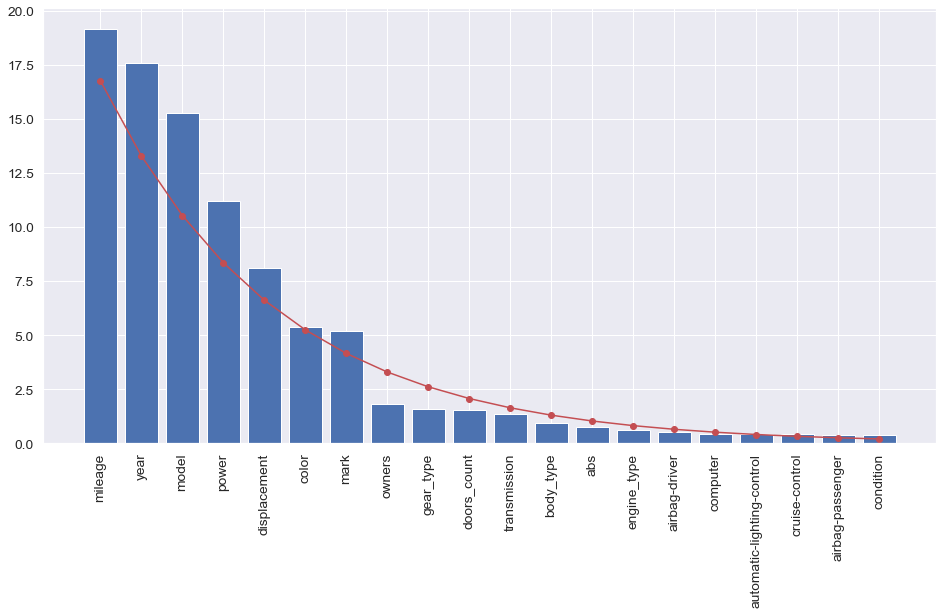

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plt.bar(x, features_importances_best_base_model['Importance_(%)'])
plt.plot(x, real_importance, '-ro')
plt.xticks(x, features_importances_best_base_model.index, rotation=90)

plt.show()

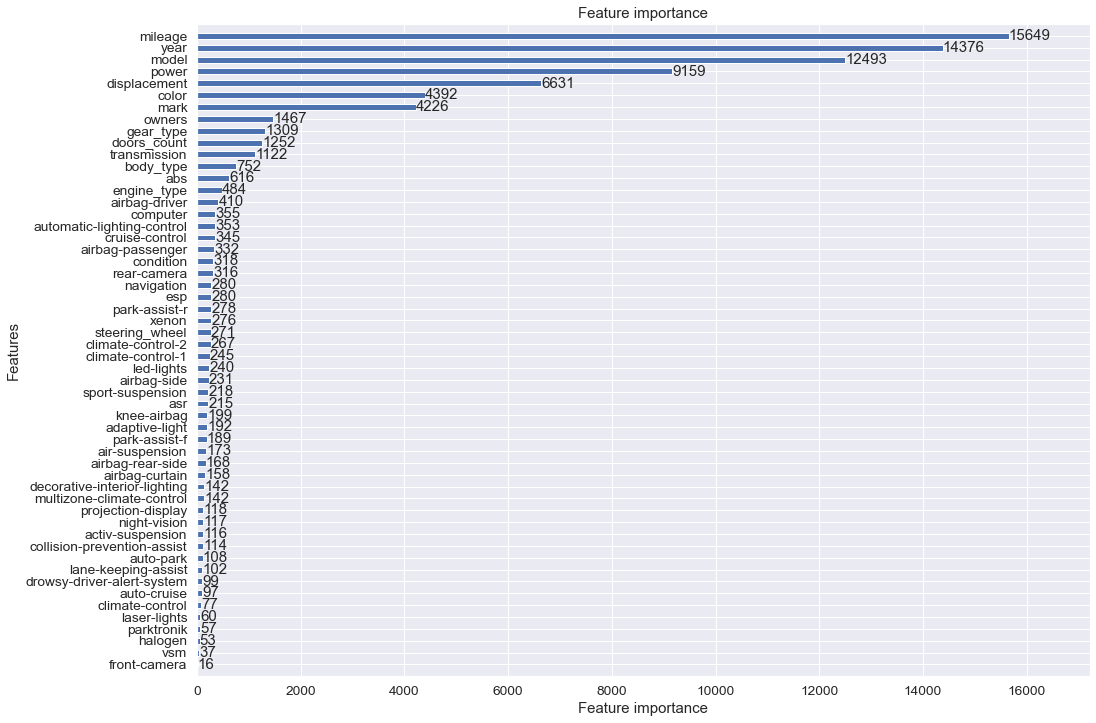

In [104]:
lgbm.plot_importance(best_base_model, height=0.5,  figsize=(16, 12))

The range of prediction for Model No. 0 are: [31915.7, 24329537.5] with the width of 24297621.9
The range of prediction for Model No. 1 are: [31838.5, 24368595.7] with the width of 24336757.3
The range of prediction for Model No. 2 are: [32007.8, 24319195.9] with the width of 24287188.1


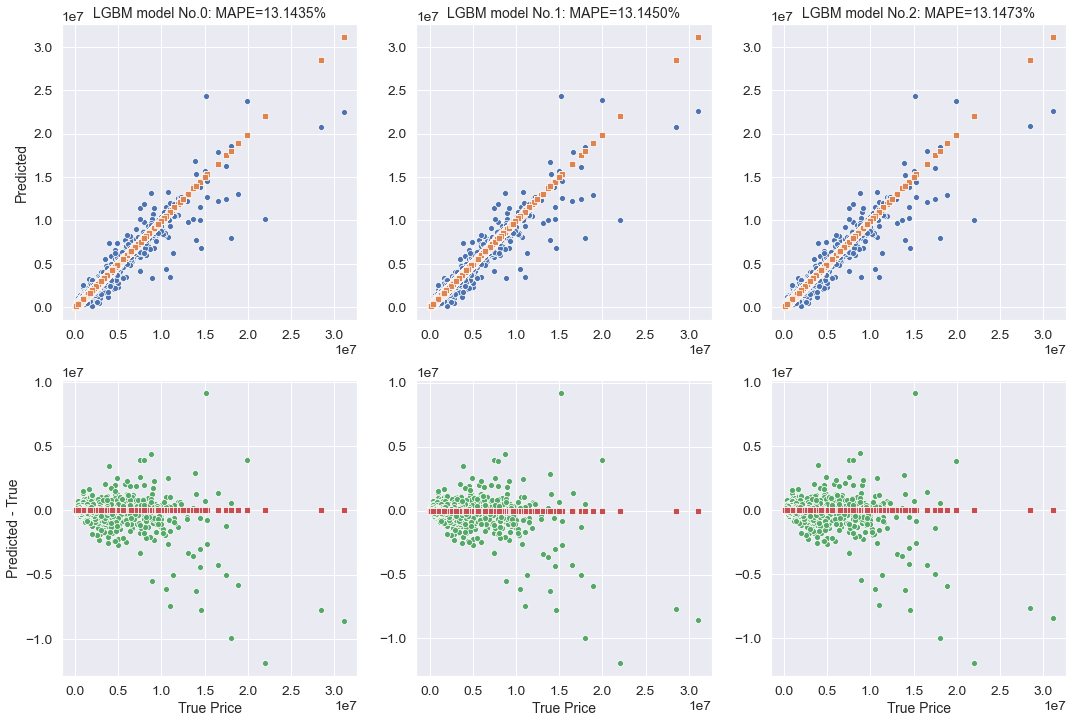

In [105]:
df = base_model_storage


n = min(3, len(df))

fig, axes = plt.subplots(2, n, figsize=(6*n, 12) )

for i in range(n):
    model = df.loc[i, "model"]
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    print("The range of prediction for Model No. {} are: [{:.1f}, {:.1f}] with the width of {:.1f}"
          .format( i, prediction.min(), prediction.max(), prediction.max()-prediction.min() ))
    
    plt.subplot(2, n, i+1)
    sns.scatterplot(data_valid1[target_name], prediction)
    sns.scatterplot(data_valid1[target_name], data_valid1[target_name], marker='s')
    plt.title("LGBM model No.{}: MAPE={:.4f}%".format(i, df.loc[i, "metrics"]), fontsize=FONT_SIZE)
    plt.xlabel("", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)
        
    plt.subplot(2, n, n+i+1)
    sns.scatterplot(data_valid1[target_name], prediction - data_valid1[target_name], color='g')
    sns.scatterplot(data_valid1[target_name], data_valid1[target_name] - data_valid1[target_name], marker='s', color='r')
    plt.xlabel("True Price", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted - True", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)

## 6.5 Averaged over $\sqrt{N}$ and $N$ best models prediction (*LGBMRegressor*)

Text(0, 0.5, 'Predicted - True')

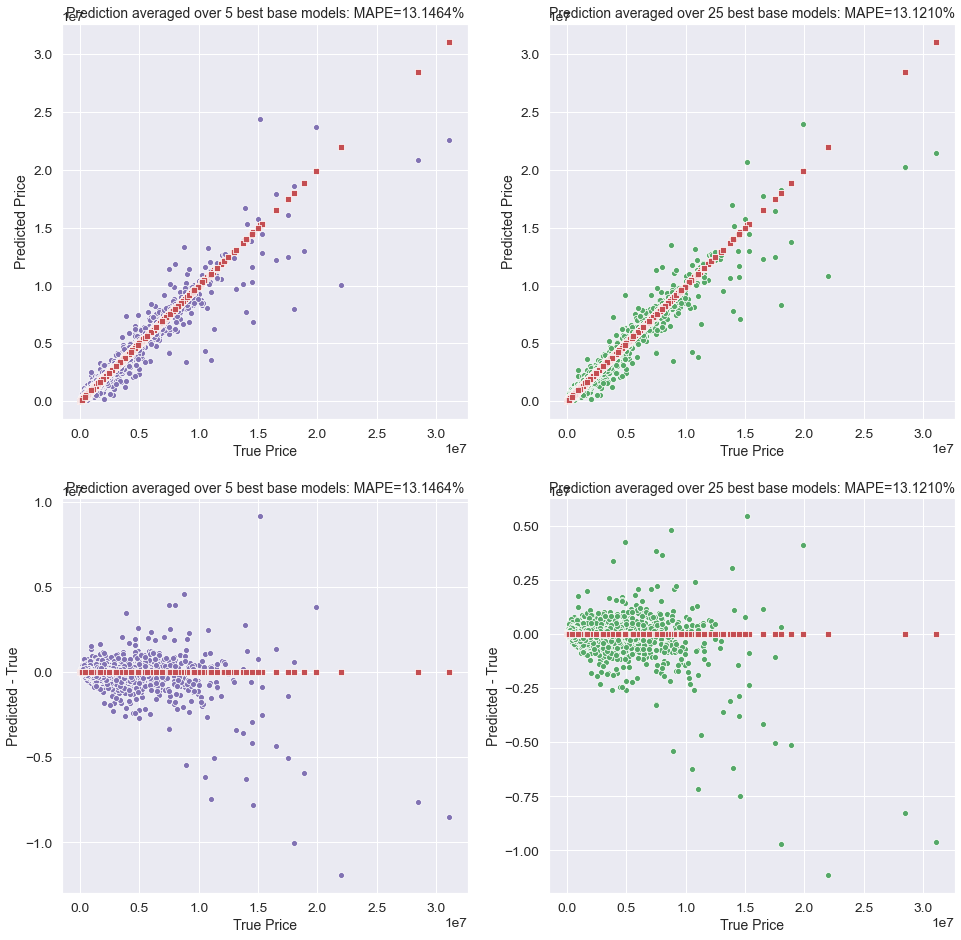

In [106]:
df = base_model_storage

fig, axes = plt.subplots(2, 2, figsize=(16, 16))



### SQRT

n_models = int(np.sqrt(len(df)))

predictions = []

for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    predictions.append(prediction)
    
predictions = np.array(predictions)
mean_prediction_sqrt = predictions.mean(axis=0)
mape_of_mean_sqrt = mean_absolute_percent_error(data_valid1[target_name], mean_prediction_sqrt)


plt.subplot(2, 2, 1)
sns.scatterplot(data_valid1[target_name], mean_prediction_sqrt, marker='o', color='m')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 3)
sns.scatterplot(data_valid1[target_name], mean_prediction_sqrt - data_valid1[target_name], marker='o', color='m')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name] - data_valid1[target_name], marker='s', color='r')

plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)



### ALL

n_models = len(df)

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    predictions.append(prediction)
    
predictions = np.array(predictions)
mean_prediction_all = predictions.mean(axis=0)
mape_of_mean_all = mean_absolute_percent_error(data_valid1[target_name], mean_prediction_all)


plt.subplot(2, 2, 2)
sns.scatterplot(data_valid1[target_name], mean_prediction_all, marker='o', color='g')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 4)
sns.scatterplot(data_valid1[target_name], mean_prediction_all - data_valid1[target_name], marker='o', color='g')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name] - data_valid1[target_name], marker='s', color='r')

plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

In [107]:
running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:35:57.574    (H:MM:SS)


<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h1 style="color:red; margin-bottom:20px">
7 STACKING</h1>

</div>

In [108]:
target_train_2 = data_train2[target_name].reset_index(drop=True)
target_valid_2 = data_valid2[target_name].reset_index(drop=True)

In [109]:
%%time

predictions_train_type = []
predictions_valid_type = []
predictions_train = []
predictions_valid = []

features_train_2 = data_train2.drop([target_name], axis=1)
features_valid_2 = data_valid2.drop([target_name], axis=1)


for k, model in enumerate(base_model_storage['model']):
    t0 = time.time()
#     prediction = model.predict(features_train_2)
    prediction_log10 = model.predict(features_train_2)
    prediction = 10**prediction_log10
    predictions_train.append(prediction)
    
#     prediction = model.predict(features_valid_2)
    prediction_log10 = model.predict(features_valid_2)
    prediction = 10**prediction_log10
    predictions_valid.append(prediction)
    print("[{}/{}] : {:.2f} sec".format( k+1, len(base_model_storage), time.time()-t0 ))

data_meta_train = pd.DataFrame(predictions_train).T
data_meta_valid = pd.DataFrame(predictions_valid).T


###  Aceraged prediction

averaged_meta_prediction_train = data_meta_train.mean(axis=1)
data_meta_train['Averaged'] = averaged_meta_prediction_train

averaged_meta_prediction_valid = data_meta_valid.mean(axis=1)
data_meta_valid['Averaged'] = averaged_meta_prediction_valid

data_meta_train[target_name] = target_train_2
data_meta_valid[target_name] = target_valid_2

print(data_meta_train.shape, target_train_2.shape, data_meta_valid.shape, target_valid_2.shape)
running_time(time.time(), total_time_start)

[1/25] : 12.45 sec
[2/25] : 12.80 sec
[3/25] : 13.16 sec
[4/25] : 13.23 sec
[5/25] : 13.56 sec
[6/25] : 10.68 sec
[7/25] : 10.92 sec
[8/25] : 9.81 sec
[9/25] : 10.23 sec
[10/25] : 10.47 sec
[11/25] : 10.78 sec
[12/25] : 12.02 sec
[13/25] : 11.50 sec
[14/25] : 11.94 sec
[15/25] : 9.45 sec
[16/25] : 10.16 sec
[17/25] : 12.54 sec
[18/25] : 10.93 sec
[19/25] : 11.60 sec
[20/25] : 11.84 sec
[21/25] : 11.13 sec
[22/25] : 11.51 sec
[23/25] : 10.93 sec
[24/25] : 11.79 sec
[25/25] : 11.95 sec
(41424, 27) (41424,) (13808, 27) (13808,)
[***] This is Houston. The MET is : 0:40:49.786    (H:MM:SS)
Wall time: 4min 52s


In [110]:
print("Number of meta-features :", data_meta_valid.shape[1]-1)
data_meta_valid

Number of meta-features : 26


0             1             2             3             4  \
0      1.132167e+06  1.138047e+06  1.139373e+06  1.142442e+06  1.148812e+06   
1      1.004262e+06  1.004594e+06  1.004638e+06  1.006053e+06  1.006777e+06   
2      2.822633e+05  2.822705e+05  2.825449e+05  2.822465e+05  2.821920e+05   
3      1.077333e+06  1.075658e+06  1.074443e+06  1.072253e+06  1.071296e+06   
4      2.429269e+05  2.409667e+05  2.394895e+05  2.393237e+05  2.385533e+05   
...             ...           ...           ...           ...           ...   
13803  1.105593e+06  1.106435e+06  1.107064e+06  1.106743e+06  1.107446e+06   
13804  1.080400e+05  1.079181e+05  1.078101e+05  1.078093e+05  1.073748e+05   
13805  1.106153e+06  1.105010e+06  1.102926e+06  1.104558e+06  1.105128e+06   
13806  8.713090e+05  8.700471e+05  8.690240e+05  8.677164e+05  8.673899e+05   
13807  6.172884e+05  6.174867e+05  6.161927e+05  6.154988e+05  6.145764e+05   

                  5             6             7             8             9  \
0      1.148655e+06  1.148569e+06  1.156881e+06  1.178685e+06  1.157946e+06   
1      1.005343e+06  1.005384e+06  1.006719e+06  1.003300e+06  1.009232e+06   
2      2.813302e+05  2.810219e+05  2.809156e+05  2.810828e+05  2.808263e+05   
3      1.082836e+06  1.082957e+06  1.083948e+06  1.079097e+06  1.084719e+06   
4      2.274862e+05  2.273279e+05  2.256538e+05  2.403761e+05  2.252209e+05   
...             ...           ...           ...           ...           ...   
13803  1.106389e+06  1.106525e+06  1.106861e+06  1.109298e+06  1.107419e+06   
13804  1.183636e+05  1.174829e+05  1.174534e+05  1.105255e+05  1.175150e+05   
13805  1.168662e+06  1.166270e+06  1.165523e+06  1.157327e+06  1.165656e+06   
13806  8.832314e+05  8.799412e+05  8.787007e+05  8.612753e+05  8.767185e+05   
13807  6.352504e+05  6.338401e+05  6.340733e+05  6.207602e+05  6.346332e+05   

       ...            17            18            19            20  \
0      ...  1.152454e+06  1.152127e+06  1.148682e+06  1.152332e+06   
1      ...  1.014813e+06  1.015408e+06  1.015404e+06  1.014929e+06   
2      ...  2.849292e+05  2.850017e+05  2.847072e+05  2.798169e+05   
3      ...  1.085001e+06  1.085263e+06  1.085947e+06  1.061560e+06   
4      ...  2.214912e+05  2.216979e+05  2.218278e+05  2.287744e+05   
...    ...           ...           ...           ...           ...   
13803  ...  1.110258e+06  1.110525e+06  1.110755e+06  1.119363e+06   
13804  ...  1.164022e+05  1.158319e+05  1.158661e+05  1.137721e+05   
13805  ...  1.133021e+06  1.137295e+06  1.138530e+06  1.139625e+06   
13806  ...  8.696009e+05  8.666893e+05  8.653580e+05  8.728235e+05   
13807  ...  6.253676e+05  6.227526e+05  6.221083e+05  6.261023e+05   

                 21            22            23            24      Averaged  \
0      1.149790e+06  1.143879e+06  1.151773e+06  1.155534e+06  1.157714e+06   
1      1.014473e+06  1.013647e+06  1.015204e+06  1.015938e+06  1.009558e+06   
2      2.801898e+05  2.803465e+05  2.794966e+05  2.794522e+05  2.818058e+05   
3      1.061857e+06  1.061005e+06  1.061106e+06  1.060948e+06  1.076733e+06   
4      2.290281e+05  2.275660e+05  2.280351e+05  2.287513e+05  2.314455e+05   
...             ...           ...           ...           ...           ...   
13803  1.118518e+06  1.117173e+06  1.121032e+06  1.121746e+06  1.110670e+06   
13804  1.139893e+05  1.139935e+05  1.133453e+05  1.133027e+05  1.129882e+05   
13805  1.138945e+06  1.142164e+06  1.139699e+06  1.139565e+06  1.141233e+06   
13806  8.739781e+05  8.741913e+05  8.720923e+05  8.717237e+05  8.700682e+05   
13807  6.268886e+05  6.275762e+05  6.251824e+05  6.253854e+05  6.238595e+05   

         price  
0      1300000  
1       850000  
2       330000  
3      1250000  
4       320000  
...        ...  
13803  1117910  
13804   130000  
13805  1075000  
13806   950000  
13807   645000  

[13808 rows x 27 columns]

<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h2 style="color:red; margin-bottom:20px">
7.1 BLENDING</h2>

</div>

### 7.1.1 Average prediction (Bagging)

In [111]:
mape_averaged_meta_valid = mean_absolute_percent_error(data_meta_valid[target_name], data_meta_valid['Averaged'])
print("We have MAPE={:.4f} for the prediction which is averaged over all meta-predictions".format(mape_averaged_meta_valid))

We have MAPE=13.4003 for the prediction which is averaged over all meta-predictions


Text(0, 0.5, 'Predicted - True')

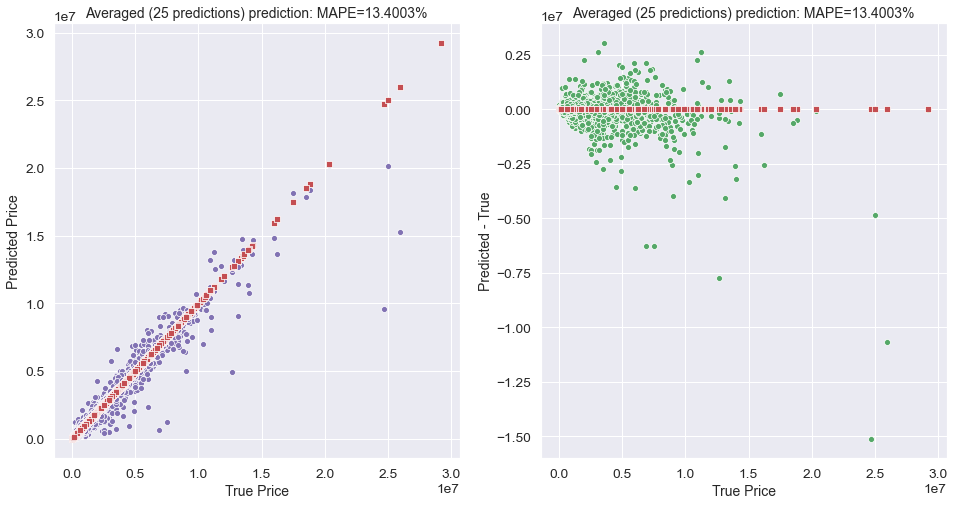

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(data_meta_valid[target_name], data_meta_valid['Averaged'], marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')

plt.title("Averaged ({} predictions) prediction: MAPE={:.4f}%"
          .format(data_meta_valid.shape[1]-2, mape_averaged_meta_valid), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(1, 2, 2)
sns.scatterplot(data_meta_valid[target_name], data_meta_valid['Averaged']-data_meta_valid[target_name], marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name]-data_meta_valid[target_name], marker='s', color='r')

plt.title("Averaged ({} predictions) prediction: MAPE={:.4f}%"
          .format(data_meta_valid.shape[1]-2, mape_averaged_meta_valid), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

### 7.1.2 Weighted average prediction  (*LinerRegression*)

In [113]:
# %%time

# model = LinearRegression()
# model.fit(data_meta_train.drop([target_name], axis=1), data_meta_train[target_name])
# prediction_blend = model.predict(data_meta_valid.drop([target_name], axis=1))
# mape_blend = mean_absolute_percent_error(data_meta_valid[target_name], prediction_blend)

# print("With the simplest blending procedure we got MAPE = {:.4f}".format(mape_blend))

# running_time(time.time(), total_time_start)

In [114]:
# print("Let us compare the intercept coeff of LinearRegression ({:.2f}) with the mean taget value ({:.2f}) :  intercept/mean = {:.2%}"
#       .format( model.intercept_, data_meta_valid[target_name].mean(), model.intercept_/data_meta_valid[target_name].mean() ))

In [115]:
# fig, axes = plt.subplots(1, 2, figsize=(16, 8))


# plt.subplot(1, 2, 1)
# sns.scatterplot(data_meta_valid[target_name], prediction_blend, marker='o', color='m')
# sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')

# plt.title("Blending prediction: MAPE={:.4f}%".format(mape_blend), fontsize=FONT_SIZE)
# plt.xlabel("True Price", fontsize=FONT_SIZE)
# plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


# plt.subplot(1, 2, 2)
# sns.scatterplot(data_meta_valid[target_name], prediction_blend-data_meta_valid[target_name], marker='o', color='g')
# sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name]-data_meta_valid[target_name], marker='s', color='r')

# plt.title("Blending prediction: MAPE={:.4f}%".format(mape_blend), fontsize=FONT_SIZE)
# plt.xlabel("True Price", fontsize=FONT_SIZE)
# plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

In [116]:
# running_time(time.time(), total_time_start)

<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h2 style="color:red; margin-bottom:20px">
7.2 Stacking  with LightGBM</h2>

</div>

### 7.2.1 Optimization of  meta model

In [117]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 926
param_dict_fix['learning_rate'] = 0.025
# param_dict_fix['num_leaves'] = 8
# param_dict_fix['min_data_in_leaf'] = 107
param_dict_fix['max_depth'] = 3
# param_dict_fix['max_depth'] = -1, ## no limit
### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
### <= 0 means no limit



### variable parameters

params_lim = {}

params_lim['n_estimators'] = [925, 927, 'int']
params_lim['learning_rate'] = [0.0245, 0.0255, 'float']
params_lim['max_depth'] = [2, 4, 'int']
# params_lim['num_leaves'] = [2, 127, 'int']
# params_lim['min_data_in_leaf'] = [2, 1002, 'int']

[0]
params_limits : {'n_estimators': [925, 927, 'int'], 'learning_rate': [0.0245, 0.0255, 'float'], 'max_depth': [2, 4, 'int']}


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


OUT [0]: M(i) = 1000000000.000000; M(i+1) = 13.523486 (tol=0.0001)
result_dict {'n_estimators': 925, 'learning_rate': 0.0255, 'max_depth': 2}
Iteration time = 46.28 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[1]
params_limits : {'n_estimators': [925, 926, 'int'], 'learning_rate': [0.025449999999999997, 0.02555, 'float'], 'max_depth': [2, 3, 'int']}
OUT [1]: M(i) = 13.523486; M(i+1) = 13.523486 (tol=0.0001)
result_dict {'n_estimators': 925, 'learning_rate': 0.0255, 'max_depth': 2}
Iteration time = 43.54 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

13.523485688741651


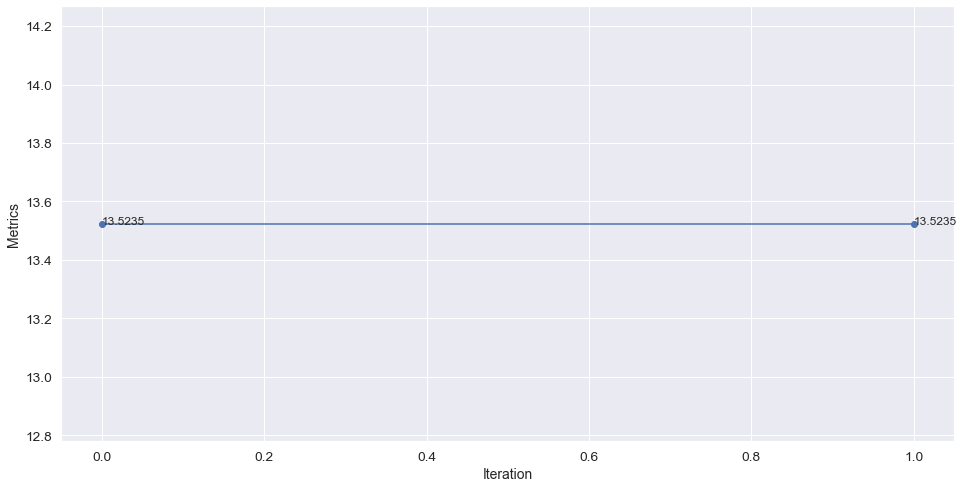


Done. Congratulations!
[***] This is Houston. The MET is : 0:42:21.530    (H:MM:SS)
==== ==== ==== ==== ==== 
The parameters of the best meta model are:  {'n_estimators': 925, 'learning_rate': 0.0255, 'max_depth': 2}
The best meta model has MAPE=13.5235
Wall time: 1min 30s


In [118]:
%%time

result = model_coord_search(EstimatorClass, param_dict_fix, params_lim, 
                            data_meta_train, data_meta_valid, target_name, N_SAMPLE_META, 
                            metrics_func=mean_absolute_percent_error, tol=0.0001, iter_lim=100, 
                            lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
                            verbose_cycle=True, verbose_detail=False, 
                            visualize_cycle=True, visualize_detail=False)

result_dict, metrics_out = result

running_time(time.time(), total_time_start)

print("==== "*5)
print("The parameters of the best meta model are: ", result_dict)
print("The best meta model has MAPE={:.4f}".format(metrics_out))

In [119]:
best_meta_model_mape = metrics_out
best_parameters_meta = result_dict
print("The best parameters for the meta model are: ", best_parameters_meta)
print("We have the MAPE = {:.4f} for the best meta model. ".format(best_meta_model_mape))

The best parameters for the meta model are:  {'n_estimators': 925, 'learning_rate': 0.0255, 'max_depth': 2}
We have the MAPE = 13.5235 for the best meta model. 


### 7.2.2 Collect an ensemle of nearly best meta models

In [120]:
EstimatorClass = 'lgbm'



### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
# param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 31
param_dict_fix['learning_rate'] = 0.1101
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 4


# param_dict_fix['max_depth'] = -1, ## no limit
# param_dict_fix['n_estimators'] = 100
# param_dict_fix['learning_rate'] = 0.01



### best optimised parameters

n_es_0 = best_parameters_meta['n_estimators']
md_0 = best_parameters_meta['max_depth']
lr_0 = np.round(best_parameters_meta['learning_rate'], 9)
# n_l_0 = best_parameters_meta['num_leaves']
# mdil_0 = best_parameters_meta['min_data_in_leaf']

params_optim = {}
# params_optim['n_estimators'] = [max([2, n_es_0-200*STEP_INT]), n_es_0-100*STEP_INT,
#                                 n_es_0, n_es_0+100*STEP_INT, n_es_0+200*STEP_INT ]
# params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT, md_0+2*STEP_INT, md_0+3*STEP_INT ]

params_optim['n_estimators'] = [max([2, n_es_0-100*STEP_INT]), n_es_0, n_es_0+100*STEP_INT ]
params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT ]

# params_optim['learning_rate'] = [ max(0.0001, np.round(lr_0-STEP_LR, 9)), lr_0, np.round(lr_0+STEP_LR, 9) ]
# params_optim['num_leaves'] = [max([2, n_l_0-STEP_INT]), n_l_0, n_l_0+STEP_INT ]
# params_optim['min_data_in_leaf'] = [max([2, mdil_0-STEP_INT]), mdil_0, mdil_0+STEP_INT ]

params_optim

{'n_estimators': [825, 925, 1025], 'max_depth': [2, 2, 3]}

In [121]:
%%time
meta_model_storage =  model_collector(EstimatorClass, param_dict_fix, params_optim, 
                                      data_meta_train, data_meta_valid, target_name, N_SAMPLE_META, 
                                      metrics_func=mean_absolute_percent_error,
                                      lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM)  ## lgb_categorical_feature_list='auto')

running_time(time.time(), total_time_start)

['n_estimators', 'max_depth', 'metrics', 'performance_time', 'model']


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[825, 2, 13.737119556535951, 1.3220760822296143, <lightgbm.basic.Booster object at 0x000001F8000B2B48>]
[825, 2, 13.737119556535951, 1.5708463191986084, <lightgbm.basic.Booster object at 0x000001F8000B2288>]
[825, 3, 13.74019989197659, 1.5708599090576172, <lightgbm.basic.Booster object at 0x000001F8000B2D48>]
[925, 2, 13.742521055948579, 1.4091506004333496, <lightgbm.basic.Booster object at 0x000001F8008D8F08>]
[925, 2, 13.742521055948579, 1.3833537101745605, <lightgbm.basic.Booster object at 0x000001F800097148>]
[925, 3, 13.750328012505905, 1.5946941375732422, <lightgbm.basic.Booster object at 0x000001F8000B46C8>]
[1025, 2, 13.745068603724627, 1.4644184112548828, <lightgbm.basic.Booster object at 0x000001F8000B4188>]
[1025, 2, 13.745068603724627, 1.4594635963439941, <lightgbm.basic.Booster object at 0x000001F8000B4388>]
[1025, 3, 13.776329709783502, 1.7592296600341797, <lightgbm.basic.Booster object at 0x000001F80009F048>]
[***] This is Houston. The MET is : 0:42:35.286    (H:MM:SS)
W

In [122]:
meta_model_storage = meta_model_storage[ -meta_model_storage['metrics'].duplicated() ]
meta_model_storage.reset_index(inplace=True)
meta_model_storage

index n_estimators max_depth    metrics  performance_time  \
0      0          825         2  13.737120          1.322076   
1      2          825         3  13.740200          1.570860   
2      3          925         2  13.742521          1.409151   
3      5         1025         2  13.745069          1.464418   
4      7          925         3  13.750328          1.594694   
5      8         1025         3  13.776330          1.759230   

                                               model  
0  <lightgbm.basic.Booster object at 0x000001F800...  
1  <lightgbm.basic.Booster object at 0x000001F800...  
2  <lightgbm.basic.Booster object at 0x000001F800...  
3  <lightgbm.basic.Booster object at 0x000001F800...  
4  <lightgbm.basic.Booster object at 0x000001F800...  
5  <lightgbm.basic.Booster object at 0x000001F800...

### 7.2.3. About the best meta model. Feature importance.

In [123]:
best_meta_model = meta_model_storage.loc[0, "model"]
print("Best base model demonstrates MAPE = {:.4f} with 'valid1' sample."
      .format(meta_model_storage.loc[0, "metrics"]))

Best base model demonstrates MAPE = 13.7371 with 'valid1' sample.


In [124]:
features_importances_best_meta_model = pd.DataFrame(
    data=100*best_meta_model.feature_importance()/best_meta_model.feature_importance().sum(), 
    index=data_meta_train.drop([target_name], axis=1).columns, columns=['Importance_(%)'])

features_importances_best_meta_model = features_importances_best_meta_model.sort_values(by='Importance_(%)', 
                                                                                        ascending=False).head(20)

features_importances_best_meta_model

Importance_(%)
8               6.032389
16              6.032389
4               5.991903
Averaged        5.829960
5               5.344130
6               4.979757
24              4.615385
0               4.534413
3               4.453441
12              4.251012
15              3.805668
2               3.805668
21              3.805668
11              3.562753
19              3.522267
9               3.481781
22              3.319838
14              3.319838
13              3.117409
1               2.874494

In [125]:
y = np.log(features_importances_best_meta_model.values)
x = np.arange(1, len(y)+1)

p = np.polyfit(x, y, 1)
length = -1/p[0]
feature_deficiency = 1/( np.exp(len(y)/length) - 1  )
print(length, feature_deficiency)
print("We have not {:.1%} of features".format(float(feature_deficiency)))

real_importance = np.exp( np.polyval(p, x) )

[25.2929434] [0.82986508]
We have not 83.0% of features


In [126]:
feature_deficiency = 0.01
print("We need {} instead of {} now for feature sufficiency of {:.1%}, while now we have {:.1%}."
      .format( int(np.ceil( -length*np.log(feature_deficiency) )), len(x), 1-feature_deficiency, 1-feature_deficiency ))

We need 117 instead of 20 now for feature sufficiency of 99.0%, while now we have 99.0%.


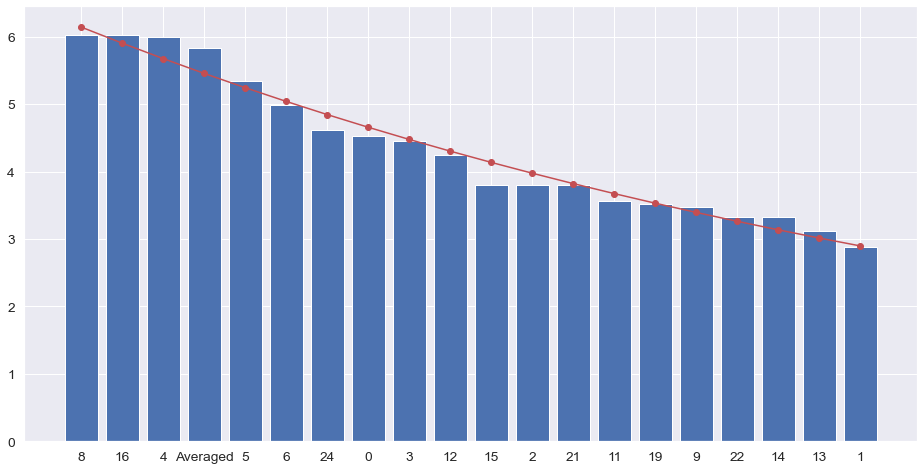

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plt.bar(x, features_importances_best_meta_model['Importance_(%)'])
plt.plot(x, real_importance, '-ro')
plt.xticks(x, features_importances_best_meta_model.index)

plt.show()

In [128]:
feature_deficiency, len(x), int( len(x)*( 1 + int(feature_deficiency)) )

(0.01, 20, 20)

The range of prediction for Model No. 0 are: [39735.9, 13261577.2] with the width of 13221841.3
The range of prediction for Model No. 1 are: [36938.9, 13269919.1] with the width of 13232980.2
The range of prediction for Model No. 2 are: [39259.3, 13263581.7] with the width of 13224322.4


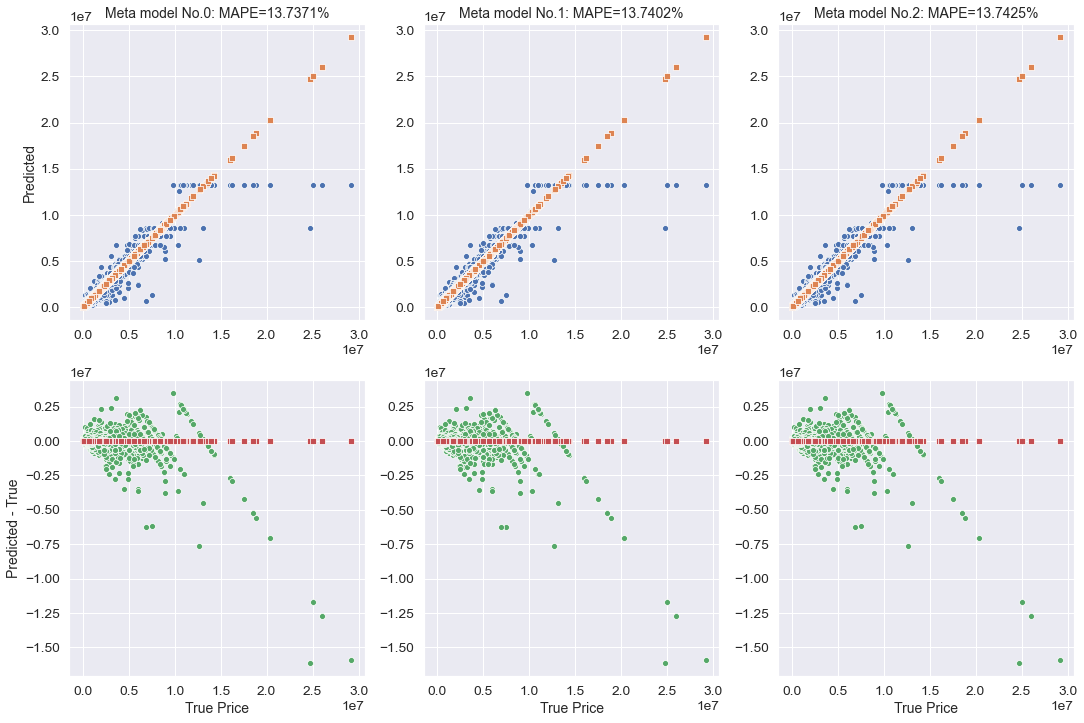

In [129]:
df = meta_model_storage


n = min(3, len(df))

fig, axes = plt.subplots(2, n, figsize=(6*n, 12) )

for i in range(n):
    model = df.loc[i, "model"]
#     prediction = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    print("The range of prediction for Model No. {} are: [{:.1f}, {:.1f}] with the width of {:.1f}"
          .format( i, prediction.min(), prediction.max(), prediction.max()-prediction.min() ))
    
    plt.subplot(2, n, i+1)
    sns.scatterplot(data_meta_valid[target_name], prediction)
    sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s')
    plt.title("Meta model No.{}: MAPE={:.4f}%".format(i, df.loc[i, "metrics"]), fontsize=FONT_SIZE)
    plt.xlabel("", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)
        
    plt.subplot(2, n, n+i+1)
    sns.scatterplot(data_meta_valid[target_name], prediction - data_meta_valid[target_name], color='g')
    sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name] - data_meta_valid[target_name], 
                    marker='s', color='r')
    plt.xlabel("True Price", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted - True", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)

##  7.3 Averaged over $\sqrt{N}$ and $N$ best meta models prediction (*LGBMRegressor*)

Text(0, 0.5, 'Predicted - True')

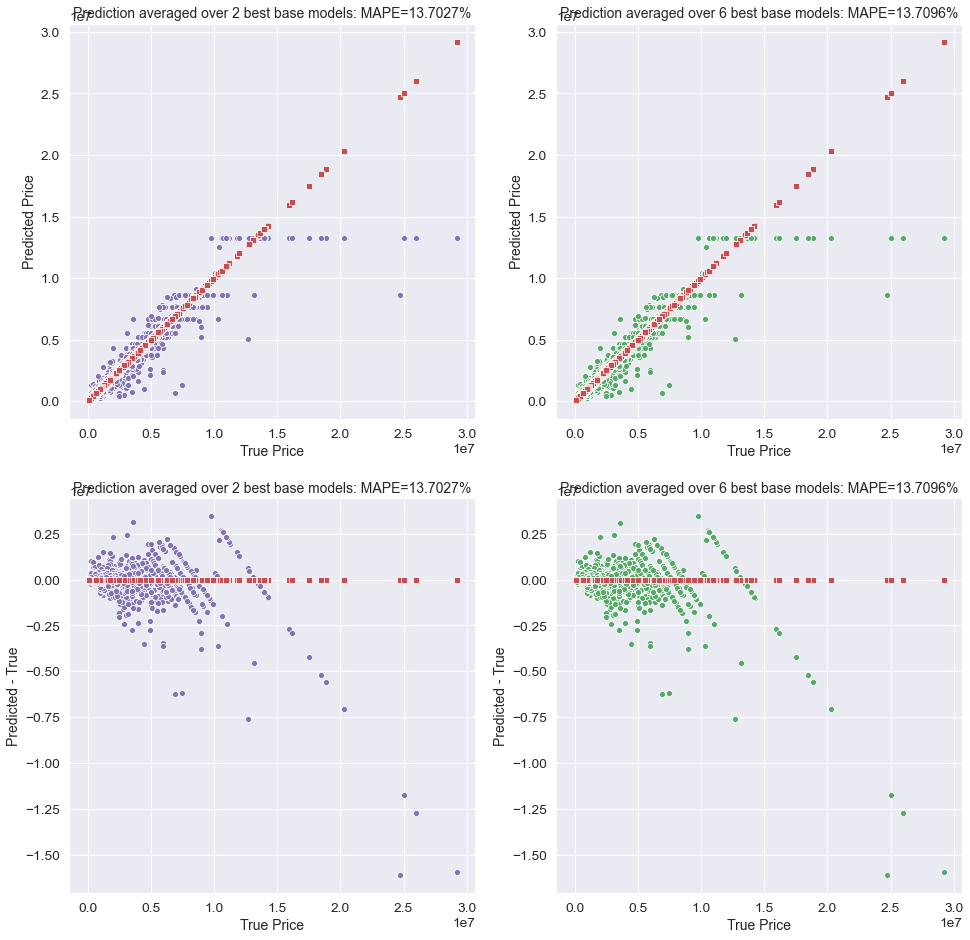

In [130]:
df = meta_model_storage

fig, axes = plt.subplots(2, 2, figsize=(16, 16))



### SQRT

n_models = int(np.sqrt(len(df)))

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    predictions.append(prediction)
    
predictions = np.array(predictions)
meta_mean_prediction_sqrt = predictions.mean(axis=0)
meta_mape_of_mean_sqrt = mean_absolute_percent_error(data_meta_valid[target_name], meta_mean_prediction_sqrt)


plt.subplot(2, 2, 1)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_sqrt, marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 3)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_sqrt - data_meta_valid[target_name], 
                marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name] - data_meta_valid[target_name], 
                marker='s', color='r')

plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)



### ALL

n_models = len(df)

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction_log10 = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction = 10**prediction_log10
    predictions.append(prediction)
    
predictions = np.array(predictions)
meta_mean_prediction_all = predictions.mean(axis=0)
meta_mape_of_mean_all = mean_absolute_percent_error(data_meta_valid[target_name], meta_mean_prediction_all)


plt.subplot(2, 2, 2)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_all, marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 4)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_all - data_meta_valid[target_name], 
                marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name] - data_meta_valid[target_name], 
                marker='s', color='r')

plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

In [131]:
performance_time = time.time() - total_time_start

running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:42:42.51    (H:MM:SS)


In [132]:
def two_digit_presentation(x):
    if x < 10:
        return "0" + str(x)
    else:
        return str(x)
    

    
def two_digit_time_presentation(x):
    hours = x//3600
    minutes = ( x - 3600*hours) // 60
    seconds = x - 3600*hours - 60*minutes
    if hours > 0:
        ans = (two_digit_presentation(int(hours)) +  " h " 
               + two_digit_presentation(int(minutes)) + " min " 
               + two_digit_presentation(int(seconds)) + " sec")
    elif minutes > 0:
        ans = (two_digit_presentation(int(minutes)) + " min " 
               + two_digit_presentation(int(seconds)) + " sec")
    else:
        ans = (two_digit_presentation(round(seconds, 3)) + " sec")
    return ans

<div class="alert alert-block alert-info">
<div style="border:solid blue 2px; padding: 20px"> <h1 style="color:blue; margin-bottom:20px">
99 Results</h1>

</div>

In [133]:
final_results = pd.DataFrame({'Action': ["Unoptimized model",
                                         "Best base model", "Best base averaged (sqrt 1)", 
                                         "Best base averaged (all 1)", "Best base averaged (all 2)", 
#                                          "Blending with LinearRegression", 
                                         "Best meta model", 
                                         "Meta averaged (sqrt 2)", "Meta averaged (all 2)]"],
                              "MAPE": [mape_unoptimized,
                                       base_model_storage.loc[0, "metrics"],  mape_of_mean_sqrt, 
                                       mape_of_mean_all, mape_averaged_meta_valid, 
#                                        mape_blend, 
                                       meta_model_storage.loc[0, "metrics"], 
                                       meta_mape_of_mean_sqrt, meta_mape_of_mean_all],
                              "Description": ["LightGBM with default parameters",
                                              "Calculated with valid_1.", 
                                              "Averaged over {} best models [valid_1]."
                                              .format( int(np.sqrt( len(base_model_storage) )) ), 
                                              ##
                                              "Averaged over {} best models [valid_1]."
                                              .format( len(base_model_storage) ), 
                                              "Averaged over {} best models [valid_2]."
                                              .format( len(base_model_storage) ), 
                                              ##
#                                               "Weighted mean for {} predictions (with averaged) [valid_2]."
#                                               .format( data_meta_valid.shape[1]-1 ), 
                                              "Calculated with valid_2.",
                                              ##
                                              "Averaged over {} best meta models [valid_2]."
                                              .format( int(np.sqrt( len(base_model_storage) )) ), 
                                              "Averaged over {} best meta models [valid_2]."
                                              .format( len(base_model_storage) ) ],
                              "Phase" : ["", "", "BAGGING", 
                                         "BAGGING", "BLENDING", 
                                         "STACKING", 
#                                          "BLENDING", 
                                         "STACKING", "STACKING"]})
final_results

Action       MAPE  \
0            Unoptimized model  13.843549   
1              Best base model  13.143471   
2  Best base averaged (sqrt 1)  13.146421   
3   Best base averaged (all 1)  13.121010   
4   Best base averaged (all 2)  13.400347   
5              Best meta model  13.737120   
6       Meta averaged (sqrt 2)  13.702670   
7       Meta averaged (all 2)]  13.709608   

                                    Description     Phase  
0              LightGBM with default parameters            
1                      Calculated with valid_1.            
2        Averaged over 5 best models [valid_1].   BAGGING  
3       Averaged over 25 best models [valid_1].   BAGGING  
4       Averaged over 25 best models [valid_2].  BLENDING  
5                      Calculated with valid_2.  STACKING  
6   Averaged over 5 best meta models [valid_2].  STACKING  
7  Averaged over 25 best meta models [valid_2].  STACKING

In [134]:
final_results.sort_values('MAPE', ascending=True)

Action       MAPE  \
3   Best base averaged (all 1)  13.121010   
1              Best base model  13.143471   
2  Best base averaged (sqrt 1)  13.146421   
4   Best base averaged (all 2)  13.400347   
6       Meta averaged (sqrt 2)  13.702670   
7       Meta averaged (all 2)]  13.709608   
5              Best meta model  13.737120   
0            Unoptimized model  13.843549   

                                    Description     Phase  
3       Averaged over 25 best models [valid_1].   BAGGING  
1                      Calculated with valid_1.            
2        Averaged over 5 best models [valid_1].   BAGGING  
4       Averaged over 25 best models [valid_2].  BLENDING  
6   Averaged over 5 best meta models [valid_2].  STACKING  
7  Averaged over 25 best meta models [valid_2].  STACKING  
5                      Calculated with valid_2.  STACKING  
0              LightGBM with default parameters

In [135]:
time_string_launch = date_start.strftime("%d %B %Y") + " at " + time_start.strftime("%H:%M")

date_finish = datetime.date.today()
time_finish = datetime.datetime.now().time()
time_string_finish = date_finish.strftime("%d %B %Y") + " at " + time_finish.strftime("%H:%M")


print( "The code was launched on              ", time_string_launch )
print( "The code finished its performance on  ", time_string_finish )
print()
print( "The full performance time is " + two_digit_time_presentation( performance_time ) )

The code was launched on               29 July 2020 at 18:06
The code finished its performance on   29 July 2020 at 18:48

The full performance time is 42 min 42 sec


## Appendix: Что ещё можно было бы сделать

1. Объединить `model` и `mark` в один признак.
2. Рефакторинг кода: есть остатки от предыдущих исследований с "висящими хвостами"
3. Сделать класс `LGBMBaging`:
  - принимает на вход параметры 
  - имеет метод `fit` (input: features_train, target_train)
  - имеет метод `predict` (input: features)
  - имеет метод `optimize` (желательно)

### VERSIONS

**Ver. 12 :** `Target is $\log_{10}({\rm price})$ instead of ${\rm price}$`
  - MAPE is decreased from 14.6% to 13.4% (the distributions turned to be smoother)

**Ver. 13 :** `Full dataset with data for 2006-2009`
  - MAPE is increased from 13.4% to 13.63% (more data, more variance)
  
**Ver. 14 :** 
1. `Testing various OBJECTIVEs`:
  - 'mse' (aka regression') - default: 13.63% 
  - 'mape' - same result as the best one, but much more longer (3 hrs vs 1 hr): 13.63% 
  - 'mae' - close to the best result (same time - aboun 56 min): 13.68% 
    - **Result:** OBJECTIVE = 'mse'
2. Does the qualification of `'doors_count' and 'owners' in dtype='category'` helps LGBM to determine them as categorical feanures automatically and leads to gain?
  - **Result:** Negative. 13.66% vs old 13.63%. Let them hold the dtype='int'.
3.  If I `drop 'owners'`, will it hepl? The LGBM always says that the importance of 'owners' is zero.
  - **Result:** Negative.
4. Data are normalized:
   - Only numerical
     - **Result:** Negative: 13.68% vs 13.63%.
5. Increase the distance between models in hyperparameter-space: 
    - from 1 to 3 for 'int'
    - from 0.001 to 0.005 for 'learning rate'
      - **Result:** Negative: 13.65% vs 13.63%.
    - from 1 to 5 for 'int'
    - from 0.001 to 0.01 for 'learning rate'
      - **Result:** Neutral: 13.63% = 13.63%.
    - from 1 to 7 for 'int'
    - from 0.001 to 0.03 for 'learning rate'
      - **Result:** Negative: 13.85% vs 13.46%.
      
**Ver. 15 :** 
  - target transformation
    - POWER = 2
      - **Result:** Neutral: 13.63% = 13.63%.
    - POWER = 1.5 (${\rm mean}\simeq {\rm median}\simeq {\rm center}$)
      - **Result:** Neutral: 13.63% = 13.63%.